In [1]:
import pandas as pd
import numpy as np
from snowflake.sqlalchemy import URL
import datetime as datetime
import warnings
from dateutil.relativedelta import relativedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

/Users/keyurpethad/anaconda3/lib/python3.11/site-packages/snowflake/connector/options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (11.0.0), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(


In [2]:
month = "Dec'23"
prev_month = "Nov'23"
two_months_ago = "Oct'23"
three_months_ago = "Sep'23"
month_start = datetime.datetime(2023,12,1)

In [3]:
master_calling = pd.read_excel("PL Loan Book Jan'24.xlsx", header=2)

In [4]:
master_calling.head()

,niro_user_id,Niro Opportunity ID,Disbursal Partner Name,Platform Partner Name,Lender Loan Id,Disbursement Month,Month Number,Disbursement Year,Phone Numbers,Disbursement Date,Presentation Lag,Gross PF Charged,PF Refund,Final Proc Fees,GST,Pre-EMI,Disbursed Amount,Loan Amount (all inclusive),Loan Amount Rank,Interest Rate,Tenor In Months,Tenor Rank,PF %,Cost of Funds,Cost of Funds (New),Spread,Monthly Emi,Monthly Income (Net Take Home),Income Rank,Income source,Self Employed,Nature of Business,# Years in Employment,Residence Ownership Type,Owned,Purpose of Loan,CIBIL Score,CIBIL Band,CIBIL Score Rank,Risk Band,Risk Segmentation,Disbursement TAT,City,State,Pin Code,Tier,Gender,Male,Female,Age,customer_router,CPV Initiated,Lead Name,Loan Status,Foreclosure Date,Foreclosure Details,NPA Details,NPA setteled Status,Write-off Month,Feb Presentation,Mar Presentation,Apr Presentation,May Presentation,Jun Presentation,Jul Presentation,Aug Presentation,Sep Presentation,Oct Presentation,Nov Presentation,Dec Presentation,Jan'23 Presentation,Feb'23 Presentation,Mar'23 Presentation,Apr'23 Presentation,May'23 Presentation,Jun'23 Presentation,July'23 Presentation,Aug'23 Presentation,Sep'23 Presentation,Oct'23 Presentation,Nov'23 Presentation,Dec'23 Presentation,Jan'24 Presentation,Feb DPD,Mar DPD,Apr DPD,May DPD,Jun DPD,Jul DPD,Aug DPD,Sep DPD,Oct DPD,Nov DPD,Dec DPD,Jan'23 DPD,Feb'23 DPD,Mar'23 DPD,Apr'23 DPD,May'23 DPD,Jun'23 DPD,July'23 DPD,Aug'23 DPD,Sep'23 DPD,Oct'23 DPD,Nov'23 DPD,Dec'23 DPD,Mar DPD Rank,PayU'July'23 DPD,PayU'Aug'23 DPD,PayU'Sep'23 DPD,PayU'Oct'23 DPD,PayU'Nov'23 DPD,PayU'Dec'23 DPD,Sep DPD Rank,Jan - POS,Feb - POS,Mar - POS,Apr - POS,May - POS,Jun - POS,Jul - POS,Aug - POS,Sep - POS,Oct - POS,Nov - POS,Dec - POS,Jan'23 - POS,Feb'23 - POS,Mar'23 - POS,Apr'23 - POS,May'23 - POS,Jun'23 - POS,July'23 - POS,Aug'23 - POS,Sep'23 - POS,Oct'23 - POS,Nov'23 - POS,Dec'23 - POS,Int * Loan Amount (all Incl),CoF * Loan Amount (all Incl),Tenor * Loan Amount (all Incl),PF * Loan Amount (all Incl),Spread * Loan Amount (all Incl),FOIR,Ok/Problem Areas,Repeat Cases,DPD 90+ Months,DPD 60+ Months,90+ Amount,Feb - Repaid,Mar - Repaid,Apr - Repaid,May - Repaid,Jun - Repaid,Jul - Repaid,Aug - Repaid,Sep - Repaid,Oct - Repaid,Nov - Repaid,Dec - Repaid,Jan'23 - Repaid,Feb'23 - Repaid,Mar'23 - Repaid,Apr'23 - Repaid,May'23 - Repaid,Jun'23 - Repaid,July'23 - Repaid,Aug'23 - Repaid,Sep'23 - Repaid,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173
0,0a2c0c4e-e0bf-4e50-909e-25ad6272119e,0f100756-11ae-4472-bd29-4fdbd6c37fdb,liquiloans,quikr,499217,2021-12-31,1,2021,9900368067,2021-12-31,Yes,2366,0,2366,426,0.0,50005,52797,2,27.0,12,2,0.044813,17.4,17.4,9.6,5069,26000,3,Salaried,0,'-',1,Rented,0,Others,764,760+,8,CAT-D,True,< 24 hrs,Bangalore,KARNATAKA,560085,Tier 1,Female,0,1,39,PL_OLD_PREAPPROVED,Yes,VINUTHA HONNE GOWDA,Closed,NaT,NaN,NaN,No,-,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Closed,Closed,Closed,Closed,Closed,Closed,Closed,Closed,Closed,Closed,Closed,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-,-,-,-,-,-,-,-,-,-,-,NaN,-,-,-,-,-,-,NaN,52797.0,48915.93250,44947.540981,40889.860653,36740.882518,32498.552375,28160.769803,23722.160542,19190.208334,14553.208334,9811.208334,4962.960521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1425519.0,918667.8,633564,2366.0,506851.2,0.44,OK Area,1.0,-,-,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31,1.0
1,e85b616e-e54b-4d67-b929-5f4b612404e2,188ec580-5b20-435b-8b02-b1fd0c439c6b,liquiloans,quikr,500342,2022-01-31,2,2022,8765513171,2022-01-04,No,2366,0,2366,426,0.0,50005,52797,2,27.0,12,2,0.044813,17.4,17.4,9.6,5069,20000,2,Salaried,0,'-',1.5,Owned,1,Marriage,746,740-760,7,CAT-D,True,< 24 hrs,Lucknow,UTTAR PRADESH,226029,Tier 2,Male,1,0,37,PL_OLD_PREAPPROVED,Yes,AKHILESH KUMAR YADAV,Foreclosed,2022-09-12,NaN,NaN,No,-,Cleared,Cleared,Cleared,Cleared,BOUNCED,BOUNCED,Bounce

In [5]:
master_calling['disb_dt'] = pd.to_datetime(master_calling['Disbursement Date'], format= '%d-%b-%y', errors = 'coerce')
master_calling['disb_yymm'] = master_calling['disb_dt'].dt.to_period('M').dt.to_timestamp()

master_calling['months_since_disb'] = (12*(month_start.year - master_calling['disb_yymm'].dt.year)+\
                           (month_start.month - master_calling['disb_yymm'].dt.month)+1).astype(int)
master_calling['PF'] = pd.to_numeric(master_calling["PF %"].astype(str).str.replace(" ","").str.replace("%","").str.strip())

#### EMI date Clearance type

In [6]:
master_calling[month + " clearance status"] = np.where(master_calling[month + " Presentation"].isin(['Cleared']), 'A) Cleared',
                                                np.where(master_calling[month + " Presentation"].isin(['Bounced', 'Bounced (DPD)', 'NPA (unsettled)', 'NPA']), 'B) Bounce',
                                                np.where(master_calling[month + " Presentation"].isin(['T-BOUNCE']), 'C) T-Bounce', #Technical Bounce
                                                np.where(master_calling[month + " Presentation"].isin(['Advance']), 'D) Advance',
                                                np.where(master_calling[month + " Presentation"].isin(['FORECLOSED', 'Closed', 'Settled', 'Foreclosed']), 'E) Closed',master_calling[month + " Presentation"])))))

master_calling[prev_month + " clearance status"] = np.where(master_calling[prev_month + " Presentation"].isin(['Cleared']), 'A) Cleared',
                                                np.where(master_calling[prev_month + " Presentation"].isin(['Bounced', 'Bounced (DPD)', 'NPA (unsettled)', 'NPA']), 'B) Bounce',
                                                np.where(master_calling[prev_month + " Presentation"].isin(['T-BOUNCE']), 'C) T-Bounce', #Technical Bounce
                                                np.where(master_calling[prev_month + " Presentation"].isin(['Advance']), 'D) Advance',
                                                np.where(master_calling[prev_month + " Presentation"].isin(['FORECLOSED', 'Closed', 'Settled', 'Foreclosed']), 'E) Closed',master_calling[prev_month + " Presentation"])))))
                                                
master_calling[two_months_ago + " clearance status"] = np.where(master_calling[two_months_ago + " Presentation"].isin(['Cleared']), 'A) Cleared',
                                                np.where(master_calling[two_months_ago + " Presentation"].isin(['Bounced', 'Bounced (DPD)', 'NPA (unsettled)', 'NPA']), 'B) Bounce',
                                                np.where(master_calling[two_months_ago + " Presentation"].isin(['T-BOUNCE']), 'C) T-Bounce', #Technical Bounce
                                                np.where(master_calling[two_months_ago + " Presentation"].isin(['Advance']), 'D) Advance',
                                                np.where(master_calling[two_months_ago + " Presentation"].isin(['FORECLOSED', 'Closed', 'Settled', 'Foreclosed']), 'E) Closed',master_calling[two_months_ago + " Presentation"])))))

master_calling[three_months_ago + " clearance status"] = np.where(master_calling[three_months_ago + " Presentation"].isin(['Cleared']), 'A) Cleared',
                                                np.where(master_calling[three_months_ago + " Presentation"].isin(['Bounced', 'Bounced (DPD)', 'NPA (unsettled)', 'NPA']), 'B) Bounce',
                                                np.where(master_calling[three_months_ago + " Presentation"].isin(['T-BOUNCE']), 'C) T-Bounce', #Technical Bounce
                                                np.where(master_calling[three_months_ago + " Presentation"].isin(['Advance']), 'D) Advance',
                                                np.where(master_calling[three_months_ago + " Presentation"].isin(['FORECLOSED', 'Closed', 'Settled', 'Foreclosed']), 'E) Closed',master_calling[three_months_ago + " Presentation"])))))

#### Pre presentation bucket

In [7]:
master_calling[prev_month + " DPD"].unique()

array(['-', 'NPA', 'NPA (Unsettled)', 1, '30+', '60+', 12, 20, 9, '1-29+',
       'Settled', '90+', 3, 4, 6, 5, 8, 7, 2, 26, 28, 13, 'Closed', 11,
       16, 18, 21, 15, 27, 22, 19, 25, 10, 14, 23,
       'Settled (partial paid)', 24, 17, 0, -7, 'Foreclosed'],
      dtype=object)

In [8]:
((pd.to_numeric(master_calling[prev_month + " DPD"], errors='coerce') >= 0) & (pd.to_numeric(master_calling[prev_month + " DPD"], errors='coerce') < 29)).sum()

3553

In [9]:
master_calling[month + " Presentation bucket"] = np.where(master_calling[prev_month + " DPD"].isin(['-']) | ((pd.to_numeric(master_calling[prev_month + " DPD"], errors='coerce') >= -45) & (pd.to_numeric(master_calling[prev_month + " DPD"], errors='coerce') <= 29)), 'A) Bkt 0',
                                                np.where(master_calling[prev_month + " DPD"].isin(['1-29+']), 'B) Bkt 1',
                                                np.where(master_calling[prev_month + " DPD"].isin(['30+']), 'C) Bkt 2',
                                                np.where(master_calling[prev_month + " DPD"].isin(['60+']), 'D) Bkt 3',
                                                np.where(master_calling[prev_month + " DPD"].isin(['90+']), 'E) Bkt 3+',
                                                np.where(master_calling[prev_month + " DPD"].isin(['NPA (Unsettled)', 'NPA']), 'E) Bkt 3+',
                                                np.where(master_calling[prev_month + " DPD"].isin(['Settled', 'Closed', 'Settled (partial paid)', 'Foreclosed']), 'F) Closed',master_calling[prev_month + " DPD"])))))))

master_calling[prev_month + " Presentation bucket"] = np.where(master_calling[two_months_ago + " DPD"].isin(['-']) | ((pd.to_numeric(master_calling[two_months_ago + " DPD"], errors='coerce') >= -45) & (pd.to_numeric(master_calling[two_months_ago + " DPD"], errors='coerce') <= 29)), 'A) Bkt 0',
                                                np.where(master_calling[two_months_ago + " DPD"].isin(['1-29+']), 'B) Bkt 1',
                                                np.where(master_calling[two_months_ago + " DPD"].isin(['30+']), 'C) Bkt 2',
                                                np.where(master_calling[two_months_ago + " DPD"].isin(['60+']), 'D) Bkt 3',
                                                np.where(master_calling[two_months_ago + " DPD"].isin(['90+']), 'E) Bkt 3+',
                                                np.where(master_calling[two_months_ago + " DPD"].isin(['NPA (Unsettled)', 'NPA']), 'E) Bkt 3+',
                                                np.where(master_calling[two_months_ago + " DPD"].isin(['Settled', 'Closed', 'Settled (partial paid)', 'Foreclosed']), 'F) Closed',master_calling[two_months_ago + " DPD"])))))))

master_calling[two_months_ago + " Presentation bucket"] = np.where(master_calling[three_months_ago + " DPD"].isin(['-']) | ((pd.to_numeric(master_calling[three_months_ago + " DPD"], errors='coerce') >= -45) & (pd.to_numeric(master_calling[three_months_ago + " DPD"], errors='coerce') <= 29)), 'A) Bkt 0',
                                                np.where(master_calling[three_months_ago + " DPD"].isin(['1-29+']), 'B) Bkt 1',
                                                np.where(master_calling[three_months_ago + " DPD"].isin(['30+']), 'C) Bkt 2',
                                                np.where(master_calling[three_months_ago + " DPD"].isin(['60+']), 'D) Bkt 3',
                                                np.where(master_calling[three_months_ago + " DPD"].isin(['90+']), 'E) Bkt 3+',
                                                np.where(master_calling[three_months_ago + " DPD"].isin(['NPA (Unsettled)', 'NPA']), 'E) Bkt 3+',
                                                np.where(master_calling[three_months_ago + " DPD"].isin(['Settled', 'Closed', 'Settled (partial paid)', 'Foreclosed']), 'F) Closed',master_calling[three_months_ago + " DPD"])))))))


### TAT calculation

In [10]:
month_df = pd.read_excel("Repayment_data_Sep'23 to Dec'23.xlsx", sheet_name=month)
prev_month_df = pd.read_excel("Repayment_data_Sep'23 to Dec'23.xlsx", sheet_name=prev_month)
two_months_ago_df = pd.read_excel("Repayment_data_Sep'23 to Dec'23.xlsx", sheet_name=two_months_ago)
three_months_ago_df = pd.read_excel("Repayment_data_Sep'23 to Dec'23.xlsx", sheet_name=three_months_ago)

In [11]:
month_df['EMI Submission date'] = pd.to_datetime(month_df['EMI Submission date'])
month_df['Collection Date'] = pd.to_datetime(month_df['Collection Date'], errors='coerce')

prev_month_df['EMI Submission date'] = pd.to_datetime(prev_month_df['EMI Submission date'])
prev_month_df['Collection Date'] = pd.to_datetime(prev_month_df['Collection Date'], errors='coerce')

two_months_ago_df['EMI Submission date'] = pd.to_datetime(two_months_ago_df['EMI Submission date'])
two_months_ago_df['Collection Date'] = pd.to_datetime(two_months_ago_df['Collection Date'], errors='coerce')

three_months_ago_df['EMI Submission date'] = pd.to_datetime(three_months_ago_df['EMI Submission date'])
three_months_ago_df['Collection Date'] = pd.to_datetime(three_months_ago_df['Collection Date'], errors='coerce')

In [12]:
month_df[month + ' TAT'] = np.where(month_df['Bounce Paid/unpaid'].isin(['Unpaid']), 999,
                        np.where(month_df['Bounce Paid/unpaid'].isin(['Settled', 'Settled (partial paid)']), 9999,
                        np.where(month_df['Bounce Paid/unpaid'].isin(['Advance']), -1,
                        np.where(month_df['Bounce Paid/unpaid'].isin(['Paid']),(month_df['Collection Date'] - month_df['EMI Submission date']).dt.days,
                        np.nan))))

prev_month_df[prev_month + ' TAT'] = np.where(prev_month_df['Bounce Paid/unpaid'].isin(['Unpaid']), 999,
                        np.where(prev_month_df['Bounce Paid/unpaid'].isin(['Settled', 'Settled (partial paid)']), 9999,
                        np.where(prev_month_df['Bounce Paid/unpaid'].isin(['Advance']), -1,
                        np.where(prev_month_df['Bounce Paid/unpaid'].isin(['Paid']),(prev_month_df['Collection Date'] - prev_month_df['EMI Submission date']).dt.days,
                        np.nan)))) 

two_months_ago_df[two_months_ago + ' TAT'] = np.where(two_months_ago_df['Bounce Paid/unpaid'].isin(['Unpaid']), 999,
                        np.where(two_months_ago_df['Bounce Paid/unpaid'].isin(['Settled', 'Settled (partial paid)']), 9999,
                        np.where(two_months_ago_df['Bounce Paid/unpaid'].isin(['Advance']), -1,
                        np.where(two_months_ago_df['Bounce Paid/unpaid'].isin(['Paid']),(two_months_ago_df['Collection Date'] - two_months_ago_df['EMI Submission date']).dt.days,
                        np.nan))))

three_months_ago_df[three_months_ago + ' TAT'] = np.where(three_months_ago_df['Bounce Paid/unpaid'].isin(['Unpaid']), 999,
                        np.where(three_months_ago_df['Bounce Paid/unpaid'].isin(['Settled', 'Settled (partial paid)']), 9999,
                        np.where(three_months_ago_df['Bounce Paid/unpaid'].isin(['Advance']), -1,
                        np.where(three_months_ago_df['Bounce Paid/unpaid'].isin(['Paid']),(three_months_ago_df['Collection Date'] - three_months_ago_df['EMI Submission date']).dt.days,
                        np.nan))))

month_df[month + ' TAT_bkt'] = np.where(month_df[month + ' TAT'] < -60, np.nan,
                                            np.where(month_df[month + ' TAT'] <= -10, 'A) <= -10',
                                            np.where(month_df[month + ' TAT'] < 0, 'B) -10 to -1',
                                            np.where(month_df[month + ' TAT'] == 0, 'C) 0',
                                            np.where(month_df[month + ' TAT'] <= 4, 'D) 1-4',
                                            np.where(month_df[month + ' TAT'] <= 10, 'E) 4-10',
                                            np.where(month_df[month + ' TAT'] <= 20, 'F) 10 - 20',
                                            np.where(month_df[month + ' TAT'] <= 29, 'G) 21 - 29',
                                            np.where(month_df[month + ' TAT'] == 999, 'H) Unpaid',
                                            np.where(month_df[month + ' TAT'] == 9999, 'I) Settled', month_df[month + ' TAT']))))))))))

prev_month_df[prev_month + ' TAT_bkt'] = np.where(prev_month_df[prev_month + ' TAT'] < -60, np.nan,
                                            np.where(prev_month_df[prev_month + ' TAT'] <= -10, 'A) <= -10',
                                            np.where(prev_month_df[prev_month + ' TAT'] < 0, 'B) -10 to -1',
                                            np.where(prev_month_df[prev_month + ' TAT'] == 0, 'C) 0',
                                            np.where(prev_month_df[prev_month + ' TAT'] <= 4, 'D) 1-4',
                                            np.where(prev_month_df[prev_month + ' TAT'] <= 10, 'E) 4-10',
                                            np.where(prev_month_df[prev_month + ' TAT'] <= 20, 'F) 10 - 20',
                                            np.where(prev_month_df[prev_month + ' TAT'] <= 29, 'G) 21 - 29',
                                            np.where(prev_month_df[prev_month + ' TAT'] == 999, 'H) Unpaid',
                                            np.where(prev_month_df[prev_month + ' TAT'] == 9999, 'I) Settled', prev_month_df[prev_month + ' TAT']))))))))))

two_months_ago_df[two_months_ago + ' TAT_bkt'] = np.where(two_months_ago_df[two_months_ago + ' TAT'] < -60, np.nan,
                                            np.where(two_months_ago_df[two_months_ago + ' TAT'] <= -10, 'A) <= -10',
                                            np.where(two_months_ago_df[two_months_ago + ' TAT'] < 0, 'B) -10 to -1',
                                            np.where(two_months_ago_df[two_months_ago + ' TAT'] == 0, 'C) 0',
                                            np.where(two_months_ago_df[two_months_ago + ' TAT'] <= 4, 'D) 1-4',
                                            np.where(two_months_ago_df[two_months_ago + ' TAT'] <= 10, 'E) 4-10',
                                            np.where(two_months_ago_df[two_months_ago + ' TAT'] <= 20, 'F) 10 - 20',
                                            np.where(two_months_ago_df[two_months_ago + ' TAT'] <= 29, 'G) 21 - 29',
                                            np.where(two_months_ago_df[two_months_ago + ' TAT'] == 999, 'H) Unpaid',
                                            np.where(two_months_ago_df[two_months_ago + ' TAT'] == 9999, 'I) Settled', two_months_ago_df[two_months_ago + ' TAT']))))))))))

three_months_ago_df[three_months_ago + ' TAT_bkt'] = np.where(three_months_ago_df[three_months_ago + ' TAT'] < -60, np.nan,
                                            np.where(three_months_ago_df[three_months_ago + ' TAT'] <= -10, 'A) <= -10',
                                            np.where(three_months_ago_df[three_months_ago + ' TAT'] < 0, 'B) -10 to -1',
                                            np.where(three_months_ago_df[three_months_ago + ' TAT'] == 0, 'C) 0',
                                            np.where(three_months_ago_df[three_months_ago + ' TAT'] <= 4, 'D) 1-4',
                                            np.where(three_months_ago_df[three_months_ago + ' TAT'] <= 10, 'E) 4-10',
                                            np.where(three_months_ago_df[three_months_ago + ' TAT'] <= 20, 'F) 10 - 20',
                                            np.where(three_months_ago_df[three_months_ago + ' TAT'] <= 29, 'G) 21 - 29',
                                            np.where(three_months_ago_df[three_months_ago + ' TAT'] == 999, 'H) Unpaid',
                                            np.where(three_months_ago_df[three_months_ago + ' TAT'] == 9999, 'I) Settled', three_months_ago_df[three_months_ago + ' TAT']))))))))))

In [13]:
master_calling.head(2)

,niro_user_id,Niro Opportunity ID,Disbursal Partner Name,Platform Partner Name,Lender Loan Id,Disbursement Month,Month Number,Disbursement Year,Phone Numbers,Disbursement Date,Presentation Lag,Gross PF Charged,PF Refund,Final Proc Fees,GST,Pre-EMI,Disbursed Amount,Loan Amount (all inclusive),Loan Amount Rank,Interest Rate,Tenor In Months,Tenor Rank,PF %,Cost of Funds,Cost of Funds (New),Spread,Monthly Emi,Monthly Income (Net Take Home),Income Rank,Income source,Self Employed,Nature of Business,# Years in Employment,Residence Ownership Type,Owned,Purpose of Loan,CIBIL Score,CIBIL Band,CIBIL Score Rank,Risk Band,Risk Segmentation,Disbursement TAT,City,State,Pin Code,Tier,Gender,Male,Female,Age,customer_router,CPV Initiated,Lead Name,Loan Status,Foreclosure Date,Foreclosure Details,NPA Details,NPA setteled Status,Write-off Month,Feb Presentation,Mar Presentation,Apr Presentation,May Presentation,Jun Presentation,Jul Presentation,Aug Presentation,Sep Presentation,Oct Presentation,Nov Presentation,Dec Presentation,Jan'23 Presentation,Feb'23 Presentation,Mar'23 Presentation,Apr'23 Presentation,May'23 Presentation,Jun'23 Presentation,July'23 Presentation,Aug'23 Presentation,Sep'23 Presentation,Oct'23 Presentation,Nov'23 Presentation,Dec'23 Presentation,Jan'24 Presentation,Feb DPD,Mar DPD,Apr DPD,May DPD,Jun DPD,Jul DPD,Aug DPD,Sep DPD,Oct DPD,Nov DPD,Dec DPD,Jan'23 DPD,Feb'23 DPD,Mar'23 DPD,Apr'23 DPD,May'23 DPD,Jun'23 DPD,July'23 DPD,Aug'23 DPD,Sep'23 DPD,Oct'23 DPD,Nov'23 DPD,Dec'23 DPD,Mar DPD Rank,PayU'July'23 DPD,PayU'Aug'23 DPD,PayU'Sep'23 DPD,PayU'Oct'23 DPD,PayU'Nov'23 DPD,PayU'Dec'23 DPD,Sep DPD Rank,Jan - POS,Feb - POS,Mar - POS,Apr - POS,May - POS,Jun - POS,Jul - POS,Aug - POS,Sep - POS,Oct - POS,Nov - POS,Dec - POS,Jan'23 - POS,Feb'23 - POS,Mar'23 - POS,Apr'23 - POS,May'23 - POS,Jun'23 - POS,July'23 - POS,Aug'23 - POS,Sep'23 - POS,Oct'23 - POS,Nov'23 - POS,Dec'23 - POS,Int * Loan Amount (all Incl),CoF * Loan Amount (all Incl),Tenor * Loan Amount (all Incl),PF * Loan Amount (all Incl),Spread * Loan Amount (all Incl),FOIR,Ok/Problem Areas,Repeat Cases,DPD 90+ Months,DPD 60+ Months,90+ Amount,Feb - Repaid,Mar - Repaid,Apr - Repaid,May - Repaid,Jun - Repaid,Jul - Repaid,Aug - Repaid,Sep - Repaid,Oct - Repaid,Nov - Repaid,Dec - Repaid,Jan'23 - Repaid,Feb'23 - Repaid,Mar'23 - Repaid,Apr'23 - Repaid,May'23 - Repaid,Jun'23 - Repaid,July'23 - Repaid,Aug'23 - Repaid,Sep'23 - Repaid,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,disb_dt,disb_yymm,months_since_disb,PF,Dec'23 clearance status,Nov'23 clearance status,Oct'23 clearance status,Sep'23 clearance status,Dec'23 Presentation bucket,Nov'23 Presentation bucket,Oct'23 Presentation bucket
0,0a2c0c4e-e0bf-4e50-909e-25ad6272119e,0f100756-11ae-4472-bd29-4fdbd6c37fdb,liquiloans,quikr,499217,2021-12-31,1,2021,9900368067,2021-12-31,Yes,2366,0,2366,426,0.0,50005,52797,2,27.0,12,2,0.044813,17.4,17.4,9.6,5069,26000,3,Salaried,0,'-',1,Rented,0,Others,764,760+,8,CAT-D,True,< 24 hrs,Bangalore,KARNATAKA,560085,Tier 1,Female,0,1,39,PL_OLD_PREAPPROVED,Yes,VINUTHA HONNE GOWDA,Closed,NaT,NaN,NaN,No,-,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Cleared,Closed,Closed,Closed,Closed,Closed,Closed,Closed,Closed,Closed,Closed,Closed,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-,-,-,-,-,-,-,-,-,-,-,NaN,-,-,-,-,-,-,NaN,52797.0,48915.9325,44947.540981,40889.860653,36740.882518,32498.552375,28160.769803,23722.160542,19190.208334,14553.208334,9811.208334,4962.960521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1425519.0,918667.8,633564,2366.0,506851.2,0.44,OK Area,1.0,-,-,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-31,1.0,2021-12-31,2021-12-01,25,0.044813,E) Closed,E) Closed,E) Closed,E) Closed,A) Bkt 0,A) Bkt 0,A) Bkt 0
1,e85b616e-e54b-4d67-b929-5f4b612404e2,188ec580-5b20-435b-8b02-b1fd0c439c6b,liquiloans,quikr,500342,2022-01-31,2,2022,8765513171,2022-01-04,No,2366,0,2366,426

In [14]:
prev_month_df.head(1)

,Opportunity ID,Loan Id,EMI Submission date,Bounced cases,Bounce Paid/unpaid,Collection Date,DPD,Nov'23 TAT,Nov'23 TAT_bkt
0,0f100756-11ae-4472-bd29-4fdbd6c37fdb,499217,2023-11-02,Closed,Closed,NaT,0,NaN,nan


In [15]:
master_calling = master_calling.merge(month_df.rename(columns = {'Opportunity ID':'Niro Opportunity ID'})[["Niro Opportunity ID", month + ' TAT', month + ' TAT_bkt']], on = "Niro Opportunity ID", how = "left") \
    .merge(prev_month_df.rename(columns = {'Opportunity ID':'Niro Opportunity ID'})[["Niro Opportunity ID", prev_month + ' TAT', prev_month + ' TAT_bkt']], on = "Niro Opportunity ID", how = "left") \
    .merge(two_months_ago_df.rename(columns = {'Opportunity ID':'Niro Opportunity ID'})[["Niro Opportunity ID", two_months_ago + ' TAT', two_months_ago + ' TAT_bkt']], on = "Niro Opportunity ID", how = "left") \
    .merge(three_months_ago_df.rename(columns = {'Opportunity ID':'Niro Opportunity ID'})[["Niro Opportunity ID", three_months_ago + ' TAT', three_months_ago + ' TAT_bkt']], on = "Niro Opportunity ID", how = "left") 

#### Creating Collection Data

In [16]:
master_calling.shape

(40070, 193)

In [17]:
cols = ['Lender Loan Id', 'Presentation Lag', 'Tenor In Months', 'Tenor Rank', 'Disbursed Amount', 'months_since_disb', 'PF', 'Monthly Income (Net Take Home)', 'Monthly Emi', 'Income Rank', 'City', 'State', 'Tier', 'Loan Status', 'FOIR', 'Ok/Problem Areas', 'Repeat Cases', 'Phone Numbers'] 
master_calling1 = master_calling[['niro_user_id', 'Niro Opportunity ID', month + " clearance status", month + " Presentation bucket", prev_month + ' TAT', prev_month + ' TAT_bkt', month + ' TAT_bkt', month + ' - POS'] + cols].rename(columns = {month + " clearance status" : "month_clearance_status", month + " Presentation bucket" : "month_presentation_bucket", prev_month + ' TAT': 'prev_month_TAT', prev_month + ' TAT_bkt': 'prev_month_TAT_bkt', month + ' TAT_bkt': 'month_TAT_bkt', month + ' - POS': 'month_POS'})

In [18]:
master_calling1[master_calling1["month_clearance_status"].isin(['B) Bounce', 'C) T-Bounce']) & master_calling1.month_TAT_bkt.isin(['nan', 'B) -10 to -1', 'A) <= -10'])].month_TAT_bkt.value_counts()

month_TAT_bkt
B) -10 to -1    14
nan              2
A) <= -10        1
Name: count, dtype: int64

In [19]:
master_calling1[master_calling1["month_clearance_status"].isin(['B) Bounce', 'C) T-Bounce'])].shape

(8702, 26)

In [20]:
master_calling1 = master_calling1[master_calling1["month_clearance_status"].isin(['B) Bounce', 'C) T-Bounce']) & ~master_calling1.month_TAT_bkt.isin(['nan', 'B) -10 to -1', 'A) <= -10'])]

In [21]:
master_calling1.loc[master_calling1.month_TAT_bkt.isin(["H) Unpaid", "I) Settled"]), 'Event'] = 1
master_calling1.loc[master_calling1.month_TAT_bkt.isin(['D) 1-4', 'F) 10 - 20', 'G) 21 - 29', 'E) 4-10', 'C) 0']), 'Event'] = 0

In [22]:
master_calling1.drop(columns = ['month_TAT_bkt'], inplace=True)

In [23]:
master_calling1.head()

,niro_user_id,Niro Opportunity ID,month_clearance_status,month_presentation_bucket,prev_month_TAT,prev_month_TAT_bkt,month_POS,Lender Loan Id,Presentation Lag,Tenor In Months,Tenor Rank,Disbursed Amount,months_since_disb,PF,Monthly Income (Net Take Home),Monthly Emi,Income Rank,City,State,Tier,Loan Status,FOIR,Ok/Problem Areas,Repeat Cases,Phone Numbers,Event
6,e9ed949b-e93b-42a2-ac21-2da7effa5564,8cf95828-6981-4f75-a766-f79769c8bd8a,B) Bounce,E) Bkt 3+,999.0,H) Unpaid,90887.788379,518818,No,18,3,180001,24,0.034993,30000,12295,3,Chennai,TAMIL NADU,Tier 1,NPA,0.42,Problem Area,1.0,9952744141,1.0
30,7b232688-b858-4018-9a29-d2ab52a39b76,b7d14eef-e5b4-4b55-9ee7-1c033f6ccc71,B) Bounce,E) Bkt 3+,999.0,H) Unpaid,11769.521788,583075,No,18,3,60003,23,0.039954,24000,4048,2,Thane,MAHARASHTRA,Tier 1,NPA,0.50,OK Area,1.0,9821845214,1.0
32,dceb0534-243c-4f67-94c3-ef8a0b45e6bc,cdf9f121-0176-4ca9-aa9d-f5d4048af74b,B) Bounce,A) Bkt 0,1.0,D) 1-4,12461.921883,589966,No,24,4,125003,23,0.034981,80000,6353,5,Hyderabad,ANDHRA PRADESH,Tier 1,Active,0.47,OK Area,1.0,9989185412,0.0
33,d49495cf-7cee-43fe-ba28-c6d4cee801a1,e345da0b-34fd-480c-bde5-4d94edd520bb,B) Bounce,C) Bkt 2,1.0,D) 1-4,48654.610670,587605,No,24,4,210001,23,0.014996,40000,10014,3,Kozhikode,KERALA,Tier 3,Active,0.44,OK Area,1.0,7021643837,1.0
34,83efdb11-99cc-4e7a-a1cd-6f0cbf4656f1,dd5f7140-b43c-4712-9ac6-ea4abe82a330,B) Bounce,E) Bkt 3+,999.0,H) Unpaid,26670.448080,589873,No,15,3,50004,23,0.039941,40000,4161,3,Bangalore,KARNATAKA,Tier 1,NPA,0.47,OK Area,1.0,7085197694,1.0


#### Advance Collection file

In [24]:
adv_coll_tag = pd.read_excel('advance collection detailing report.xlsx', sheet_name=month).rename(columns = {'opportunity_id':'Niro Opportunity ID', 'Code':'Code_'+month, 'Status':'Status_'+month, 'Code_meaning':'Code_meaning_'+month})
adv_coll_tag.head()

,Niro Opportunity ID,Code_Dec'23,EMI,Status_Dec'23,Code_meaning_Dec'23
0,cdf9f121-0176-4ca9-aa9d-f5d4048af74b,CTB,6353,Notcollected,Current month bounced and non dpd ( voucher )
1,f9fcd6d5-dcfc-4c64-8a00-c999a4fea08f,NTB-6N,8090,Notcollected,never bounced Minimum 6 months
2,e345da0b-34fd-480c-bde5-4d94edd520bb,CMU-DPD,10014,Notcollected,Current month bounce and DPD
3,2bef54d9-cca9-4f44-915a-bf039fc486ba,NTB-6N,4146,Notcollected,never bounced Minimum 6 months
4,ce06a9a0-8b47-44f8-af4a-fd6b0fda7224,CMU-DPD,3842,Notcollected,Current month bounce and DPD


In [25]:
adv_coll_tag.rename(columns = {'Code_'+month:'advance_collection_code_month', 'Status_'+month: 'advance_collection_status_month'}, inplace=True)

In [26]:
master_data = master_calling1.merge(adv_coll_tag[['Niro Opportunity ID', 'advance_collection_code_month']], on = 'Niro Opportunity ID', how='left')

In [27]:
master_data.head()

,niro_user_id,Niro Opportunity ID,month_clearance_status,month_presentation_bucket,prev_month_TAT,prev_month_TAT_bkt,month_POS,Lender Loan Id,Presentation Lag,Tenor In Months,Tenor Rank,Disbursed Amount,months_since_disb,PF,Monthly Income (Net Take Home),Monthly Emi,Income Rank,City,State,Tier,Loan Status,FOIR,Ok/Problem Areas,Repeat Cases,Phone Numbers,Event,advance_collection_code_month
0,e9ed949b-e93b-42a2-ac21-2da7effa5564,8cf95828-6981-4f75-a766-f79769c8bd8a,B) Bounce,E) Bkt 3+,999.0,H) Unpaid,90887.788379,518818,No,18,3,180001,24,0.034993,30000,12295,3,Chennai,TAMIL NADU,Tier 1,NPA,0.42,Problem Area,1.0,9952744141,1.0,NaN
1,7b232688-b858-4018-9a29-d2ab52a39b76,b7d14eef-e5b4-4b55-9ee7-1c033f6ccc71,B) Bounce,E) Bkt 3+,999.0,H) Unpaid,11769.521788,583075,No,18,3,60003,23,0.039954,24000,4048,2,Thane,MAHARASHTRA,Tier 1,NPA,0.50,OK Area,1.0,9821845214,1.0,NaN
2,dceb0534-243c-4f67-94c3-ef8a0b45e6bc,cdf9f121-0176-4ca9-aa9d-f5d4048af74b,B) Bounce,A) Bkt 0,1.0,D) 1-4,12461.921883,589966,No,24,4,125003,23,0.034981,80000,6353,5,Hyderabad,ANDHRA PRADESH,Tier 1,Active,0.47,OK Area,1.0,9989185412,0.0,CTB
3,d49495cf-7cee-43fe-ba28-c6d4cee801a1,e345da0b-34fd-480c-bde5-4d94edd520bb,B) Bounce,C) Bkt 2,1.0,D) 1-4,48654.610670,587605,No,24,4,210001,23,0.014996,40000,10014,3,Kozhikode,KERALA,Tier 3,Active,0.44,OK Area,1.0,7021643837,1.0,CMU-DPD
4,83efdb11-99cc-4e7a-a1cd-6f0cbf4656f1,dd5f7140-b43c-4712-9ac6-ea4abe82a330,B) Bounce,E) Bkt 3+,999.0,H) Unpaid,26670.448080,589873,No,15,3,50004,23,0.039941,40000,4161,3,Bangalore,KARNATAKA,Tier 1,NPA,0.47,OK Area,1.0,7085197694,1.0,NaN


#### Pre disbursal data

In [28]:
from sqlalchemy import create_engine


class extractorFromQuery:
    def __init__(self):
        self.credentials = {
            "account": "qfi-niro",
            "user": "niro_analytics",
            "password": "4qVe_V-aEq,j.i,",
            "warehouse": "NIRO_ANALYTICS_WAREHOUSE",
        }

    def queryExecutor(self, query: str, *args):
        engine = create_engine(URL(**self.credentials))
        res = pd.read_sql_query(query, engine, params=args)
        return res

In [29]:
disbursed_cases = """
    select 
    la.id,
    ou.category,
    la.principal_amount,
    la.interest_rate,
    la.tenure,
    o.attributed_partner as "supply",
    o.propensity,
    o.offer_type,
    o.max_amount,
    tu.income_source,
    tu.purpose_of_loan,
    tu.residence_ownership_type,
    tu.marital_status,
    cpv.cpv_type,
    l.name as "demand",
    CASE
        when la.loan_disbursed_date_by_ops is null then date(la.disbursement_date)
        else date(la.loan_disbursed_date_by_ops)
    end as disbursement_date
    from niro_rds.niro_data.core__public__loan_application la
    left join NIRO_RDS.NIRO_DATA.CORE__PUBLIC__OFFERS o on o.id = la.offer_id
    left join NIRO_RDS.NIRO_DATA.core__public__offer_user_details ou on ou.offer_id = o.id
    left join NIRO_RDS.NIRO_DATA.CORE__PUBLIC__VERIFICATION_DETAILS vd on vd.id = la.verification_id 
    left join NIRO_RDS.NIRO_DATA.CORE__PUBLIC__TELE_PD_USER tu on vd.telepd_id::bigint = tu.id
    left join NIRO_RDS.NIRO_DATA.CORE__PUBLIC__CP_VERIFICATION cpv on cpv.id = vd.cpv_id::bigint
    left join NIRO_RDS.NIRO_DATA.CORE__PUBLIC__LENDERS l on l.id = o.lender_uid
    where la.loan_application_status in ('CLOSED','LOAN_EXECUTED') and la.is_deleted = False and o.is_deleted = False;
"""
total_disbursed_cases = extractorFromQuery().queryExecutor(disbursed_cases)
total_disbursed_cases.shape

(43853, 16)

In [30]:
total_disbursed_cases['residence_ownership_type'] = total_disbursed_cases.residence_ownership_type.str.lower().replace({'family_owned':'family owned'}).replace({'owned':'self owned'}).replace({'pg':'rented'}).replace({'room sharing':'rented'}).replace({'ancestral property':'family owned'})

In [31]:
disbursed_cases_with_cvattrs = """
            select * from (
            select 
            distinct la.id,
            pii.gender as bureau_gender,
            pii.pin as bureau_pincode,
            pii.calculated_age,
            pii.city as bureau_city,
            pii.state as bureau_state,
            pii.native_language,
            date_trunc("MONTH",date(od.created_at)) as createdate,
            od.current_salary,
            od.available_income,
            od.foir_dlq, od.foir_cibil, od.foir_trd, od.foir_mean, od.new_foir, 
            od.naps_score as naps_disb_score,
            rank()over(partition by od.user_id order by od.created_at asc) as rnk,
            CASE
                when la.loan_disbursed_date_by_ops is null then date(la.disbursement_date)
                else date(la.loan_disbursed_date_by_ops)
            END as disbursement_date
            from NIRO_RDS.NIRO_DATA.CORE__PUBLIC__LOAN_APPLICATION la
            left join NIRO_RDS.NIRO_DATA.core__public__offer_user_details ou on ou.offer_id = la.offer_id
            left join ANALYTICS.OFFERS.offer_details od on od.user_id = la.user_id and od.category = ou.category
            left join ANALYTICS.OFFERS.personal_info pii on od.pii_id = pii.pii_id
            where la.loan_application_status in ('CLOSED','LOAN_EXECUTED') 
            and la.is_deleted = False
            and(la.is_deleted_at_source = false or la.is_deleted_at_source is null)
            and od.dec_reason = 'NOT DECLINED')
where rnk = 1;
"""
disbursed_cases = (
    extractorFromQuery()
    .queryExecutor(disbursed_cases_with_cvattrs)
    .drop(columns="disbursement_date")
)
disbursed_cases.shape

(42174, 17)

In [32]:
disbursed_cases = disbursed_cases.drop_duplicates(subset=["id"])
predisbursal_data = total_disbursed_cases.merge(disbursed_cases, on="id", how="left").rename(
    columns={"id": "niro_opportunity_id"}
)
predisbursal_data.drop_duplicates(subset=["niro_opportunity_id"], inplace=True)
predisbursal_data.shape

(43853, 32)

In [33]:
predisbursal_data['propensity'] = np.where(predisbursal_data['propensity'].isin(['HiiProp', 'High']), 'High',
                                  np.where(predisbursal_data['propensity'].isin(['MedProp', 'Med', 'Medium']), 'Medium',
                                  np.where(predisbursal_data['propensity'].isin(['LowProp', 'Low']), 'Low',None)))

In [34]:
predisbursal_data.head()

,niro_opportunity_id,category,principal_amount,interest_rate,tenure,supply,propensity,offer_type,max_amount,income_source,purpose_of_loan,residence_ownership_type,marital_status,cpv_type,demand,disbursement_date,bureau_gender,bureau_pincode,calculated_age,bureau_city,bureau_state,native_language,createdate,current_salary,available_income,foir_dlq,foir_cibil,foir_trd,foir_mean,new_foir,naps_disb_score,rnk
0,92248596-1802-40a4-a07c-9ee3b216184b,CAT-C,73377,25,16,snapdeal,High,PRE_APPROVED,90000,Salaried,House Renovation,family owned,SINGLE,PHYSICAL,payu,2023-09-13,Female,400086,25.0,MUMBAI,MAHARASHTRA,Marathi,2023-06-01,48000.00,18960.45,0.5,0.4,0.50,0.47,77.60,704.0,1.0
1,af62cbfa-4b04-4099-a2e1-e172852aadad,CAT-B,248637,19,24,snapdeal,Medium,PRE_APPROVED,240000,Self Employed,Purchase,family owned,MARRIED,REMOTE,liquiloans,2023-09-13,Male,422202,34.0,NASHIK,MAHARASHTRA,English,2023-02-01,75900.00,25282.42,0.5,0.4,0.40,0.43,64.65,753.0,1.0
2,7e606125-ce29-4a26-bb6e-48d7706d6dcd,CAT-A,497008,19,36,housing,High,PRE_APPROVED,480000,Salaried,House Renovation,self owned,MARRIED,REMOTE,payu,2023-09-15,Male,482001,30.0,JABALPUR,MADHYA PRADESH,Marathi,2023-05-01,182080.92,73738.67,0.5,0.4,0.36,0.42,40.05,802.0,1.0
3,d2ad8c64-0a97-4e55-90ba-608e4f216291,CAT-A,403819,20,36,niro,High,PRE_APPROVED,390000,Salaried,To close ongoing loans,self owned,MARRIED,REMOTE,payu,2023-09-12,Male,382330,32.0,GANDHI NAGAR,GUJARAT,English,2023-08-01,480000.00,214283.29,0.5,0.4,0.36,0.42,32.10,815.0,1.0
4,aa8c8fbb-ba02-41ea-9407-ade637afc1b0,CAT-B,208359,21,36,snapdeal,High,PRE_APPROVED,200000,Salaried,Purchase,family owned,SINGLE,REMOTE,payu,2023-09-29,Male,390010,28.0,VADODARA,GUJARAT,Gujarati,2023-05-01,48000.00,20188.54,0.5,0.4,0.40,0.43,81.53,718.0,1.0


In [35]:
master_data.shape

(8685, 27)

In [36]:
master_data = pd.merge(master_data.rename(columns = {'Niro Opportunity ID': 'niro_opportunity_id'}), predisbursal_data , on = 'niro_opportunity_id', how = 'inner')

In [37]:
master_data.tail()

,niro_user_id,niro_opportunity_id,month_clearance_status,month_presentation_bucket,prev_month_TAT,prev_month_TAT_bkt,month_POS,Lender Loan Id,Presentation Lag,Tenor In Months,Tenor Rank,Disbursed Amount,months_since_disb,PF,Monthly Income (Net Take Home),Monthly Emi,Income Rank,City,State,Tier,Loan Status,FOIR,Ok/Problem Areas,Repeat Cases,Phone Numbers,Event,advance_collection_code_month,category,principal_amount,interest_rate,tenure,supply,propensity,offer_type,max_amount,income_source,purpose_of_loan,residence_ownership_type,marital_status,cpv_type,demand,disbursement_date,bureau_gender,bureau_pincode,calculated_age,bureau_city,bureau_state,native_language,createdate,current_salary,available_income,foir_dlq,foir_cibil,foir_trd,foir_mean,new_foir,naps_disb_score,rnk
8679,c95b0064-aed3-4c9e-a987-7966576bae89,7cae8b18-e818-4d83-9808-e277550e5e98,B) Bounce,A) Bkt 0,NaN,NaN,238613.0,6656617,No,24,4,240000,2,0.031998,90000,12804,5,Hyderabad,ANDHRA PRADESH,Tier 1,Active,NaN,NaN,1.0,9160327237,0.0,FTB,CAT-B,249418,21,24,niro,High,PRE_APPROVED,240000,Salaried,Purchase,self owned,MARRIED,REMOTE,liquiloans,2023-11-20,Male,500089,36.0,HYDERABAD,ANDHRA PRADESH,Telugu,2023-03-01,285572.57,61080.80,0.5,0.4,0.43,0.44,53.54,882.0,1.0
8680,dd950540-702d-468f-b442-1a109734795e,5febb8fc-6eef-483f-8e9a-319bbdcb836b,B) Bounce,A) Bkt 0,NaN,NaN,118490.0,PFNISC21000011035660,No,18,3,120000,2,0.039002,45000,8343,3,Chhindwara,MADHYA PRADESH,Tier 3,Active,NaN,NaN,1.0,9755678769,0.0,FTB,CAT-C,125789,25,18,snapdeal,High,PRE_APPROVED,120000,Self Employed,Purchase,family owned,MARRIED,REMOTE,payu,2023-11-20,Male,480001,42.0,CHHINDWARA,MADHYA PRADESH,Marathi,2023-08-01,48000.00,20541.75,0.5,0.4,0.50,0.47,73.65,714.0,1.0
8681,f9231b6b-a917-4b81-bdc8-4b6531eb9d10,b9aeb792-7d4a-43aa-ba71-f548d7817ae8,B) Bounce,A) Bkt 0,NaN,NaN,237372.0,6700887,No,24,4,240000,2,0.029002,60000,13003,4,Kushinagar,UTTAR PRADESH,Tier 3,Active,NaN,NaN,1.0,7309737130,0.0,FTB,CAT-B,248504,23,24,snapdeal,High,PRE_APPROVED,240000,Salaried,Purchase,family owned,SINGLE,REMOTE,liquiloans,2023-11-20,Male,274001,38.0,DEORIA,UTTAR PRADESH,Malayalam,2023-07-01,72844.20,21016.85,0.5,0.4,0.40,0.43,76.23,729.0,1.0
8682,74e1d85a-4da0-4d1c-9ef3-cfb7864fb76a,ce103083-eaf7-4986-8d22-a44fc5e57f76,B) Bounce,A) Bkt 0,NaN,NaN,387756.0,PFNISC21000010271269,Yes,36,5,380000,6,0.034000,45000,14692,3,0,0,NaN,Active,NaN,NaN,NaN,7990133613,0.0,FTB,CAT-B,395883,20,36,niro,Medium,PRE_APPROVED,380000,Salaried,Health/Hospital,family owned,MARRIED,REMOTE,payu,2023-07-25,Male,390007,28.0,VADODARA,GUJARAT,Gujarati,2023-05-01,114660.00,49240.00,0.5,0.4,0.43,0.44,44.42,880.0,1.0
8683,d47e2615-9f04-4660-8775-6c127b51bfd2,cf5fff33-40ad-43f4-931b-8f4a86fc4c2e,B) Bounce,A) Bkt 0,NaN,NaN,169774.0,PFNISC21000010271271,Yes,18,3,170000,6,0.039001,59000,11739,4,0,0,NaN,Active,NaN,NaN,NaN,9555426686,0.0,FTB,CAT-D,178201,22,18,niro,Medium,PRE_APPROVED,170000,Salaried,House Renovation,self owned,MARRIED,PHYSICAL,payu,2023-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Scrub data

In [38]:
scrub_data = pd.read_csv('Disbursed_cases_Scrub_05112023.csv')
scrub_data.head()

,Sequence No,Account No,Adviser Transaction No,Member Reference,Mobile_No,Total Features,AGG911,RVLR01,BCPMTSTR,CV11,CV14,MT28S,MT33S,PL33S,AT20S,MT01S,BC02S,BG01S,CV10,TRD,AT33A,AU33S,CO04S180,AU28S,PL28S,CO01S180,BC28S,CV12,CO05S,G310S,AGGS911,AT01S,AT33A_NE_CCOD,CV14_12M,CV14_6M,CV14_3M,CV14_1M,G310S_24M,G310S_6M,G310S_3M,G310S_1M,CV11_24M,CV11_12M,G057S_1DPD_36M,G057S_1DPD_12M,BC106S_60DPD,BC107S_24M,BC106S_60DPD_12M,BC107S_12M,BC106S_LE_30DPD_12M,BC09S_36M_HCSA_LE_30,PL09S_36M_HCSA_LE_30,AT09S_6M,G310S_36M,AT33A_NE_WO,AT09S_12M,AT09S_3M,CV13,CV24,REVS904,CV20,CV22,UL_TRD,CV21,G310S_2M,Secured Accounts Count,Unsecured Accounts Count,Secured High Credit Sum,Unsecured High Credit Sum,Secured Amount Overdue Sum,Unsecured Amount Overdue Sum,Secured Balances Sum,Unsecured Balances Sum,Own Accounts count,Other Accounts count,CIBILTUSC3 Score Value,CIBILTUSC3 Score Reason Code Set,CIBILTUSC3 Score Exclusion Code Set,CIBILTUSC3 Score Error Code Set,Unnamed: 78
0,0,NaN,1524319715,ASGPR7783R,9914657792,59,5.56,0.00,RVLRPLUS,0,50,-1.0,-1.0,803368.0,102,0,3,0,0,21,845232.0,-1.0,-1,-1.0,873464.0,0,550000.0,0,-1.0,1.5,0,11,826686.0,24,7,3,0,1.5,1.5,1.5,0.0,0,0,21,21,0,0,0,0,6,2,0,0,1.5,-1.0,4,0,0,15000.0,138641.0,927.30,18546.0,20,15000.0,1.5,0,14,0.0,1828480.0,0.0,11744.0,0.0,845232.0,0,15,720,"""[37, 35, 39, 26, 25]""","""[]""","""[]""",NaN
1,1,NaN,1524319716,ANJPK5437H,9398125492,59,-1.00,-1.00,NOBC,0,18,2000000.0,1028693.0,1203639.0,226,1,-1,0,0,8,2232332.0,-3.0,-1,-3.0,1203639.0,0,-1.0,0,-1.0,1.0,-1,6,2232332.0,3,2,2,0,1.0,1.0,1.0,0.0,0,0,8,8,-1,-1,-1,-1,-1,-5,0,2,1.0,-1.0,2,2,0,-1.0,-1.0,4114.00,-1.0,6,418713.0,0.0,1,4,2000000.0,1900482.0,0.0,0.0,1028693.0,1203639.0,0,5,776,"""[45]""","""[]""","""[]""",NaN
2,2,NaN,1524319717,HTOPK6367Q,7305601276,59,-1.00,-1.00,NOBC,1,20,-1.0,-1.0,19970.0,66,0,-1,0,1,6,19970.0,-1.0,4,-1.0,69484.0,1,-1.0,1,-1.0,6.0,-1,5,19970.0,12,5,3,0,6.0,6.0,6.0,0.0,1,1,6,6,-1,-1,-1,-1,-1,-5,2,0,6.0,-1.0,2,0,17,-1.0,-1.0,5749.00,-1.0,5,58843.0,6.0,0,5,0.0,84224.0,0.0,22593.0,0.0,19970.0,0,5,659,"""[03, 08, 02, 07, 04]""","""[]""","""[]""",NaN
3,3,NaN,1524319720,KVDPK8164F,9423516766,59,13.73,0.00,TRANSACTOR,0,10,-1.0,-1.0,26407.0,48,0,1,0,0,16,104847.0,-1.0,-1,-1.0,52412.0,0,15000.0,0,-1.0,1.5,14,10,102787.0,0,0,0,0,1.5,1.5,1.5,0.0,0,0,16,16,0,0,0,0,1,1,5,6,1.5,-1.0,6,3,0,-2.0,2060.0,25434.00,2060.0,8,75222.0,1.0,8,8,127609.0,108971.0,0.0,0.0,58985.0,45862.0,0,16,708,"""[35, 40, 39, 26, 38]""","""[]""","""[]""",NaN
4,4,NaN,1524319721,LBVPS4263G,8077030887,59,71.26,22.28,RVLRPLUS,0,18,-1.0,-1.0,236685.0,37,0,5,0,0,16,309375.0,-1.0,-1,-1.0,279385.0,0,205205.0,0,-1.0,1.0,21,9,272370.0,12,6,2,0,1.0,1.0,1.0,0.0,0,0,16,16,0,0,0,0,5,5,1,3,1.0,-1.0,10,1,0,30349.0,32274.0,15498.25,37005.0,14,55219.0,1.0,0,14,0.0,519439.0,0.0,0.0,0.0,309375.0,0,16,767,"""[39, 25, 36, 40, 38]""","""[]""","""[]""",NaN


In [39]:
scrub_data.shape

(22910, 80)

In [40]:
column_name_map = {'AGG911': 'max_aggregate_bankcard_utilisation_l12m',
 'RVLR01': 'cc_util_revolving_l1m',
 'BCPMTSTR': 'bank_card_payment_category',
 'CV11': 'no_of_60p_accs_ever',
 'CV14': 'no_of_deduped_inquiries',
 'MT28S': 'total_cl_open_mortgage_trades_l12m',
 'MT33S': 'total_balance_open_mortgage_trades_l12m',
 'PL33S': 'total_bal_of_open_pl_l12m',
 'AT20S': 'months_since_oldest_trade',
 'MT01S': 'no_of_mortgage_trades',
 'BC02S': 'no_of_open_cc_trades',
 'BG01S': 'no_of_business_general_trades',
 'CV10': 'no_of_30p_accs_ever',
 'TRD': 'no_of_trades',
 'AT33A': 'total_bal_open_trades_l12m',
 'AU33S': 'total_bal_open_auto_trades_l12m',
 'CO04S180': 'months_since_recent_chargedoff180P',
 'AU28S': 'total_cl_open_auto_trades_l12m',
 'PL28S': 'total_cl_open_pl_trades_l12m',
 'CO01S180': 'no_of_chargedoff180P',
 'BC28S': 'total_cl_of_cc_trades_l12m',
 'CV12': 'no_of_90p_accs_ever',
 'CO05S': 'total_bal_of_chargedoff_trades',
 'G310S': 'worst_rating_l12m',
 'AGGS911': 'current_utilization_of_top_wallet_bankcard',
 'AT01S': 'no_of_trades_pl_2w_gl_cd',
 'AT33A_NE_CCOD': 'total_bal_open_trades_l12m_except_wo_cc_od',
 'CV14_12M': 'no_of_deduped_inquiries_l12m',
 'CV14_6M': 'no_of_deduped_inquiries_l6m',
 'CV14_3M': 'no_of_deduped_inquiries_l3m',
 'CV14_1M': 'no_of_deduped_inquiries_l1m',
 'G310S_24M': 'worst_rating_l24m',
 'G310S_6M': 'worst_rating_l6m',
 'G310S_3M': 'worst_rating_l3m',
 'G310S_1M': 'worst_rating_l1m',
 'CV11_24M': 'no_of_60p_accs_l24m',
 'CV11_12M': 'no_of_60p_accs_l12m',
 'G057S_1DPD_36M': 'no_of_trades_bounced_l36m',
 'G057S_1DPD_12M': 'no_of_trades_bounced_l12m',
 'BC106S_60DPD': 'no_of_cc_trades_60P_l24m',
 'BC107S_24M': 'no_of_30P_cc_l24m',
 'BC106S_60DPD_12M': 'no_of_cc_trades_60P_l12m',
 'BC107S_12M': 'no_of_30P_cc_l12m',
 'BC106S_LE_30DPD_12M': 'no_of_cc_lt30p_l12m',
 'BC09S_36M_HCSA_LE_30': 'no_cc_sanctionedamt_lt30K_l36m',
 'PL09S_36M_HCSA_LE_30': 'no_pl_sanctionedamt_lt30K_l36m',
 'AT09S_6M': 'no_tr_opened_l6m',
 'G310S_36M': 'worst_dpd_l36m',
 'AT33A_NE_WO': 'total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades',
 'AT09S_12M': 'no_tr_opened_l12m',
 'AT09S_3M': 'no_tr_opened_l3m',
 'CV13': 'per_of_30p_accs_ever',
 'CV24': 'total_payment_amount_bankcard_accs_l3m',
 'REVS904': 'max_revolving_monthly_spend_l12m',
 'CV20': 'total_monthly_obligations_l3m',
 'CV22': 'total_balance_bankcard_accs_l3m',
 'UL_TRD': 'no_of_trades_unsec',
 'CV21': 'total_payment_amount_l3m',
 'G310S_2M': 'worst_dpd_l2m'}

In [41]:
scrub_data.rename(columns = column_name_map, inplace=True)

In [42]:
scrub_data.head()

,Sequence No,Account No,Adviser Transaction No,Member Reference,Mobile_No,Total Features,max_aggregate_bankcard_utilisation_l12m,cc_util_revolving_l1m,bank_card_payment_category,no_of_60p_accs_ever,no_of_deduped_inquiries,total_cl_open_mortgage_trades_l12m,total_balance_open_mortgage_trades_l12m,total_bal_of_open_pl_l12m,months_since_oldest_trade,no_of_mortgage_trades,no_of_open_cc_trades,no_of_business_general_trades,no_of_30p_accs_ever,no_of_trades,total_bal_open_trades_l12m,total_bal_open_auto_trades_l12m,months_since_recent_chargedoff180P,total_cl_open_auto_trades_l12m,total_cl_open_pl_trades_l12m,no_of_chargedoff180P,total_cl_of_cc_trades_l12m,no_of_90p_accs_ever,total_bal_of_chargedoff_trades,worst_rating_l12m,current_utilization_of_top_wallet_bankcard,no_of_trades_pl_2w_gl_cd,total_bal_open_trades_l12m_except_wo_cc_od,no_of_deduped_inquiries_l12m,no_of_deduped_inquiries_l6m,no_of_deduped_inquiries_l3m,no_of_deduped_inquiries_l1m,worst_rating_l24m,worst_rating_l6m,worst_rating_l3m,worst_rating_l1m,no_of_60p_accs_l24m,no_of_60p_accs_l12m,no_of_trades_bounced_l36m,no_of_trades_bounced_l12m,no_of_cc_trades_60P_l24m,no_of_30P_cc_l24m,no_of_cc_trades_60P_l12m,no_of_30P_cc_l12m,no_of_cc_lt30p_l12m,no_cc_sanctionedamt_lt30K_l36m,no_pl_sanctionedamt_lt30K_l36m,no_tr_opened_l6m,worst_dpd_l36m,total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades,no_tr_opened_l12m,no_tr_opened_l3m,per_of_30p_accs_ever,total_payment_amount_bankcard_accs_l3m,max_revolving_monthly_spend_l12m,total_monthly_obligations_l3m,total_balance_bankcard_accs_l3m,no_of_trades_unsec,total_payment_amount_l3m,worst_dpd_l2m,Secured Accounts Count,Unsecured Accounts Count,Secured High Credit Sum,Unsecured High Credit Sum,Secured Amount Overdue Sum,Unsecured Amount Overdue Sum,Secured Balances Sum,Unsecured Balances Sum,Own Accounts count,Other Accounts count,CIBILTUSC3 Score Value,CIBILTUSC3 Score Reason Code Set,CIBILTUSC3 Score Exclusion Code Set,CIBILTUSC3 Score Error Code Set,Unnamed: 78
0,0,NaN,1524319715,ASGPR7783R,9914657792,59,5.56,0.00,RVLRPLUS,0,50,-1.0,-1.0,803368.0,102,0,3,0,0,21,845232.0,-1.0,-1,-1.0,873464.0,0,550000.0,0,-1.0,1.5,0,11,826686.0,24,7,3,0,1.5,1.5,1.5,0.0,0,0,21,21,0,0,0,0,6,2,0,0,1.5,-1.0,4,0,0,15000.0,138641.0,927.30,18546.0,20,15000.0,1.5,0,14,0.0,1828480.0,0.0,11744.0,0.0,845232.0,0,15,720,"""[37, 35, 39, 26, 25]""","""[]""","""[]""",NaN
1,1,NaN,1524319716,ANJPK5437H,9398125492,59,-1.00,-1.00,NOBC,0,18,2000000.0,1028693.0,1203639.0,226,1,-1,0,0,8,2232332.0,-3.0,-1,-3.0,1203639.0,0,-1.0,0,-1.0,1.0,-1,6,2232332.0,3,2,2,0,1.0,1.0,1.0,0.0,0,0,8,8,-1,-1,-1,-1,-1,-5,0,2,1.0,-1.0,2,2,0,-1.0,-1.0,4114.00,-1.0,6,418713.0,0.0,1,4,2000000.0,1900482.0,0.0,0.0,1028693.0,1203639.0,0,5,776,"""[45]""","""[]""","""[]""",NaN
2,2,NaN,1524319717,HTOPK6367Q,7305601276,59,-1.00,-1.00,NOBC,1,20,-1.0,-1.0,19970.0,66,0,-1,0,1,6,19970.0,-1.0,4,-1.0,69484.0,1,-1.0,1,-1.0,6.0,-1,5,19970.0,12,5,3,0,6.0,6.0,6.0,0.0,1,1,6,6,-1,-1,-1,-1,-1,-5,2,0,6.0,-1.0,2,0,17,-1.0,-1.0,5749.00,-1.0,5,58843.0,6.0,0,5,0.0,84224.0,0.0,22593.0,0.0,19970.0,0,5,659,"""[03, 08, 02, 07, 04]""","""[]""","""[]""",NaN
3,3,NaN,1524319720,KVDPK8164F,9423516766,59,13.73,0.00,TRANSACTOR,0,10,-1.0,-1.0,26407.0,48,0,1,0,0,16,104847.0,-1.0,-1,-1.0,52412.0,0,15000.0,0,-1.0,1.5,14,10,102787.0,0,0,0,0,1.5,1.5,1.5,0.0,0,0,16,16,0,0,0,0,1,1,5,6,1.5,-1.0,6,3,0,-2.0,2060.0,25434.00,2060.0,8,75222.0,1.0,8,8,127609.0,108971.0,0.0,0.0,58985.0,45862.0,0,16,708,"""[35, 40, 39, 26, 38]""","""[]""","""[]""",NaN
4,4,NaN,1524319721,LBVPS4263G,8077030887,59,71.26,22.28,RVLRPLUS,0,18,-1.0,-1.0,236685.0,37,0,5,0,0,16,309375.0,-1.0,-1,-1.0,279385.0,0,205205.0,0,-1.0,1.0,21,9,272370.0,12,6,2,0,1.0,1.0,1.0,0.0,0,0,16,16,0,0,0,0,5,5,1,3,1.0,-1.0,10,1,0,30349.0,32274.0,15498.25,37005.0,14,55219.0,1.0,0,14,0.0,519439.0,0.0,0.0,0.0,309375.0,0,16,767,"""[39, 25, 36, 40, 38]""","""[]""","""[]""",NaN


In [43]:
def naps_score_bkt(row, var):
    if row[var] <= 689:
        return '<=689'
    elif row[var] <= 704:
        return '690-704'
    elif row[var] <= 713:
        return '705-713'
    elif row[var] <= 728:
        return '714-728'
    elif row[var] <= 742:
        return '723-742'
    elif row[var] <= 751:
        return '743-751'
    elif row[var] <= 770:
        return '752-770'
    elif row[var] <= 790:
        return '771-790'
    elif row[var] <= 818:
        return '791-818'
    else:
        return '819+'


#statename
#BCPMTSTR
scrub_data.rename(columns = {'CIBILTUSC3 Score Value':'CIBIL_score'}, inplace=True)

scrub_data['no_of_open_cc_trades_bkt'] = np.select(condlist=[scrub_data['no_of_open_cc_trades']<=0,
                                             scrub_data['no_of_open_cc_trades']<=2,
                                             scrub_data['no_of_open_cc_trades']<=4,
                                             scrub_data['no_of_open_cc_trades']>4,],choicelist=['No Credit Cards','1-2',
                                                                                        '3-4','5+'],default='No Credit Cards')
scrub_data['years_on_bureau_bkt'] = np.select(condlist=[scrub_data['months_since_oldest_trade']<=24,
                                             scrub_data['months_since_oldest_trade']<=48,
                                             scrub_data['months_since_oldest_trade']<=60,
                                             scrub_data['months_since_oldest_trade']>60,],choicelist=['<=2 Yrs','2-4 Yrs',
                                                                                        '4-5 Yrs','5+ Yrs'],default='None')

scrub_data['no_of_deduped_inquiries_bkt'] = np.select(condlist=[scrub_data['no_of_deduped_inquiries_l12m']<=1,
                                             scrub_data['no_of_deduped_inquiries_l12m']<=3,
                                             scrub_data['no_of_deduped_inquiries_l12m']<=6,
                                             scrub_data['no_of_deduped_inquiries_l12m']>6,],choicelist=['<=1','2-3',
                                                                                        '4-6','7+'],default='None')

scrub_data['Secured Loan_bkt'] = np.select(condlist=[scrub_data['Secured High Credit Sum']<=0,
                                             scrub_data['Secured High Credit Sum']<=200000,
                                             scrub_data['Secured High Credit Sum']<=750000,
                                             scrub_data['Secured High Credit Sum']>750000,],choicelist=['No Secured loan','Secured Loan < 2L',
                                                                                        'Secured Loan < 7.5L','Secured Loan 7.5L+'],
                                  default='No Secured loan')

# final['Income_bkt'] = np.select(condlist=[final['ctc']<=15000,
#                                             final['ctc']<=20000,
#                                             final['ctc']<=25000,
#                                              final['ctc']<=30000,
#                                              final['ctc']<=35000,
#                                             final['ctc']<=40000,
#                                             final['ctc']<=50000,
#                                             final['ctc']<=75000,
#                                              final['ctc']>75000],choicelist=['<=15000','15000-20000','20000-25000','25000-30000',
#                                                                                 '30000-35000','35000-40000','40000-50000',
#                                                                                 '50000-75000','75000+'],\
#                             default='None')

# final['FOIR_Band'] = np.select(condlist=[final['New_FOIR']<=35,
#                                              final['New_FOIR']<=50,
#                                              final['New_FOIR']<=60,
#                                             final['New_FOIR']>60],choicelist=['<=35%','35-50%',
#                                                                                         '50-60%','60-70%'],default='None')

scrub_data['cust_category'] = np.select(condlist=[((scrub_data['no_of_open_cc_trades']>=1) & (scrub_data['total_cl_of_cc_trades_l12m']>=50000))&((scrub_data['total_cl_open_auto_trades_l12m']>=200000)|(scrub_data['total_cl_open_mortgage_trades_l12m']>=1000000)),\
                                          ((scrub_data['no_of_open_cc_trades']>=1) & (scrub_data['total_cl_of_cc_trades_l12m']>=50000)),
                                          ((scrub_data['no_of_open_cc_trades']<=0) & (scrub_data['Unsecured High Credit Sum']>=50000))
                                            ],choicelist=['Carded 50K+ With Secured Loans','Carded 50K+',\
                                                          'Unsecured Loan 50K+'],
                                    default='None')

scrub_data['cust_hirisk'] = np.select(condlist=[((scrub_data['Unsecured High Credit Sum']<=82000) &
                                            (scrub_data['no_of_deduped_inquiries_l1m']>=2)&
                                           (scrub_data['no_of_trades_pl_2w_gl_cd']>=3))
                                            ],choicelist=[1],default=0)

# final['niro_user_id'] = final['user_id'].astype(str).str.strip()


In [44]:
scrub_data.columns

Index(['Sequence No', 'Account No', 'Adviser Transaction No',
       'Member Reference', 'Mobile_No', 'Total Features',
       'max_aggregate_bankcard_utilisation_l12m', 'cc_util_revolving_l1m',
       'bank_card_payment_category', 'no_of_60p_accs_ever',
       'no_of_deduped_inquiries', 'total_cl_open_mortgage_trades_l12m',
       'total_balance_open_mortgage_trades_l12m', 'total_bal_of_open_pl_l12m',
       'months_since_oldest_trade', 'no_of_mortgage_trades',
       'no_of_open_cc_trades', 'no_of_business_general_trades',
       'no_of_30p_accs_ever', 'no_of_trades', 'total_bal_open_trades_l12m',
       'total_bal_open_auto_trades_l12m', 'months_since_recent_chargedoff180P',
       'total_cl_open_auto_trades_l12m', 'total_cl_open_pl_trades_l12m',
       'no_of_chargedoff180P', 'total_cl_of_cc_trades_l12m',
       'no_of_90p_accs_ever', 'total_bal_of_chargedoff_trades',
       'worst_rating_l12m', 'current_utilization_of_top_wallet_bankcard',
       'no_of_trades_pl_2w_gl_cd',
      

In [45]:
def preprocessor(df):

    try:
        df['CC_INACTIVE'] = np.select(condlist=[(df['bank_card_payment_category']=='INACTIVE')],choicelist=[1],default=0)
        df['CC_NOBC'] = np.select(condlist=[(df['bank_card_payment_category']=='NOBC')],choicelist=[1],default=0)
        df['CC_REVOLVER'] = np.select(condlist=[(df['bank_card_payment_category']=='REVOLVER')],choicelist=[1],default=0)
        df['CC_RVLRPLUS'] = np.select(condlist=[(df['bank_card_payment_category']=='RVLRPLUS')],choicelist=[1],default=0)
        df['CC_TRANSACTOR'] = np.select(condlist=[(df['bank_card_payment_category']=='TRANSACTOR')],choicelist=[1],default=0)
        df['CC_TRANPLUS'] = np.select(condlist=[(df['bank_card_payment_category']=='TRANPLUS')],choicelist=[1],default=0)
    except:
        print("errors")

    df['credithungry'] = np.select(condlist=[((df['UNSECURED_HIGH_CREDIT_SUM']<=75000)&(df['SECURED_HIGH_CREDIT_SUM']<=0)&\
                                            (df['no_of_deduped_inquiries_l6m']>=4))],choicelist=[1],default=0)

    df['no_of_open_cc_trades_rnkXno_of_business_general_trades_rnkXno_of_90p_accs_ever_rnkX3091']=np.select(condlist=[((df['no_of_open_cc_trades']>=2.0)&(df['no_of_open_cc_trades']<=21.0)&(df['no_of_business_general_trades']>=0.0)&(df['no_of_business_general_trades']<=0.0)&(df['no_of_90p_accs_ever']>=1.0)&(df['no_of_90p_accs_ever']<=11.0))],choicelist=[1],default=0)
    df['max_aggregate_bankcard_utilisation_l12m_cc_util_revolving_l1m_6020']=np.select(condlist=[((df['max_aggregate_bankcard_utilisation_l12m']>39.22)&(df['max_aggregate_bankcard_utilisation_l12m']<=80.38)&(df['cc_util_revolving_l1m']>9.21)&(df['cc_util_revolving_l1m']<=538.69))],choicelist=[1],default=0)
    df['no_of_trades_pl_2w_gl_cd_worst_rating_l24m__unsecured_high_credit_sum_42']=np.select(condlist=[((df['no_of_trades_pl_2w_gl_cd']>10)&(df['no_of_trades_pl_2w_gl_cd']<=284)&(df['worst_rating_l24m']>-0.01)&(df['worst_rating_l24m']<=1)&(df['UNSECURED_HIGH_CREDIT_SUM']>520000)&(df['UNSECURED_HIGH_CREDIT_SUM']<=57875849))],choicelist=[1],default=0)
    df['max_aggregate_bankcard_utilisation_l12m_rnkXworst_rating_l3m_rnkXtotal_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades_rnkX150']=np.select(condlist=[((df['max_aggregate_bankcard_utilisation_l12m']>=0.0)&(df['max_aggregate_bankcard_utilisation_l12m']<=34.5)&(df['worst_rating_l3m']>=1.0)&(df['worst_rating_l3m']<=1.0)&(df['total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades']>=10329.0)&(df['total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades']<=33080853.0))],choicelist=[1],default=0)
    df['max_aggregate_bankcard_utilisation_l12m_unsecured_high_credit_sum_3292']=np.select(condlist=[((df['max_aggregate_bankcard_utilisation_l12m']>-6.01)&(df['max_aggregate_bankcard_utilisation_l12m']<=-1)&(df['UNSECURED_HIGH_CREDIT_SUM']>574040.33)&(df['UNSECURED_HIGH_CREDIT_SUM']<=1418204.33))],choicelist=[1],default=0)
    df['no_of_trades_total_cl_of_cc_trades_l12m_9968']=np.select(condlist=[((df['no_of_trades']>-0.01)&(df['no_of_trades']<=4)&(df['total_cl_of_cc_trades_l12m']>-5.01)&(df['total_cl_of_cc_trades_l12m']<=-1))],choicelist=[1],default=0)
    df['worst_rating_l3m_no_of_cc_trades_60P_l12m_7369']=np.select(condlist=[((df['worst_rating_l3m']>-0.01)&(df['worst_rating_l3m']<=1)&(df['no_of_cc_trades_60P_l12m']>-1.01)&(df['no_of_cc_trades_60P_l12m']<=0))],choicelist=[1],default=0)
    df['max_aggregate_bankcard_utilisation_l12m_rnkXtotal_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades_rnkXsecured_balances_sum_rnkX447']=np.select(condlist=[((df['max_aggregate_bankcard_utilisation_l12m']>=38.85)&(df['max_aggregate_bankcard_utilisation_l12m']<=1027.37)&(df['total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades']>=-1.0)&(df['total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades']<=-1.0)&(df['SECURED_BALANCES_SUM']>=71607.0)&(df['SECURED_BALANCES_SUM']<=495403790.0))],choicelist=[1],default=0)
    df['max_aggregate_bankcard_utilisation_l12m_rnkXtotal_bal_open_auto_trades_l12m_rnkXno_of_deduped_inquiries_l3m_rnkX6945']=np.select(condlist=[((df['max_aggregate_bankcard_utilisation_l12m']>=0.0)&(df['max_aggregate_bankcard_utilisation_l12m']<=38.84)&(df['total_bal_open_auto_trades_l12m']>=-3.0)&(df['total_bal_open_auto_trades_l12m']<=-1.0)&(df['no_of_deduped_inquiries_l3m']>=2.0)&(df['no_of_deduped_inquiries_l3m']<=2.0))],choicelist=[1],default=0)
    df['worst_rating_l24m_no_pl_sanctionedamt_lt30K_l36m_7642']=np.select(condlist=[((df['worst_rating_l24m']>1)&(df['worst_rating_l24m']<=1.5)&(df['no_pl_sanctionedamt_lt30K_l36m']>0)&(df['no_pl_sanctionedamt_lt30K_l36m']<=1))],choicelist=[1],default=0)
    df['worst_rating_l24m_no_of_cc_lt30p_l12m_541']=np.select(condlist=[((df['worst_rating_l24m']>1.5)&(df['worst_rating_l24m']<=9)&(df['no_of_cc_lt30p_l12m']>1)&(df['no_of_cc_lt30p_l12m']<=2))],choicelist=[1],default=0)
    df['no_of_60p_accs_ever_rnkXno_of_deduped_inquiries_l12m_rnkXno_of_30P_cc_l12m_rnkX6968']=np.select(condlist=[((df['no_of_60p_accs_ever']>=0.0)&(df['no_of_60p_accs_ever']<=0.0)&(df['no_of_deduped_inquiries_l12m']>=8.0)&(df['no_of_deduped_inquiries_l12m']<=73.0)&(df['no_of_30P_cc_l12m']>=1.0)&(df['no_of_30P_cc_l12m']<=3.0))],choicelist=[1],default=0)
    df['worst_rating_l3m_no_of_90p_accs_ever_6844']=np.select(condlist=[((df['worst_rating_l3m']>1)&(df['worst_rating_l3m']<=9)&(df['no_of_90p_accs_ever']>0)&(df['no_of_90p_accs_ever']<=16))],choicelist=[1],default=0)
    df['no_of_60p_accs_ever_no_of_30P_cc_l12m_8953']=np.select(condlist=[((df['no_of_60p_accs_ever']>-6.01)&(df['no_of_60p_accs_ever']<=0)&(df['no_of_30P_cc_l12m']>-1)&(df['no_of_30P_cc_l12m']<=0))],choicelist=[1],default=0)
    df['current_utilization_of_top_wallet_bankcard8'] = np.select(condlist=[((df['current_utilization_of_top_wallet_bankcard']>88)&(df['current_utilization_of_top_wallet_bankcard']<=600))],choicelist=[1],default=0)
    df['no_of_deduped_inquiries_by_total_bal_open_trades_l12m'] = np.select(condlist=[df['total_bal_open_trades_l12m']<=0],choicelist=[df['no_of_deduped_inquiries']],default=df['no_of_deduped_inquiries']/df['total_bal_open_trades_l12m'])
    df['no_of_deduped_inquiries_by_total_bal_open_trades_l12m'] = np.select(condlist=[df['no_of_deduped_inquiries_by_total_bal_open_trades_l12m']>0.0156,df['no_of_deduped_inquiries_by_total_bal_open_trades_l12m']<0.00000001],\
                                                        choicelist=[0.0156,0.00000001],default=df['no_of_deduped_inquiries_by_total_bal_open_trades_l12m'])

    df['cc_util_revolving_l1m_unsecured_high_credit_sum_6330']=np.select(condlist=[((df['cc_util_revolving_l1m']>-6.01)&(df['cc_util_revolving_l1m']<=-1)&(df['UNSECURED_HIGH_CREDIT_SUM']>-0.01)&(df['UNSECURED_HIGH_CREDIT_SUM']<=46297.17))],choicelist=[1],default=0)
    df['no_of_60p_accs_ever_rnkXno_of_open_cc_trades_rnkXno_tr_opened_l3m_rnkX1196']=np.select(condlist=[((df['no_of_60p_accs_ever']>=0.0)&(df['no_of_60p_accs_ever']<=0.0)&(df['no_of_open_cc_trades']>=0.0)&(df['no_of_open_cc_trades']<=1.0)&(df['no_tr_opened_l3m']>=2.0)&(df['no_tr_opened_l3m']<=22.0))],choicelist=[1],default=0)
    df['total_bal_open_trades_l12m_no_of_trades_pl_2w_gl_cd_4682']=np.select(condlist=[((df['total_bal_open_trades_l12m']>-5.01)&(df['total_bal_open_trades_l12m']<=28475.83)&(df['no_of_trades_pl_2w_gl_cd']>2)&(df['no_of_trades_pl_2w_gl_cd']<=4))],choicelist=[1],default=0)
    df['cc_util_revolving_l1m_rnkXno_of_deduped_inquiries_l3m_rnkXunsecured_high_credit_sum_rnkX8903']=np.select(condlist=[((df['cc_util_revolving_l1m']>=3.66)&(df['cc_util_revolving_l1m']<=148.68)&(df['no_of_deduped_inquiries_l3m']>=3.0)&(df['no_of_deduped_inquiries_l3m']<=31.0)&(df['UNSECURED_HIGH_CREDIT_SUM']>=123090.0)&(df['UNSECURED_HIGH_CREDIT_SUM']<=565217.0))],choicelist=[1],default=0)
    df['max_aggregate_bankcard_utilisation_l12m_no_of_deduped_inquiries_www']=np.select(condlist=[((df['max_aggregate_bankcard_utilisation_l12m']>-6.01)&(df['max_aggregate_bankcard_utilisation_l12m']<=-2)&(df['no_of_deduped_inquiries']>6)&(df['no_of_deduped_inquiries']<=8))],choicelist=[1],default=0)
    df['months_since_oldest_trade_no_of_deduped_inquiries_l1m']=np.select(condlist=[((df['months_since_oldest_trade']>-5.01)&(df['months_since_oldest_trade']<=24)&(df['no_of_deduped_inquiries_l1m']>-0.01)&(df['no_of_deduped_inquiries_l1m']<=1))],choicelist=[1],default=0)
    df['no_of_90p_accs_ever_no_of_30P_cc_l24m_3957']=np.select(condlist=[((df['no_of_90p_accs_ever']>0)&(df['no_of_90p_accs_ever']<=16)&(df['no_of_30P_cc_l24m']>0)&(df['no_of_30P_cc_l24m']<=27))],choicelist=[1],default=0)
    df['total_bal_open_trades_l12m_worst_rating_l12m']=np.select(condlist=[((df['total_bal_open_trades_l12m']>72909.14)&(df['total_bal_open_trades_l12m']<=145061.71)&(df['worst_rating_l12m']>1)&(df['worst_rating_l12m']<=1.5))],choicelist=[1],default=0)
    df['max_aggregate_bankcard_utilisation_l12m_rnkXno_of_business_general_trades_rnkXworst_rating_l3m_rnkX571']=np.select(condlist=[((df['max_aggregate_bankcard_utilisation_l12m']>=42.59)&(df['max_aggregate_bankcard_utilisation_l12m']<=113.37)&(df['no_of_business_general_trades']>=1.0)&(df['no_of_business_general_trades']<=9.0)&(df['worst_rating_l3m']>=1.5)&(df['worst_rating_l3m']<=9.0))],choicelist=[1],default=0)
    df['no_of_trades_no_of_trades_pl_2w_gl_cd_8980']=np.select(condlist=[((df['no_of_trades']>24)&(df['no_of_trades']<=380)&(df['no_of_trades_pl_2w_gl_cd']>2)&(df['no_of_trades_pl_2w_gl_cd']<=4))],choicelist=[1],default=0)
    df['max_aggregate_bankcard_utilisation_l12m_rnkXtotal_cl_open_pl_trades_l12m_rnkXworst_rating_l3m_rnkX2111']=np.select(condlist=[((df['max_aggregate_bankcard_utilisation_l12m']>=39.1)&(df['max_aggregate_bankcard_utilisation_l12m']<=178.39)&(df['total_cl_open_pl_trades_l12m']>=3600.0)&(df['total_cl_open_pl_trades_l12m']<=200000.0)&(df['worst_rating_l3m']>=1.5)&(df['worst_rating_l3m']<=9.0))],choicelist=[1],default=0)
    df['no_of_60p_accs_ever_no_of_deduped_inquiries_l12m_4']=np.select(condlist=[((df['no_of_60p_accs_ever']>-6.01)&(df['no_of_60p_accs_ever']<=0)&(df['no_of_deduped_inquiries_l12m']>5)&(df['no_of_deduped_inquiries_l12m']<=7))],choicelist=[1],default=0)
    df['worst_rating_l24m_cc_util_revolving_l1m_1387']=np.select(condlist=[((df['worst_rating_l24m']>1.5)&(df['worst_rating_l24m']<=9)&(df['cc_util_revolving_l1m']>-6.01)&(df['cc_util_revolving_l1m']<=-1))],choicelist=[1],default=0)
    df['no_of_trades_total_bal_of_open_pl_l12m_6726']=np.select(condlist=[((df['no_of_trades']>15)&(df['no_of_trades']<=24)&(df['total_bal_of_open_pl_l12m']>247.67)&(df['total_bal_of_open_pl_l12m']<=51449))],choicelist=[1],default=0)
    df['no_of_open_cc_trades_total_bal_open_trades_l12m_5298']=np.select(condlist=[((df['no_of_open_cc_trades']>-1)&(df['no_of_open_cc_trades']<=1)&(df['total_bal_open_trades_l12m']>-5.01)&(df['total_bal_open_trades_l12m']<=28475.83))],choicelist=[1],default=0)
    return df

def getNapsScore(row):
    
    zz = (-1.7249)+(row['no_of_60p_accs_ever_no_of_30P_cc_l12m_8953']*-0.6572)+(row['worst_rating_l6m']*-0.3441)+(row['worst_rating_l24m_cc_util_revolving_l1m_1387']*0.8992)+\
         (row['no_of_open_cc_trades_rnkXno_of_business_general_trades_rnkXno_of_90p_accs_ever_rnkX3091']*1.0623)+(row['current_utilization_of_top_wallet_bankcard8']*0.6604)+(row['no_of_deduped_inquiries_l6m']*0.0361)+\
         (row['max_aggregate_bankcard_utilisation_l12m_cc_util_revolving_l1m_6020']*-0.8515)+(row['no_of_deduped_inquiries_by_total_bal_open_trades_l12m']*31.4963)+(row['no_of_60p_accs_ever_no_of_deduped_inquiries_l12m_4']*-0.452)+\
         (row['no_of_trades_pl_2w_gl_cd_worst_rating_l24m__unsecured_high_credit_sum_42']*-0.7234)+(row['cc_util_revolving_l1m_unsecured_high_credit_sum_6330']*0.3369)+\
         (row['max_aggregate_bankcard_utilisation_l12m_rnkXworst_rating_l3m_rnkXtotal_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades_rnkX150']*2.9448)+(row['no_of_60p_accs_ever_rnkXno_of_open_cc_trades_rnkXno_tr_opened_l3m_rnkX1196']*0.6413)+\
         (row['max_aggregate_bankcard_utilisation_l12m_unsecured_high_credit_sum_3292']*-0.7401)+(row['total_bal_open_trades_l12m_no_of_trades_pl_2w_gl_cd_4682']*-0.5306)+(row['no_of_trades_total_bal_of_open_pl_l12m_6726']*-1.0659)+\
         (row['no_of_trades_total_cl_of_cc_trades_l12m_9968']*0.3131)+(row['cc_util_revolving_l1m_rnkXno_of_deduped_inquiries_l3m_rnkXunsecured_high_credit_sum_rnkX8903']*1.3062)+\
         (row['worst_rating_l3m_no_of_cc_trades_60P_l12m_7369']*-0.6157)+(row['max_aggregate_bankcard_utilisation_l12m_no_of_deduped_inquiries_www']*0.8942)+(row['no_of_open_cc_trades_total_bal_open_trades_l12m_5298']*0.5325)+\
         (row['max_aggregate_bankcard_utilisation_l12m_rnkXtotal_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades_rnkXsecured_balances_sum_rnkX447']*-0.4146)+(row['months_since_oldest_trade_no_of_deduped_inquiries_l1m']*0.2631)+\
         (row['max_aggregate_bankcard_utilisation_l12m_rnkXtotal_bal_open_auto_trades_l12m_rnkXno_of_deduped_inquiries_l3m_rnkX6945']*-1.5711)+(row['no_of_90p_accs_ever_no_of_30P_cc_l24m_3957']*-1.1005)+\
         (row['worst_rating_l24m_no_pl_sanctionedamt_lt30K_l36m_7642']*0.472)+(row['total_bal_open_trades_l12m_worst_rating_l12m']*0.6542)+(\
             row['worst_rating_l24m_no_of_cc_lt30p_l12m_541']*0.8891)+(row['max_aggregate_bankcard_utilisation_l12m_rnkXno_of_business_general_trades_rnkXworst_rating_l3m_rnkX571']*1.6077)+\
             (row['no_of_60p_accs_ever_rnkXno_of_deduped_inquiries_l12m_rnkXno_of_30P_cc_l12m_rnkX6968']*1.6329)+(row['no_of_trades_no_of_trades_pl_2w_gl_cd_8980']*1.9295)+\
             (row['worst_rating_l3m_no_of_90p_accs_ever_6844']*0.9481)+(row['max_aggregate_bankcard_utilisation_l12m_rnkXtotal_cl_open_pl_trades_l12m_rnkXworst_rating_l3m_rnkX2111']*1.0015)

    r = np.exp(zz)/(1+np.exp(zz))
    scr = int(max(350,min(575*(r**(-0.08)),900)))

    return scr

scrub_data['SECURED_ACCOUNTS_COUNT']=scrub_data['Secured Accounts Count']
scrub_data['UNSECURED_ACCOUNTS_COUNT']=scrub_data['Unsecured Accounts Count']
scrub_data['SECURED_HIGH_CREDIT_SUM']=scrub_data['Secured High Credit Sum']
scrub_data['UNSECURED_HIGH_CREDIT_SUM']=scrub_data['Unsecured High Credit Sum']
scrub_data['SECURED_AMOUNT_OVERDUE_SUM']=scrub_data['Secured Amount Overdue Sum']
scrub_data['UNSECURED_AMOUNT_OVERDUE_SUM']=scrub_data['Unsecured Amount Overdue Sum']
scrub_data['SECURED_BALANCES_SUM']=scrub_data['Secured Balances Sum']
scrub_data['UNSECURED_BALANCES_SUM']=scrub_data['Unsecured Balances Sum']
              
scrub_data = preprocessor(scrub_data)
scrub_data['naps_new']= scrub_data.apply(getNapsScore,axis=1)
scrub_data['naps_new_bkt'] = scrub_data.apply(naps_score_bkt,var='naps_new',axis=1)

In [46]:
cols = ['Member Reference', 'Mobile_No',
       'max_aggregate_bankcard_utilisation_l12m', 'cc_util_revolving_l1m',
       'bank_card_payment_category', 'no_of_60p_accs_ever',
       'no_of_deduped_inquiries', 'total_cl_open_mortgage_trades_l12m',
       'total_balance_open_mortgage_trades_l12m', 'total_bal_of_open_pl_l12m',
       'months_since_oldest_trade', 'no_of_mortgage_trades',
       'no_of_open_cc_trades', 'no_of_business_general_trades',
       'no_of_30p_accs_ever', 'no_of_trades', 'total_bal_open_trades_l12m',
       'total_bal_open_auto_trades_l12m', 'months_since_recent_chargedoff180P',
       'total_cl_open_auto_trades_l12m', 'total_cl_open_pl_trades_l12m',
       'no_of_chargedoff180P', 'total_cl_of_cc_trades_l12m',
       'no_of_90p_accs_ever', 'total_bal_of_chargedoff_trades',
       'worst_rating_l12m', 'current_utilization_of_top_wallet_bankcard',
       'no_of_trades_pl_2w_gl_cd',
       'total_bal_open_trades_l12m_except_wo_cc_od',
       'no_of_deduped_inquiries_l12m', 'no_of_deduped_inquiries_l6m',
       'no_of_deduped_inquiries_l3m', 'no_of_deduped_inquiries_l1m',
       'worst_rating_l24m', 'worst_rating_l6m', 'worst_rating_l3m',
       'worst_rating_l1m', 'no_of_60p_accs_l24m', 'no_of_60p_accs_l12m',
       'no_of_trades_bounced_l36m', 'no_of_trades_bounced_l12m',
       'no_of_cc_trades_60P_l24m', 'no_of_30P_cc_l24m',
       'no_of_cc_trades_60P_l12m', 'no_of_30P_cc_l12m', 'no_of_cc_lt30p_l12m',
       'no_cc_sanctionedamt_lt30K_l36m', 'no_pl_sanctionedamt_lt30K_l36m',
       'no_tr_opened_l6m', 'worst_dpd_l36m',
       'total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades',
       'no_tr_opened_l12m', 'no_tr_opened_l3m', 'per_of_30p_accs_ever',
       'total_payment_amount_bankcard_accs_l3m',
       'max_revolving_monthly_spend_l12m', 'total_monthly_obligations_l3m',
       'total_balance_bankcard_accs_l3m', 'no_of_trades_unsec',
       'total_payment_amount_l3m', 'worst_dpd_l2m', 'Secured Accounts Count',
       'Unsecured Accounts Count', 'Secured High Credit Sum',
       'Unsecured High Credit Sum', 'Secured Amount Overdue Sum',
       'Unsecured Amount Overdue Sum', 'Secured Balances Sum',
       'Unsecured Balances Sum', 'Own Accounts count', 'Other Accounts count',
       'CIBIL_score', 
       'no_of_open_cc_trades_bkt', 'years_on_bureau_bkt',
       'no_of_deduped_inquiries_bkt', 'Secured Loan_bkt',
       'cust_category', 'cust_hirisk', 'CC_INACTIVE', 'CC_NOBC', 'CC_REVOLVER',
       'CC_RVLRPLUS', 'CC_TRANSACTOR', 'CC_TRANPLUS', 'credithungry', 'naps_new', 'naps_new_bkt']

In [47]:
scrub_data = scrub_data[cols]

In [48]:
scrub_data.head()

,Member Reference,Mobile_No,max_aggregate_bankcard_utilisation_l12m,cc_util_revolving_l1m,bank_card_payment_category,no_of_60p_accs_ever,no_of_deduped_inquiries,total_cl_open_mortgage_trades_l12m,total_balance_open_mortgage_trades_l12m,total_bal_of_open_pl_l12m,months_since_oldest_trade,no_of_mortgage_trades,no_of_open_cc_trades,no_of_business_general_trades,no_of_30p_accs_ever,no_of_trades,total_bal_open_trades_l12m,total_bal_open_auto_trades_l12m,months_since_recent_chargedoff180P,total_cl_open_auto_trades_l12m,total_cl_open_pl_trades_l12m,no_of_chargedoff180P,total_cl_of_cc_trades_l12m,no_of_90p_accs_ever,total_bal_of_chargedoff_trades,worst_rating_l12m,current_utilization_of_top_wallet_bankcard,no_of_trades_pl_2w_gl_cd,total_bal_open_trades_l12m_except_wo_cc_od,no_of_deduped_inquiries_l12m,no_of_deduped_inquiries_l6m,no_of_deduped_inquiries_l3m,no_of_deduped_inquiries_l1m,worst_rating_l24m,worst_rating_l6m,worst_rating_l3m,worst_rating_l1m,no_of_60p_accs_l24m,no_of_60p_accs_l12m,no_of_trades_bounced_l36m,no_of_trades_bounced_l12m,no_of_cc_trades_60P_l24m,no_of_30P_cc_l24m,no_of_cc_trades_60P_l12m,no_of_30P_cc_l12m,no_of_cc_lt30p_l12m,no_cc_sanctionedamt_lt30K_l36m,no_pl_sanctionedamt_lt30K_l36m,no_tr_opened_l6m,worst_dpd_l36m,total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades,no_tr_opened_l12m,no_tr_opened_l3m,per_of_30p_accs_ever,total_payment_amount_bankcard_accs_l3m,max_revolving_monthly_spend_l12m,total_monthly_obligations_l3m,total_balance_bankcard_accs_l3m,no_of_trades_unsec,total_payment_amount_l3m,worst_dpd_l2m,Secured Accounts Count,Unsecured Accounts Count,Secured High Credit Sum,Unsecured High Credit Sum,Secured Amount Overdue Sum,Unsecured Amount Overdue Sum,Secured Balances Sum,Unsecured Balances Sum,Own Accounts count,Other Accounts count,CIBIL_score,no_of_open_cc_trades_bkt,years_on_bureau_bkt,no_of_deduped_inquiries_bkt,Secured Loan_bkt,cust_category,cust_hirisk,CC_INACTIVE,CC_NOBC,CC_REVOLVER,CC_RVLRPLUS,CC_TRANSACTOR,CC_TRANPLUS,credithungry,naps_new,naps_new_bkt
0,ASGPR7783R,9914657792,5.56,0.00,RVLRPLUS,0,50,-1.0,-1.0,803368.0,102,0,3,0,0,21,845232.0,-1.0,-1,-1.0,873464.0,0,550000.0,0,-1.0,1.5,0,11,826686.0,24,7,3,0,1.5,1.5,1.5,0.0,0,0,21,21,0,0,0,0,6,2,0,0,1.5,-1.0,4,0,0,15000.0,138641.0,927.30,18546.0,20,15000.0,1.5,0,14,0.0,1828480.0,0.0,11744.0,0.0,845232.0,0,15,720,3-4,5+ Yrs,7+,No Secured loan,Carded 50K+,0,0,0,0,1,0,0,0,714,714-728
1,ANJPK5437H,9398125492,-1.00,-1.00,NOBC,0,18,2000000.0,1028693.0,1203639.0,226,1,-1,0,0,8,2232332.0,-3.0,-1,-3.0,1203639.0,0,-1.0,0,-1.0,1.0,-1,6,2232332.0,3,2,2,0,1.0,1.0,1.0,0.0,0,0,8,8,-1,-1,-1,-1,-1,-5,0,2,1.0,-1.0,2,2,0,-1.0,-1.0,4114.00,-1.0,6,418713.0,0.0,1,4,2000000.0,1900482.0,0.0,0.0,1028693.0,1203639.0,0,5,776,No Credit Cards,5+ Yrs,2-3,Secured Loan 7.5L+,Unsecured Loan 50K+,0,0,1,0,0,0,0,0,712,705-713
2,HTOPK6367Q,7305601276,-1.00,-1.00,NOBC,1,20,-1.0,-1.0,19970.0,66,0,-1,0,1,6,19970.0,-1.0,4,-1.0,69484.0,1,-1.0,1,-1.0,6.0,-1,5,19970.0,12,5,3,0,6.0,6.0,6.0,0.0,1,1,6,6,-1,-1,-1,-1,-1,-5,2,0,6.0,-1.0,2,0,17,-1.0,-1.0,5749.00,-1.0,5,58843.0,6.0,0,5,0.0,84224.0,0.0,22593.0,0.0,19970.0,0,5,659,No Credit Cards,5+ Yrs,7+,No Secured loan,Unsecured Loan 50K+,0,0,1,0,0,0,0,0,669,<=689
3,KVDPK8164F,9423516766,13.73,0.00,TRANSACTOR,0,10,-1.0,-1.0,26407.0,48,0,1,0,0,16,104847.0,-1.0,-1,-1.0,52412.0,0,15000.0,0,-1.0,1.5,14,10,102787.0,0,0,0,0,1.5,1.5,1.5,0.0,0,0,16,16,0,0,0,0,1,1,5,6,1.5,-1.0,6,3,0,-2.0,2060.0,25434.00,2060.0,8,75222.0,1.0,8,8,127609.0,108971.0,0.0,0.0,58985.0,45862.0,0,16,708,1-2,2-4 Yrs,<=1,Secured Loan < 2L,None,0,0,0,0,0,1,0,0,715,714-728
4,LBVPS4263G,8077030887,71.26,22.28,RVLRPLUS,0,18,-1.0,-1.0,236685.0,37,0,5,0,0,16,309375.0,-1.0,-1,-1.0,279385.0,0,205205.0,0,-1.0,1.0,21,9,272370.0,12,6,2,0,1.0,1.0,1.0,0.0,0,0,16,16,0,0,0,0,5,5,1,3,1.0,-1.0,10,1,0,30349.0,32274.0,15498.25,37005.0,14,55219.0,1.0,0,14,0.0,519439.0,0.0,0.0,0.0,309375.0,0,16,767,5+,2-4 Yrs,7+,No Secured loan,Carded 50K+,0,0,0,0,1,0,0,0,791,791-818


In [49]:
print('Before merging: ', master_data.shape)
master_data = pd.merge(master_data.rename(columns = {'Phone Numbers':'Mobile_No'}), scrub_data, on = 'Mobile_No', how = 'inner')
print('After merging: ', master_data.shape)

Before merging:  (8684, 58)
After merging:  (5363, 144)


In [50]:
master_data.head()

,niro_user_id,niro_opportunity_id,month_clearance_status,month_presentation_bucket,prev_month_TAT,prev_month_TAT_bkt,month_POS,Lender Loan Id,Presentation Lag,Tenor In Months,Tenor Rank,Disbursed Amount,months_since_disb,PF,Monthly Income (Net Take Home),Monthly Emi,Income Rank,City,State,Tier,Loan Status,FOIR,Ok/Problem Areas,Repeat Cases,Mobile_No,Event,advance_collection_code_month,category,principal_amount,interest_rate,tenure,supply,propensity,offer_type,max_amount,income_source,purpose_of_loan,residence_ownership_type,marital_status,cpv_type,demand,disbursement_date,bureau_gender,bureau_pincode,calculated_age,bureau_city,bureau_state,native_language,createdate,current_salary,available_income,foir_dlq,foir_cibil,foir_trd,foir_mean,new_foir,naps_disb_score,rnk,Member Reference,max_aggregate_bankcard_utilisation_l12m,cc_util_revolving_l1m,bank_card_payment_category,no_of_60p_accs_ever,no_of_deduped_inquiries,total_cl_open_mortgage_trades_l12m,total_balance_open_mortgage_trades_l12m,total_bal_of_open_pl_l12m,months_since_oldest_trade,no_of_mortgage_trades,no_of_open_cc_trades,no_of_business_general_trades,no_of_30p_accs_ever,no_of_trades,total_bal_open_trades_l12m,total_bal_open_auto_trades_l12m,months_since_recent_chargedoff180P,total_cl_open_auto_trades_l12m,total_cl_open_pl_trades_l12m,no_of_chargedoff180P,total_cl_of_cc_trades_l12m,no_of_90p_accs_ever,total_bal_of_chargedoff_trades,worst_rating_l12m,current_utilization_of_top_wallet_bankcard,no_of_trades_pl_2w_gl_cd,total_bal_open_trades_l12m_except_wo_cc_od,no_of_deduped_inquiries_l12m,no_of_deduped_inquiries_l6m,no_of_deduped_inquiries_l3m,no_of_deduped_inquiries_l1m,worst_rating_l24m,worst_rating_l6m,worst_rating_l3m,worst_rating_l1m,no_of_60p_accs_l24m,no_of_60p_accs_l12m,no_of_trades_bounced_l36m,no_of_trades_bounced_l12m,no_of_cc_trades_60P_l24m,no_of_30P_cc_l24m,no_of_cc_trades_60P_l12m,no_of_30P_cc_l12m,no_of_cc_lt30p_l12m,no_cc_sanctionedamt_lt30K_l36m,no_pl_sanctionedamt_lt30K_l36m,no_tr_opened_l6m,worst_dpd_l36m,total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades,no_tr_opened_l12m,no_tr_opened_l3m,per_of_30p_accs_ever,total_payment_amount_bankcard_accs_l3m,max_revolving_monthly_spend_l12m,total_monthly_obligations_l3m,total_balance_bankcard_accs_l3m,no_of_trades_unsec,total_payment_amount_l3m,worst_dpd_l2m,Secured Accounts Count,Unsecured Accounts Count,Secured High Credit Sum,Unsecured High Credit Sum,Secured Amount Overdue Sum,Unsecured Amount Overdue Sum,Secured Balances Sum,Unsecured Balances Sum,Own Accounts count,Other Accounts count,CIBIL_score,no_of_open_cc_trades_bkt,years_on_bureau_bkt,no_of_deduped_inquiries_bkt,Secured Loan_bkt,cust_category,cust_hirisk,CC_INACTIVE,CC_NOBC,CC_REVOLVER,CC_RVLRPLUS,CC_TRANSACTOR,CC_TRANPLUS,credithungry,naps_new,naps_new_bkt
0,e9ed949b-e93b-42a2-ac21-2da7effa5564,8cf95828-6981-4f75-a766-f79769c8bd8a,B) Bounce,E) Bkt 3+,999.0,H) Unpaid,90887.788379,518818,No,18,3,180001,24,0.034993,30000,12295,3,Chennai,TAMIL NADU,Tier 1,NPA,0.42,Problem Area,1.0,9952744141,1.0,NaN,CAT-C,187754,22,18,quikr,None,PRE_APPROVED,180000,Self Employed,Others,None,SINGLE,None,liquiloans,2022-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AASPE2544B,144.54,99.31,RVLRPLUS,13,69,2737484.0,2363297.0,385903.0,206,2,5,0,14,39,3611695.0,-1.0,6,-1.0,732754.0,13,1210145.0,13,664885.0,9.0,123,22,2749200.0,0,0,0,0,9.0,9.0,9.0,0.0,13,13,39,39,7,17,7,10,12,1,0,0,9.0,2946810.0,0,0,36,41292.0,319656.0,94460.20,1040704.0,22,166578.0,9.0,2,12,2737484.0,2729813.0,26298.0,1124038.0,2363297.0,1426607.0,0,16,652,5+,5+ Yrs,<=1,Secured Loan 7.5L+,Carded 50K+ With Secured Loans,0,0,0,0,1,0,0,0,812,791-818
1,dceb0534-243c-4f67-94c3-ef8a0b45e6bc,cdf9f121-0176-4ca9-aa9d-f5d4048af74b,B) Bounce,A) Bkt 0,1.0,D) 1-4,12461.921883,589966,No,24,4,125003,23,0.034981,80000,6353,5,Hyderabad,ANDHRA PRADESH,Tier 1,Active,0.47,OK Area,1.0,9989185412,0.0,CTB,CAT-C,130385,16,24,quikr,Medium,PRE_APPROVED,150000,Self Employed,Others,None,MARRIED,None,

#### Derived variables

In [51]:
master_data.columns = master_data.columns.str.replace('[^a-zA-Z0-9]', '_')
master_data.columns = master_data.columns.str.replace(' ', '_') 
master_data.columns = master_data.columns.str.lower()

In [52]:
master_data['state'] = master_data['state'].replace(0,None)

In [53]:
master_data.head()

,niro_user_id,niro_opportunity_id,month_clearance_status,month_presentation_bucket,prev_month_tat,prev_month_tat_bkt,month_pos,lender_loan_id,presentation_lag,tenor_in_months,tenor_rank,disbursed_amount,months_since_disb,pf,monthly_income_(net_take_home),monthly_emi,income_rank,city,state,tier,loan_status,foir,ok/problem_areas,repeat_cases,mobile_no,event,advance_collection_code_month,category,principal_amount,interest_rate,tenure,supply,propensity,offer_type,max_amount,income_source,purpose_of_loan,residence_ownership_type,marital_status,cpv_type,demand,disbursement_date,bureau_gender,bureau_pincode,calculated_age,bureau_city,bureau_state,native_language,createdate,current_salary,available_income,foir_dlq,foir_cibil,foir_trd,foir_mean,new_foir,naps_disb_score,rnk,member_reference,max_aggregate_bankcard_utilisation_l12m,cc_util_revolving_l1m,bank_card_payment_category,no_of_60p_accs_ever,no_of_deduped_inquiries,total_cl_open_mortgage_trades_l12m,total_balance_open_mortgage_trades_l12m,total_bal_of_open_pl_l12m,months_since_oldest_trade,no_of_mortgage_trades,no_of_open_cc_trades,no_of_business_general_trades,no_of_30p_accs_ever,no_of_trades,total_bal_open_trades_l12m,total_bal_open_auto_trades_l12m,months_since_recent_chargedoff180p,total_cl_open_auto_trades_l12m,total_cl_open_pl_trades_l12m,no_of_chargedoff180p,total_cl_of_cc_trades_l12m,no_of_90p_accs_ever,total_bal_of_chargedoff_trades,worst_rating_l12m,current_utilization_of_top_wallet_bankcard,no_of_trades_pl_2w_gl_cd,total_bal_open_trades_l12m_except_wo_cc_od,no_of_deduped_inquiries_l12m,no_of_deduped_inquiries_l6m,no_of_deduped_inquiries_l3m,no_of_deduped_inquiries_l1m,worst_rating_l24m,worst_rating_l6m,worst_rating_l3m,worst_rating_l1m,no_of_60p_accs_l24m,no_of_60p_accs_l12m,no_of_trades_bounced_l36m,no_of_trades_bounced_l12m,no_of_cc_trades_60p_l24m,no_of_30p_cc_l24m,no_of_cc_trades_60p_l12m,no_of_30p_cc_l12m,no_of_cc_lt30p_l12m,no_cc_sanctionedamt_lt30k_l36m,no_pl_sanctionedamt_lt30k_l36m,no_tr_opened_l6m,worst_dpd_l36m,total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades,no_tr_opened_l12m,no_tr_opened_l3m,per_of_30p_accs_ever,total_payment_amount_bankcard_accs_l3m,max_revolving_monthly_spend_l12m,total_monthly_obligations_l3m,total_balance_bankcard_accs_l3m,no_of_trades_unsec,total_payment_amount_l3m,worst_dpd_l2m,secured_accounts_count,unsecured_accounts_count,secured_high_credit_sum,unsecured_high_credit_sum,secured_amount_overdue_sum,unsecured_amount_overdue_sum,secured_balances_sum,unsecured_balances_sum,own_accounts_count,other_accounts_count,cibil_score,no_of_open_cc_trades_bkt,years_on_bureau_bkt,no_of_deduped_inquiries_bkt,secured_loan_bkt,cust_category,cust_hirisk,cc_inactive,cc_nobc,cc_revolver,cc_rvlrplus,cc_transactor,cc_tranplus,credithungry,naps_new,naps_new_bkt
0,e9ed949b-e93b-42a2-ac21-2da7effa5564,8cf95828-6981-4f75-a766-f79769c8bd8a,B) Bounce,E) Bkt 3+,999.0,H) Unpaid,90887.788379,518818,No,18,3,180001,24,0.034993,30000,12295,3,Chennai,TAMIL NADU,Tier 1,NPA,0.42,Problem Area,1.0,9952744141,1.0,NaN,CAT-C,187754,22,18,quikr,None,PRE_APPROVED,180000,Self Employed,Others,None,SINGLE,None,liquiloans,2022-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AASPE2544B,144.54,99.31,RVLRPLUS,13,69,2737484.0,2363297.0,385903.0,206,2,5,0,14,39,3611695.0,-1.0,6,-1.0,732754.0,13,1210145.0,13,664885.0,9.0,123,22,2749200.0,0,0,0,0,9.0,9.0,9.0,0.0,13,13,39,39,7,17,7,10,12,1,0,0,9.0,2946810.0,0,0,36,41292.0,319656.0,94460.20,1040704.0,22,166578.0,9.0,2,12,2737484.0,2729813.0,26298.0,1124038.0,2363297.0,1426607.0,0,16,652,5+,5+ Yrs,<=1,Secured Loan 7.5L+,Carded 50K+ With Secured Loans,0,0,0,0,1,0,0,0,812,791-818
1,dceb0534-243c-4f67-94c3-ef8a0b45e6bc,cdf9f121-0176-4ca9-aa9d-f5d4048af74b,B) Bounce,A) Bkt 0,1.0,D) 1-4,12461.921883,589966,No,24,4,125003,23,0.034981,80000,6353,5,Hyderabad,ANDHRA PRADESH,Tier 1,Active,0.47,OK Area,1.0,9989185412,0.0,CTB,CAT-C,130385,16,24,quikr,Medium,PRE_APPROVED,150000,Self Employed,Others,None,MARRIED,None,

In [54]:
state_region_mapping = {
    'TAMIL NADU': 'South',
    'ANDHRA PRADESH': 'South',
    'KERALA': 'South',
    'KARNATAKA': 'South',
    'MAHARASHTRA': 'West',
    'MADHYA PRADESH': 'Central',
    'DELHI': 'North',
    'UTTAR PRADESH': 'North',
    'PUNJAB': 'North',
    'WEST BENGAL': 'East',
    'GUJARAT': 'West',
    'HARYANA': 'North',
    'RAJASTHAN': 'North',
    'ODISHA': 'East',
    'UTTARAKHAND': 'North',
    'JHARKHAND': 'East',
    'CHANDIGARH': 'North',
    'CHATTISGARH': 'Central',
    'PONDICHERRY': 'South',
    'GOA': 'West',
    'BIHAR': 'East',
    'DADRA & NAGAR HAVELI': 'West',
    'HIMACHAL PRADESH': 'North',
    'DAMAN & DIU': 'West'
}


In [55]:
master_data['region'] = master_data['state'].map(state_region_mapping)

In [56]:
master_data['pos_by_la'] = master_data['month_pos'] / master_data['disbursed_amount']
master_data['offered_la_by_disb_la'] = master_data['max_amount'] / master_data['disbursed_amount']
master_data['emi_by_income'] = master_data['monthly_emi'] / master_data['monthly_income_(net_take_home)']
master_data['naps_diff'] = master_data.naps_new - master_data.naps_disb_score
master_data['mob_by_tenure'] = master_data['months_since_disb'] / master_data['tenor_in_months']

In [57]:
master_data = master_data.apply(pd.to_numeric, errors='ignore')
master_data['monthly_income_(net_take_home)'] = master_data['monthly_income_(net_take_home)'].astype(int)

In [58]:
master_data['interest_rate_bkt'] = np.where(master_data['interest_rate'] <= 19, 'A) <=19',
                                   np.where(master_data['interest_rate'] <= 21, 'B) 19-21',
                                   np.where(master_data['interest_rate'] <= 24, 'C) 21-24',
                                   np.where(master_data['interest_rate'] <= 26, 'D) 24-26',
                                   np.where(master_data['interest_rate'] <= 28, 'E) 24-28',
                                   np.where(master_data['interest_rate'] > 28, 'F) 28+', None))))))

In [59]:
master_data.drop(columns = ['createdate', 'member_reference', 'lender_loan_id', 'niro_user_id', 'disbursement_date', 'bureau_city', 'member_reference', 'city'], inplace=True)

Value counts for niro_opportunity_id:
niro_opportunity_id
8cf95828-6981-4f75-a766-f79769c8bd8a    1
ef38ab26-9554-4f21-a84c-6dfec7197440    1
bc62d263-a979-48ca-8b8a-89fae25bd0dc    1
13680f33-77cf-4224-9e73-b29ace0f8e0c    1
cd5d58bd-6126-435f-ba4e-6beef413e2e6    1
                                       ..
ab429a06-4719-4bb5-875b-ad85036e47bf    1
c87df618-0ad1-4f4c-8eed-6625b98e08c1    1
886babd2-88e1-4d8a-9cba-e17358aa1bbc    1
75dda643-4ee6-4996-8a1a-15e61bcc557d    1
cf5fff33-40ad-43f4-931b-8f4a86fc4c2e    1
Name: count, Length: 5363, dtype: int64


Value counts for month_clearance_status:
month_clearance_status
B) Bounce      5255
C) T-Bounce     108
Name: count, dtype: int64


Value counts for month_presentation_bucket:
month_presentation_bucket
A) Bkt 0     3361
E) Bkt 3+    1013
B) Bkt 1      432
C) Bkt 2      307
D) Bkt 3      250
Name: count, dtype: int64


Value counts for prev_month_tat_bkt:
prev_month_tat_bkt
H) Unpaid       1753
C) 0            1463
D) 1-4           555

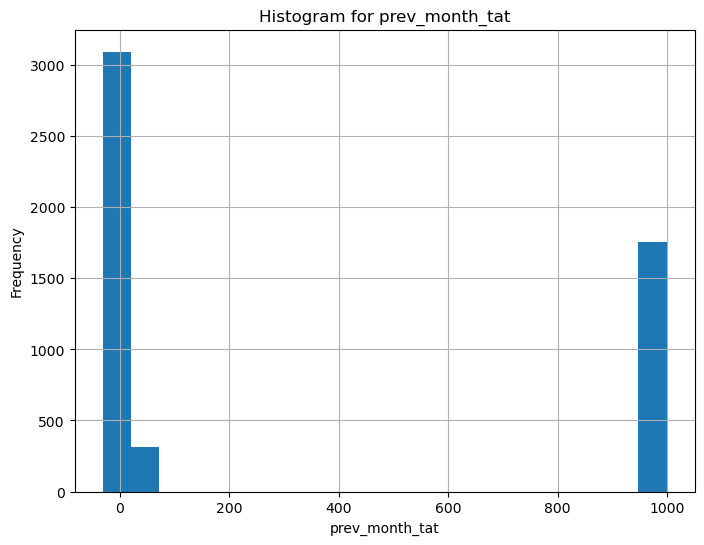

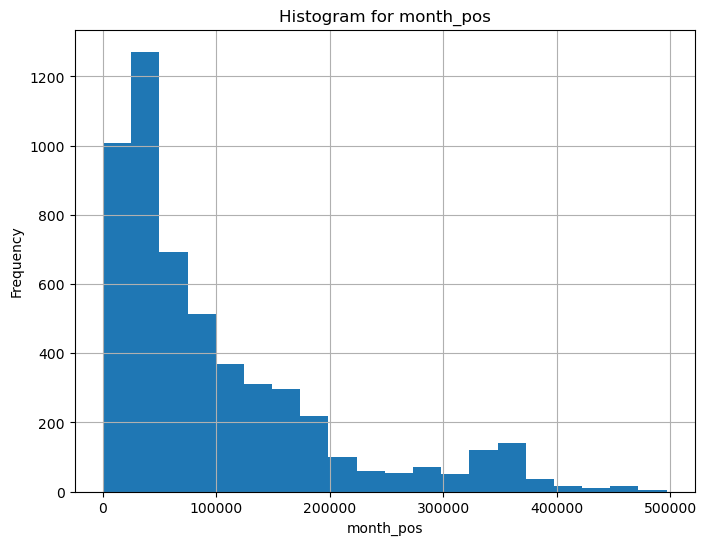

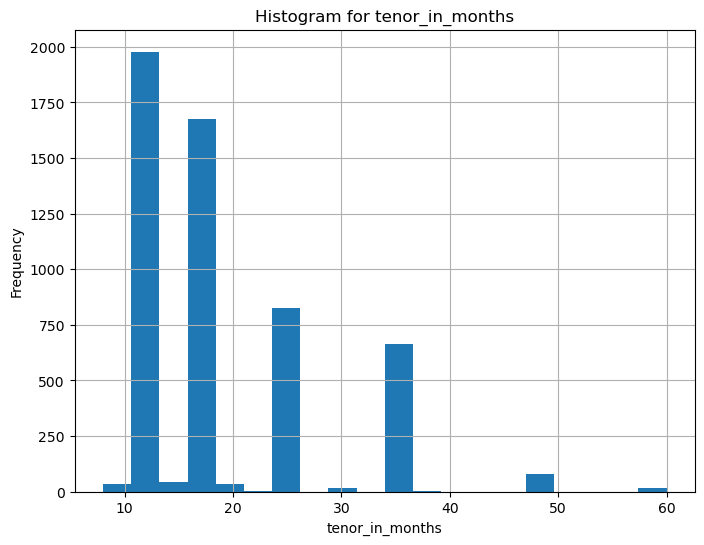

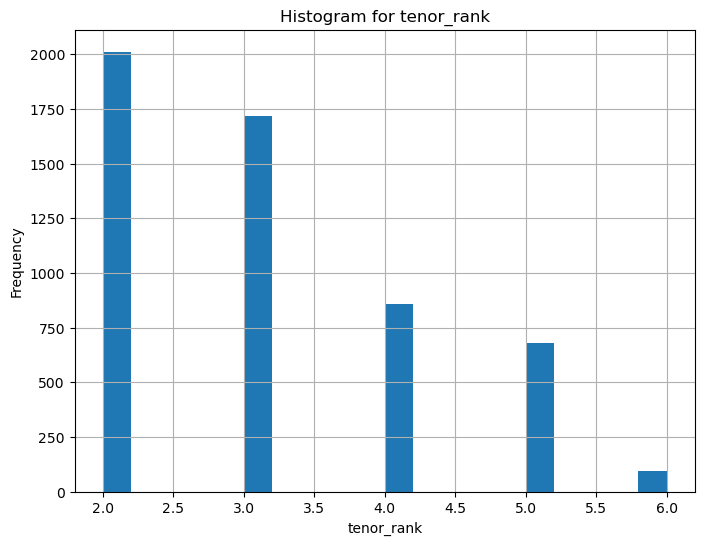

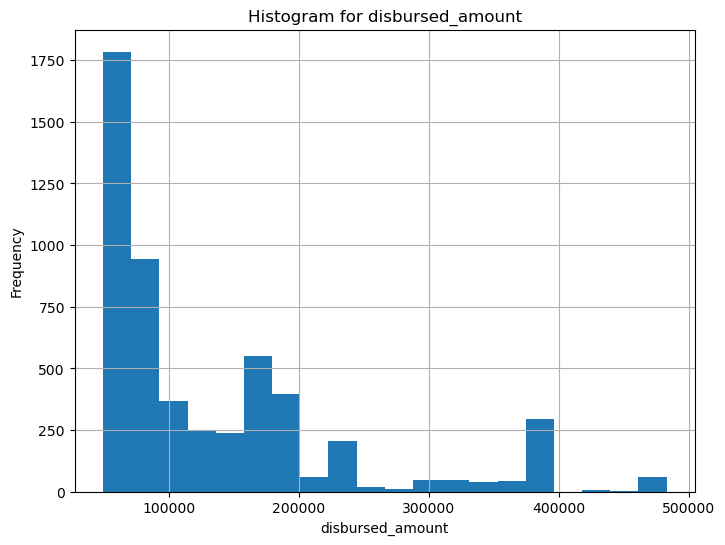

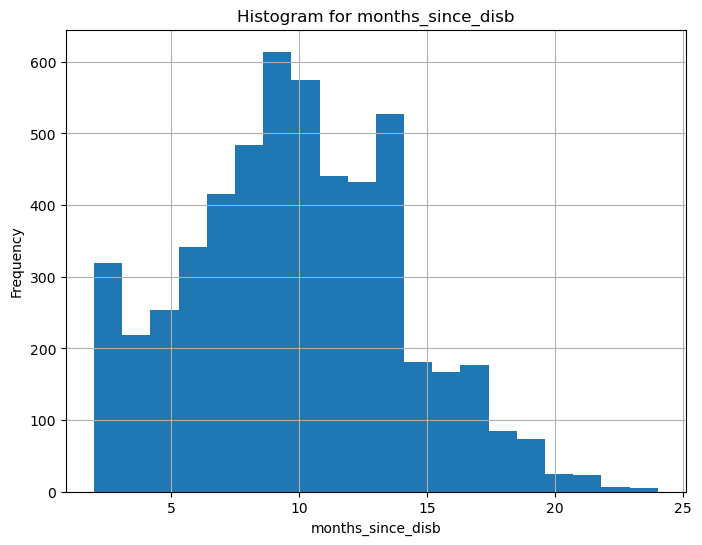

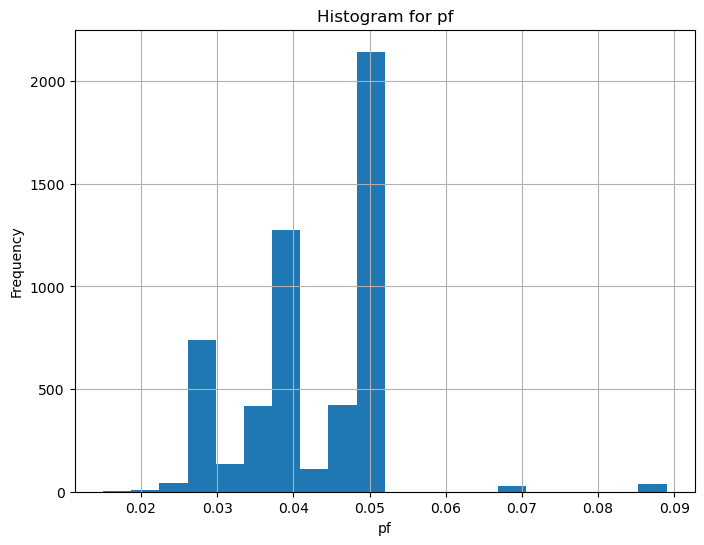

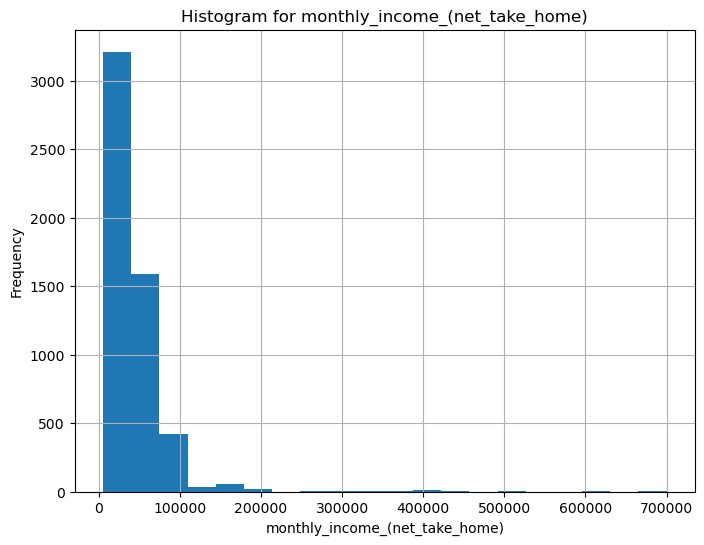

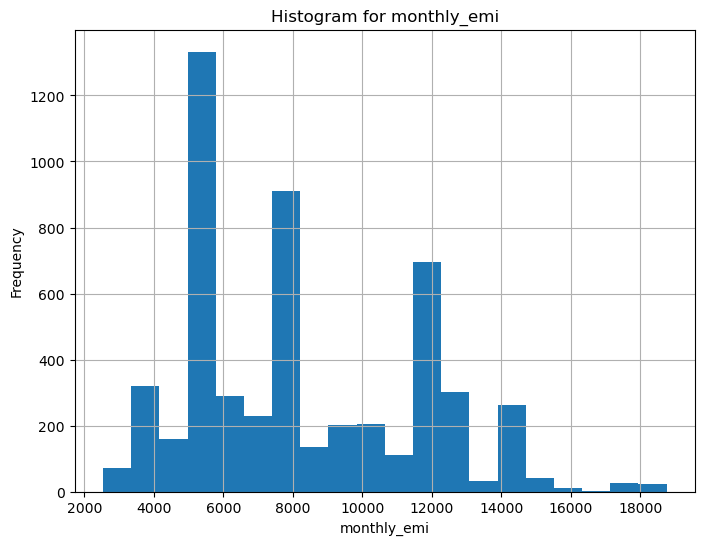

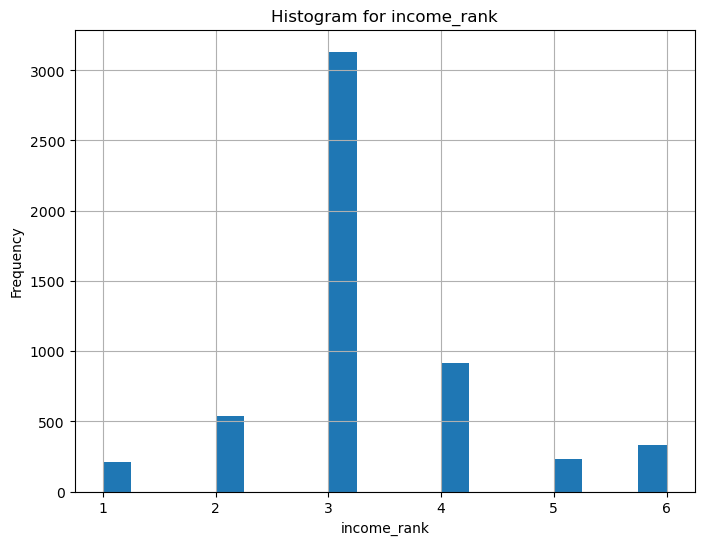

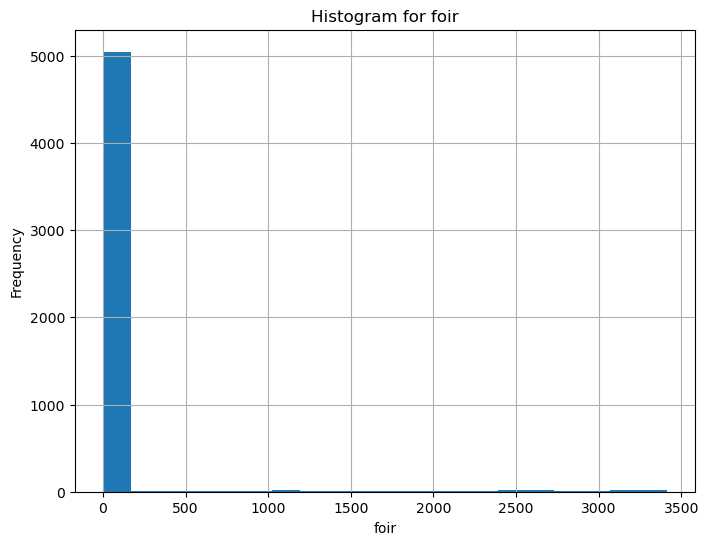

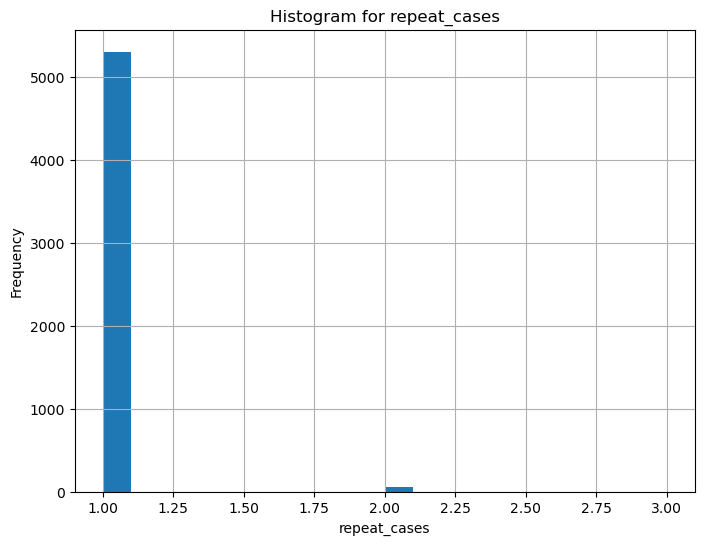

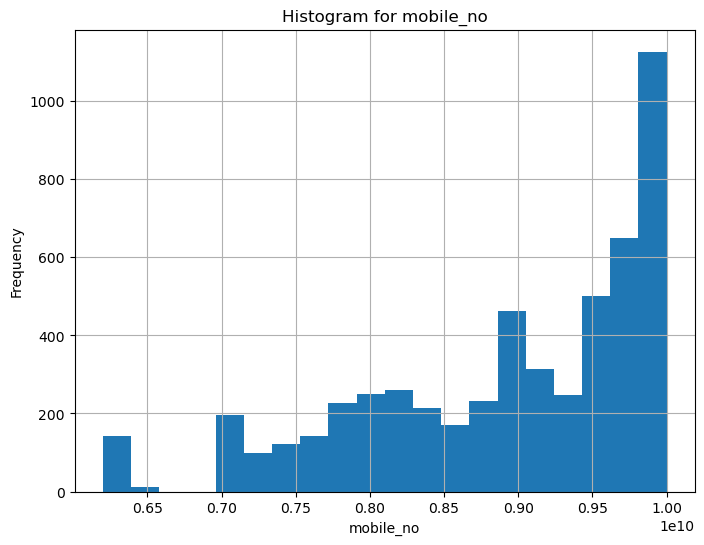

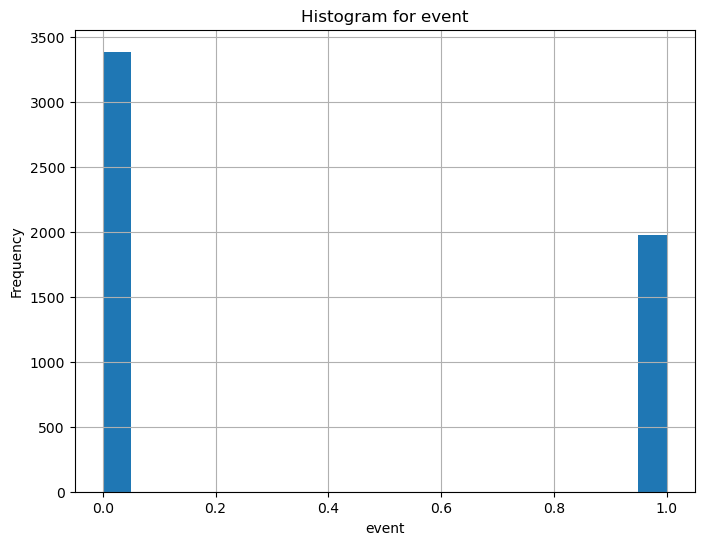

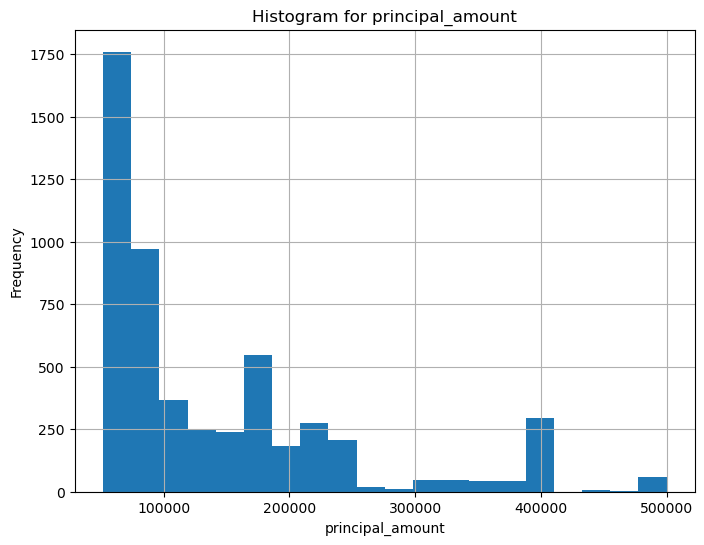

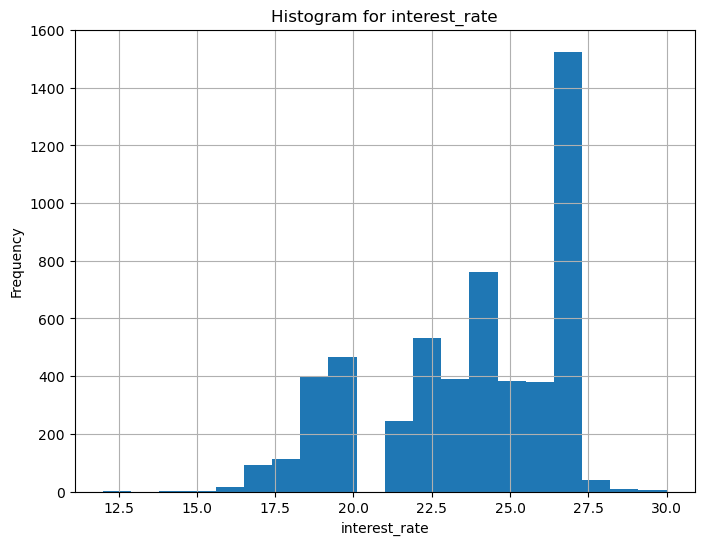

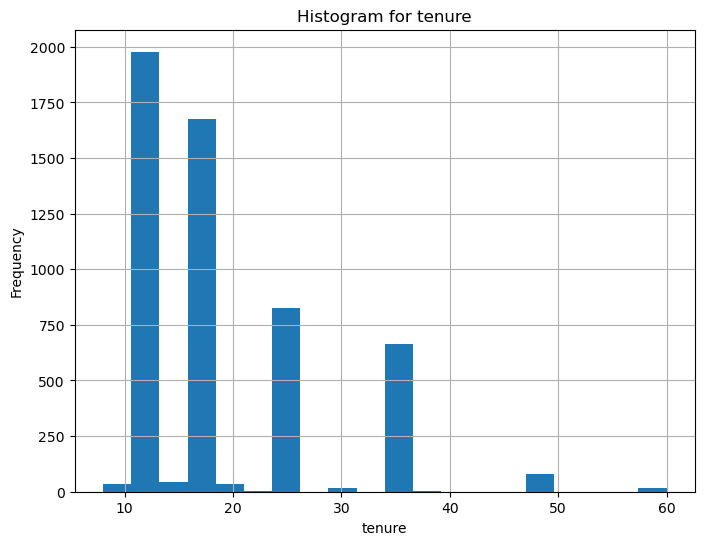

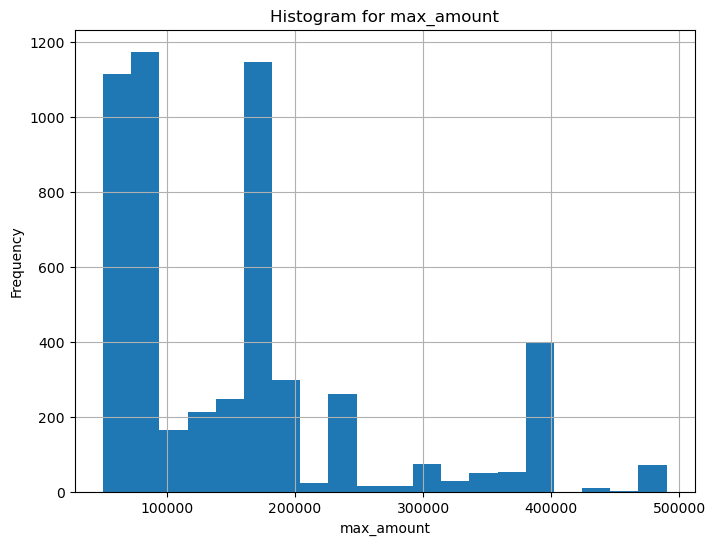

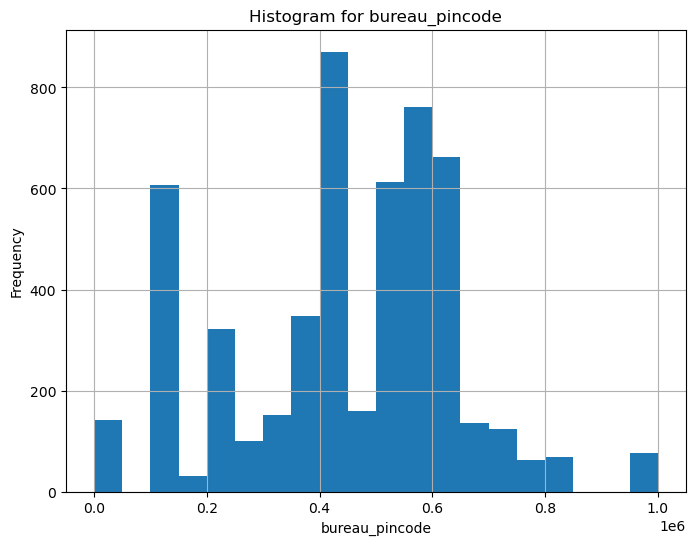

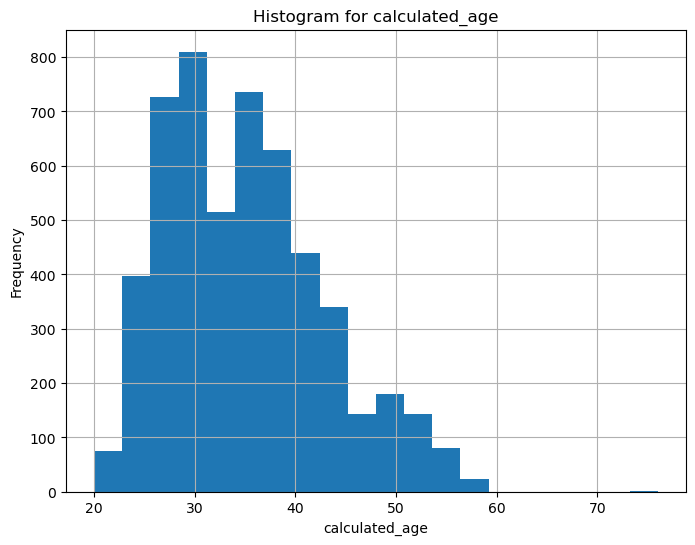

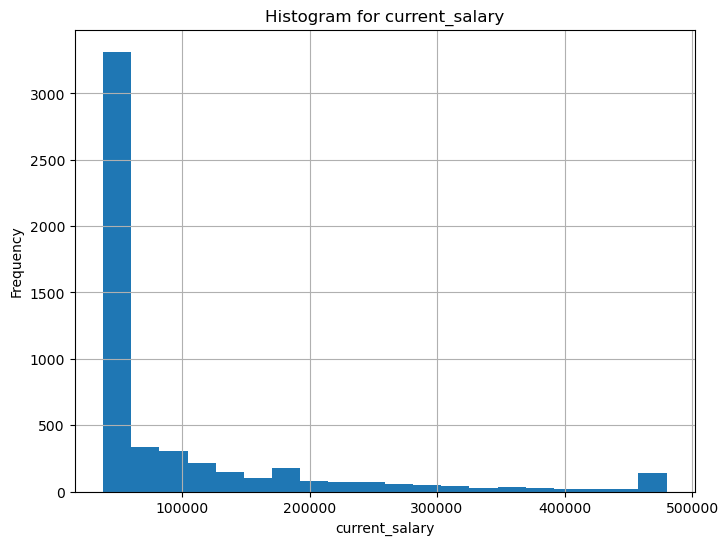

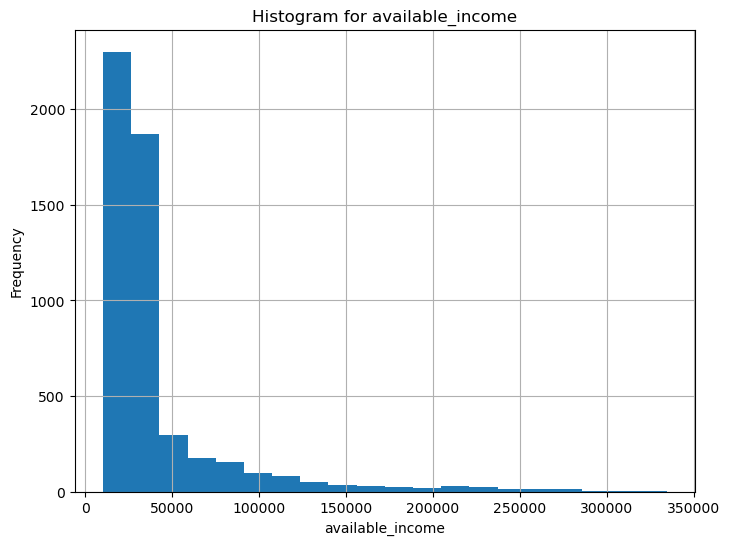

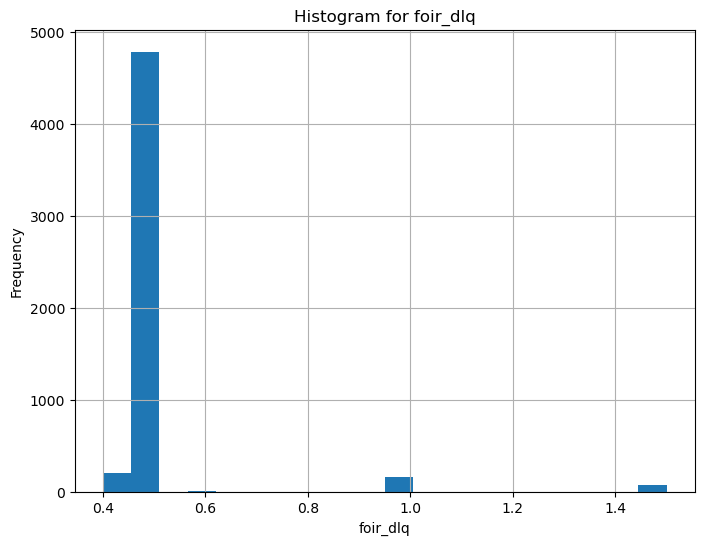

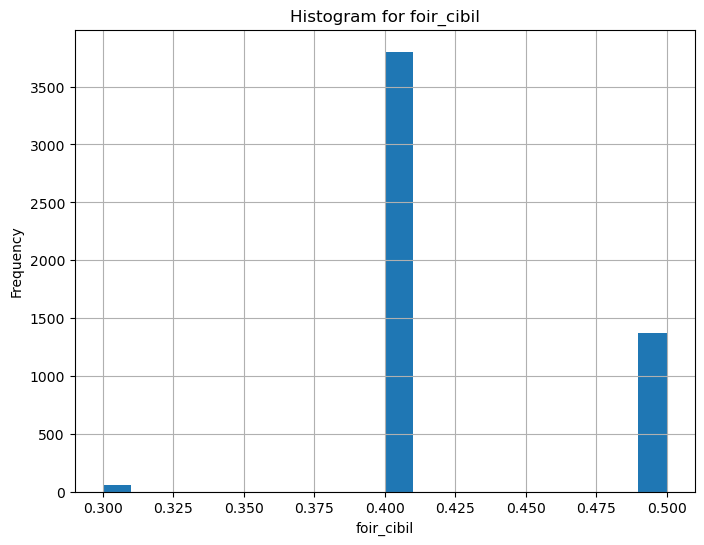

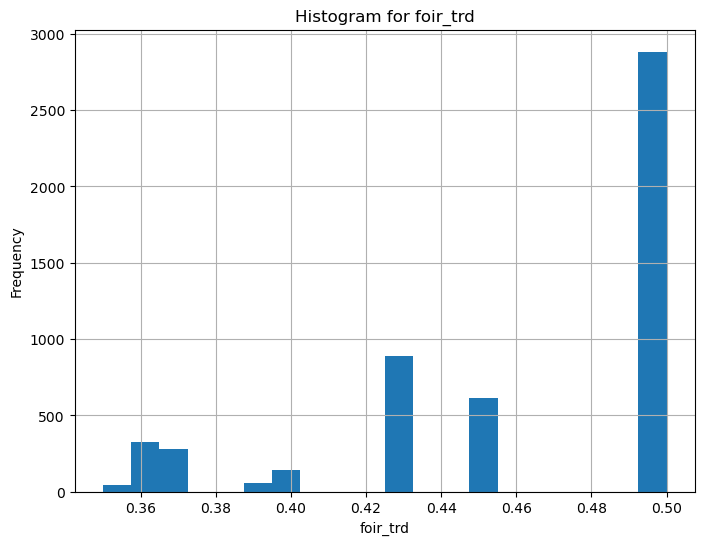

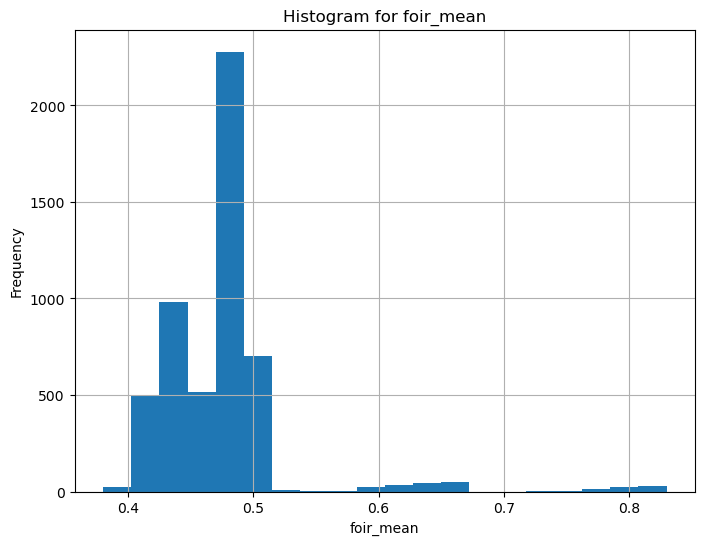

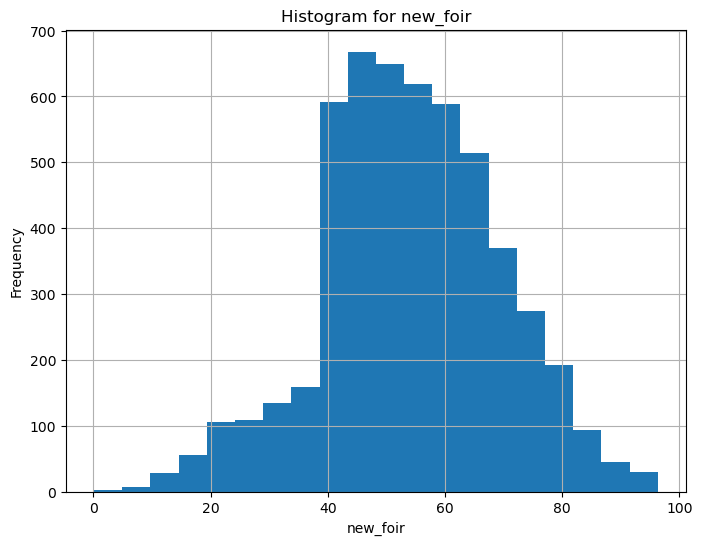

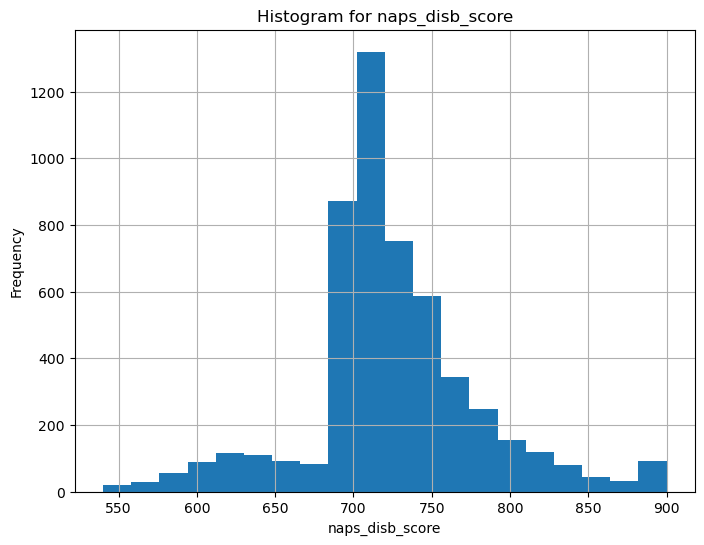

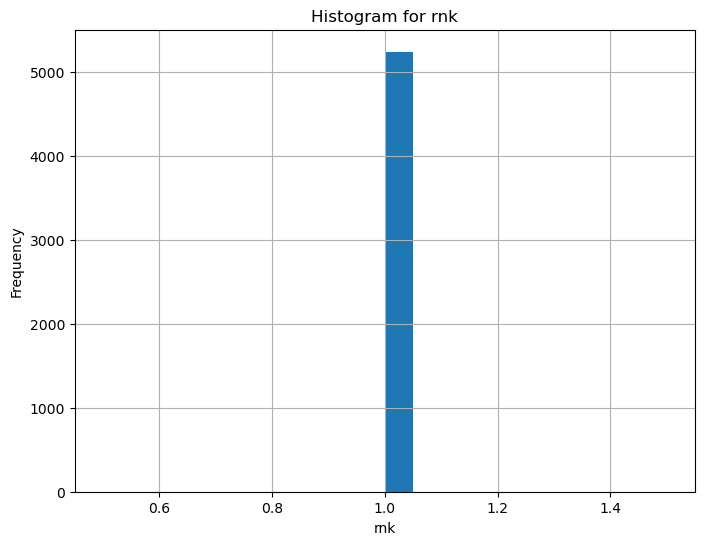

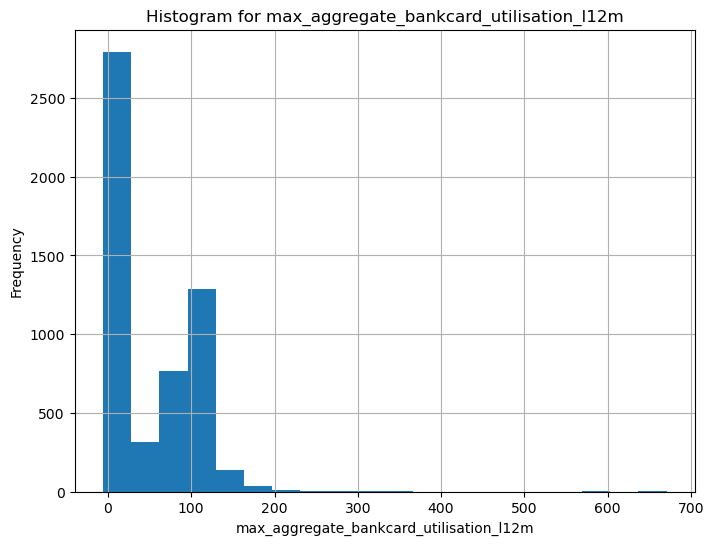

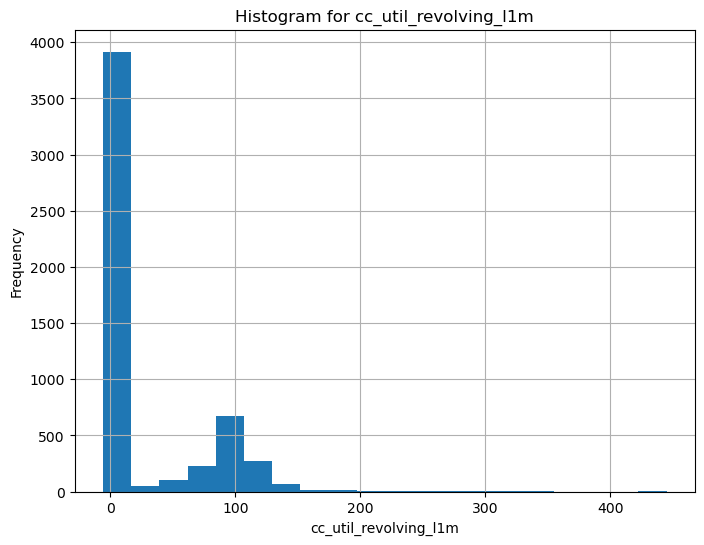

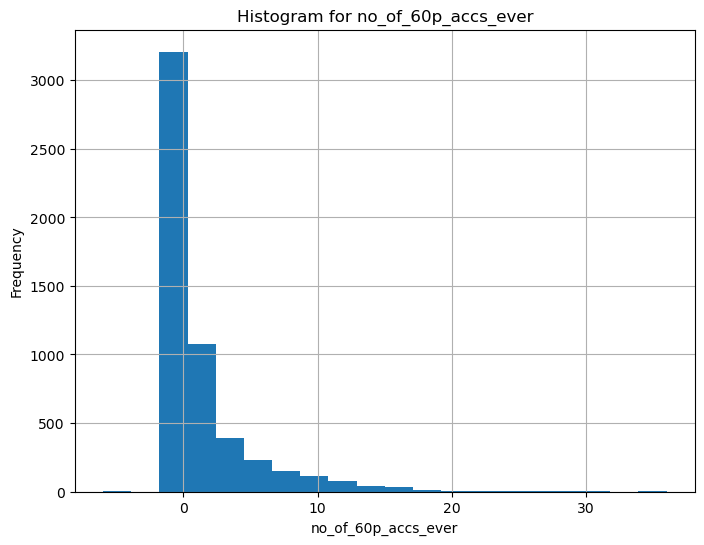

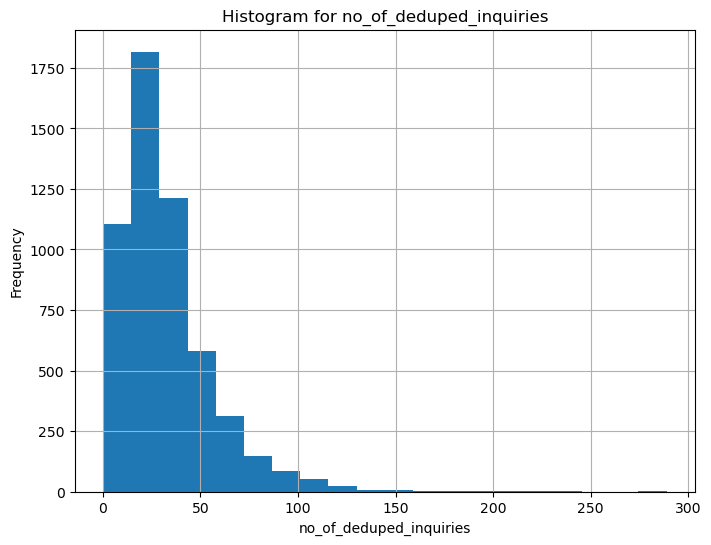

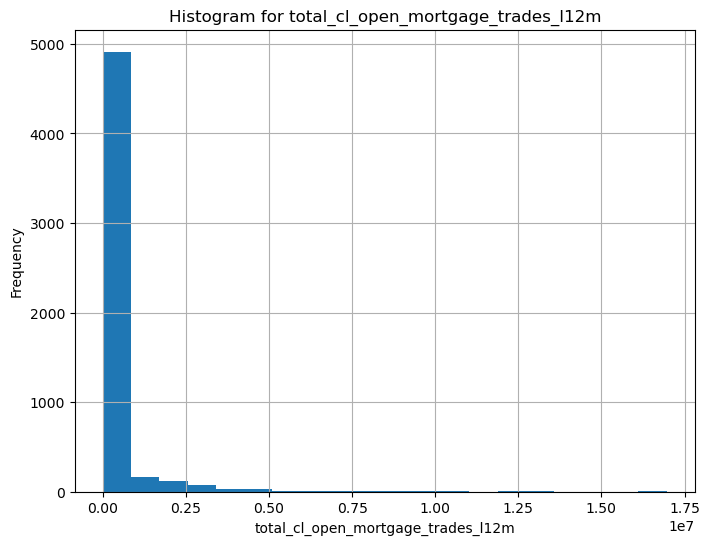

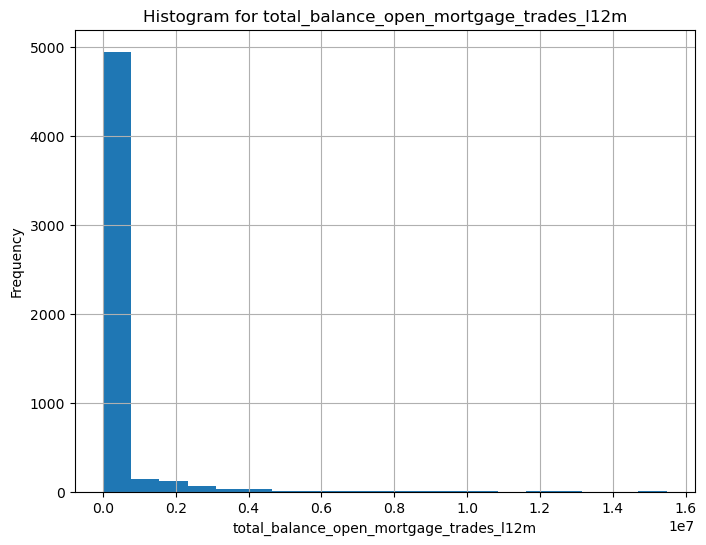

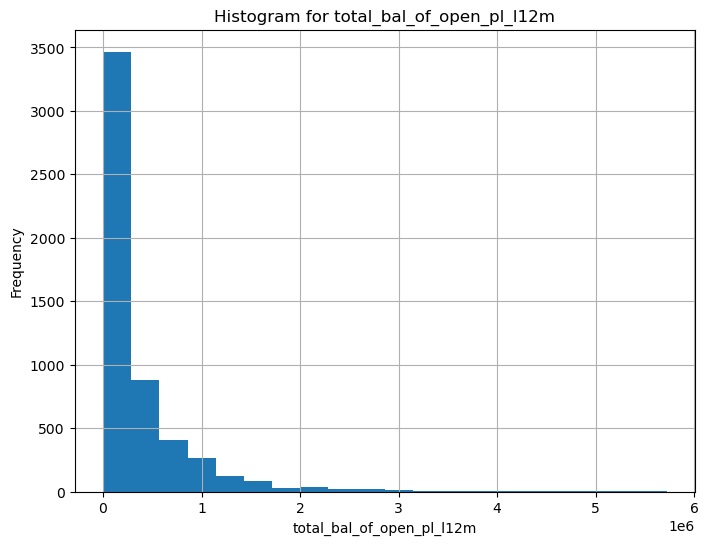

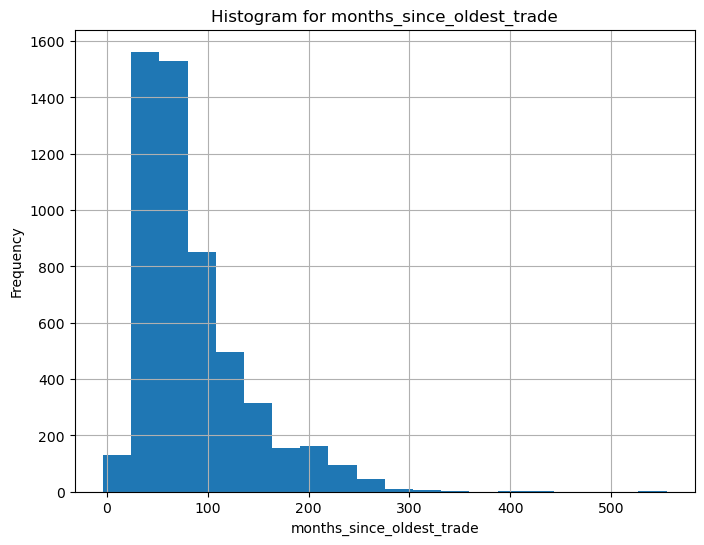

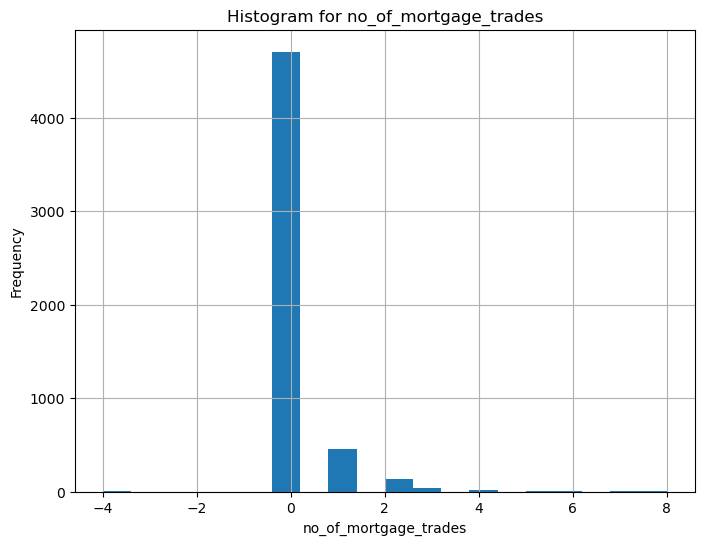

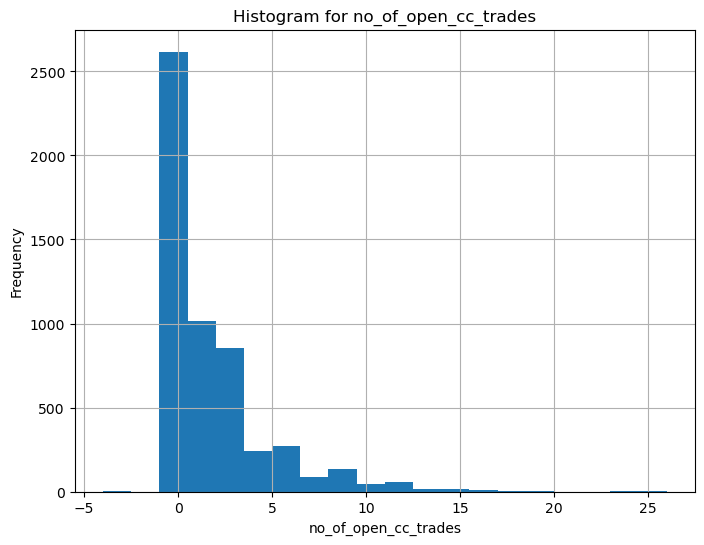

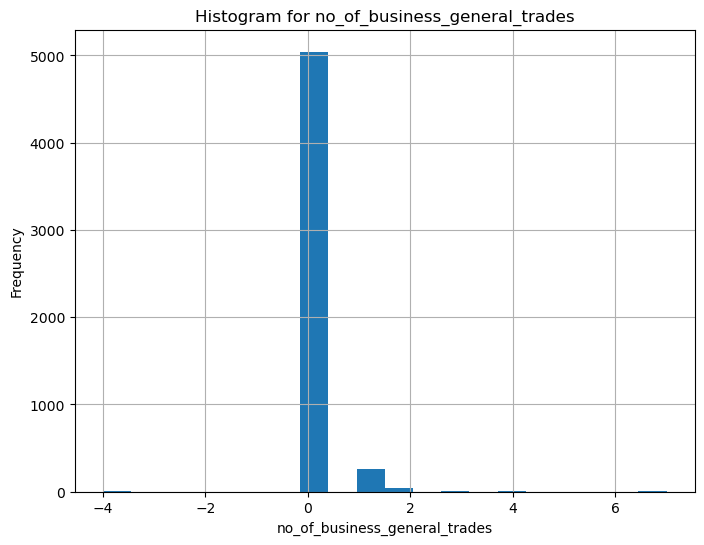

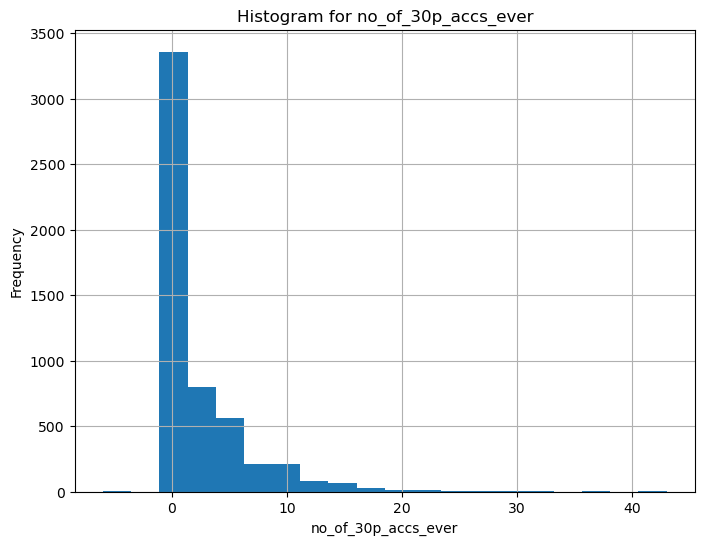

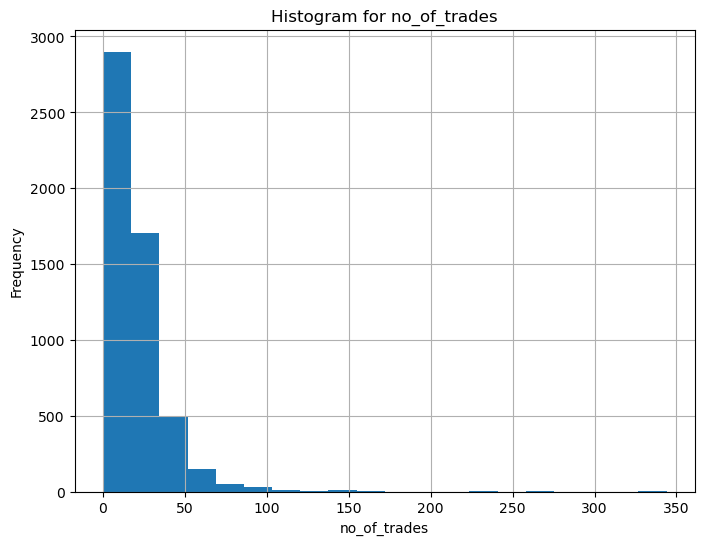

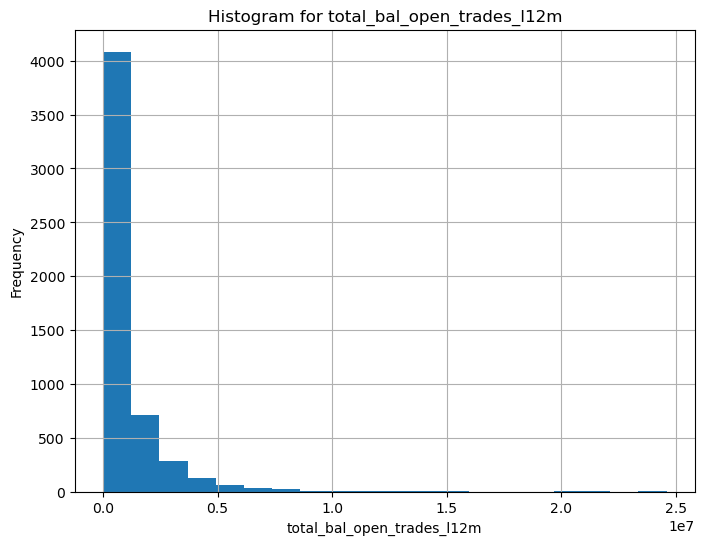

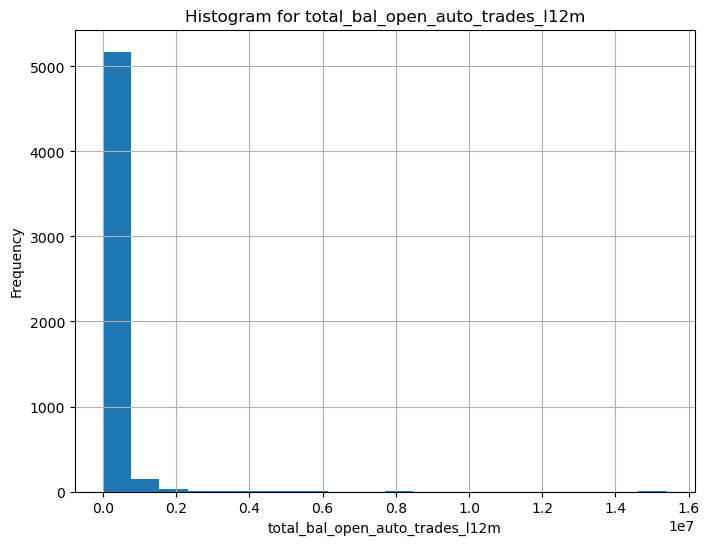

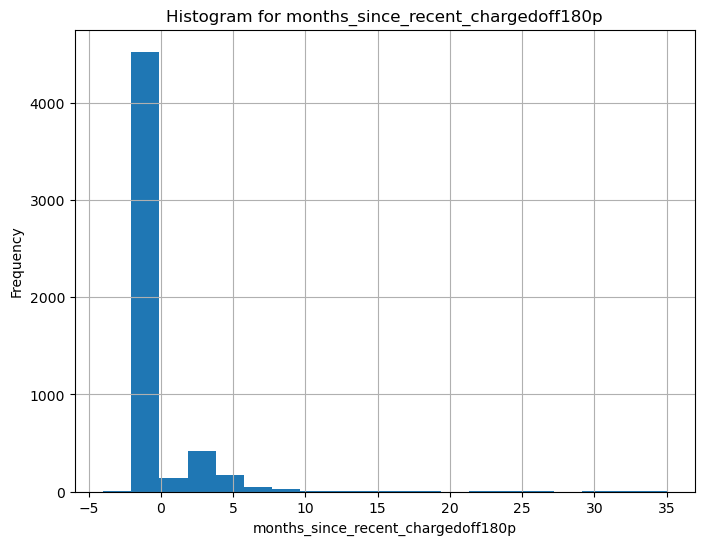

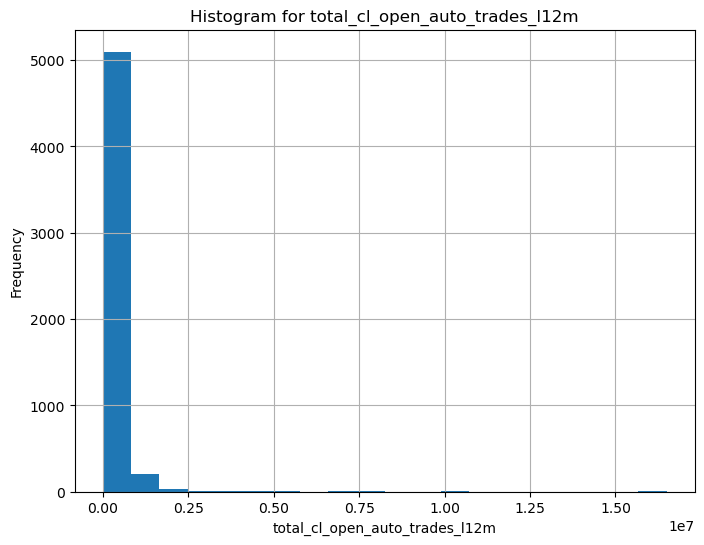

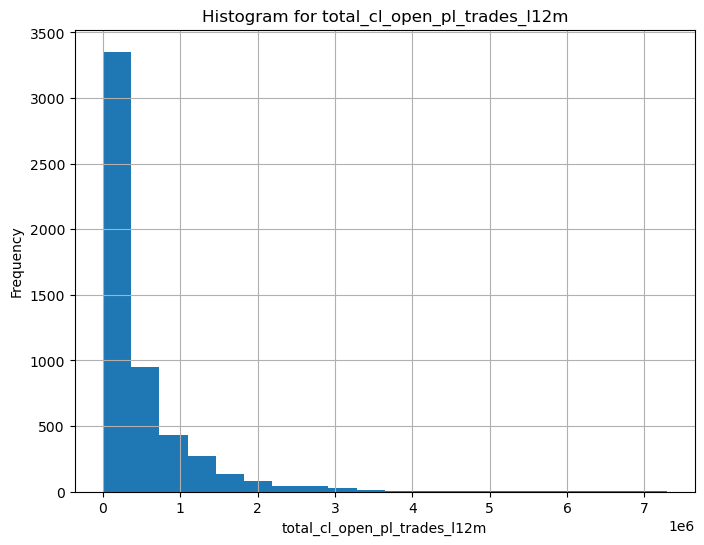

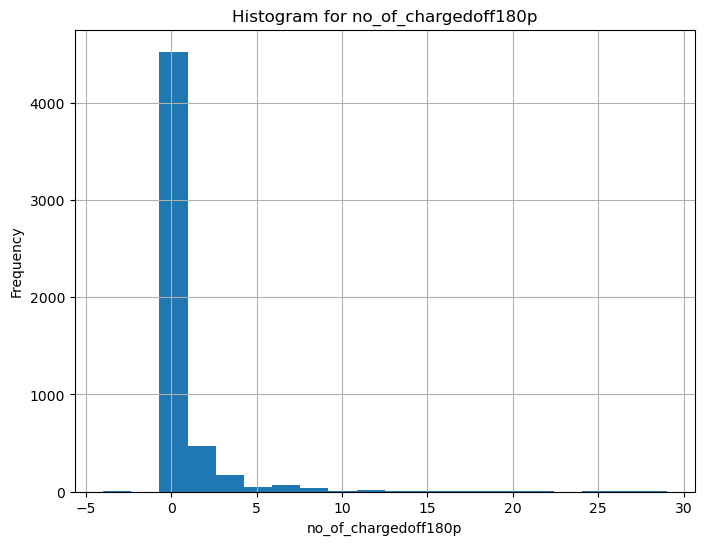

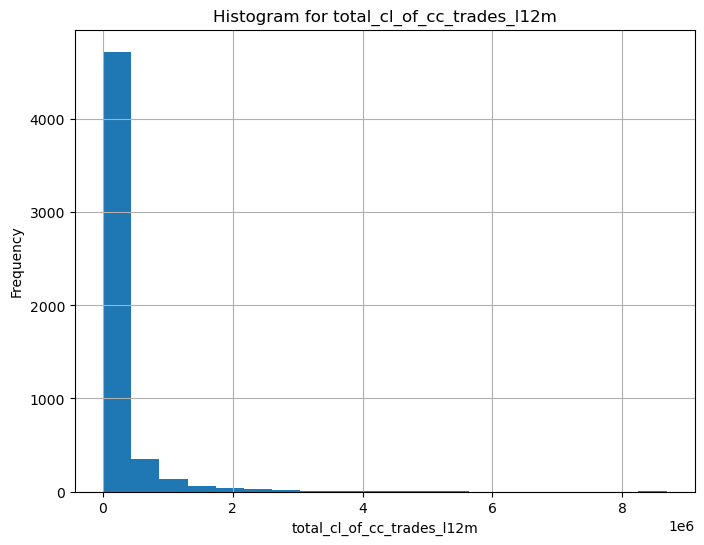

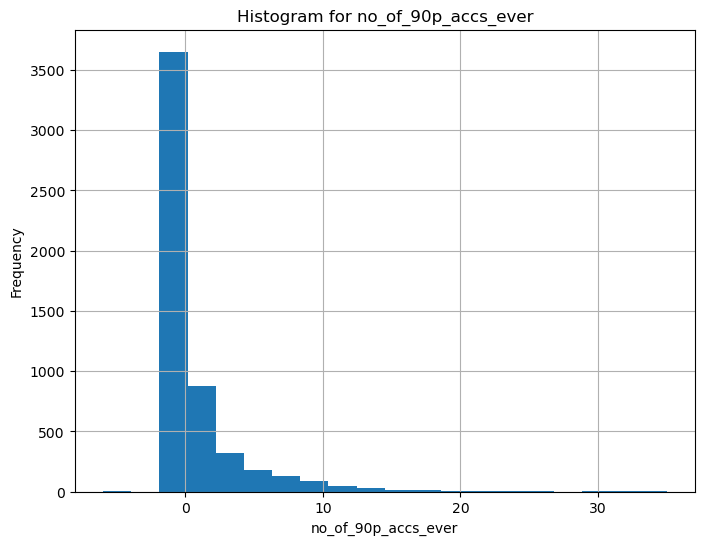

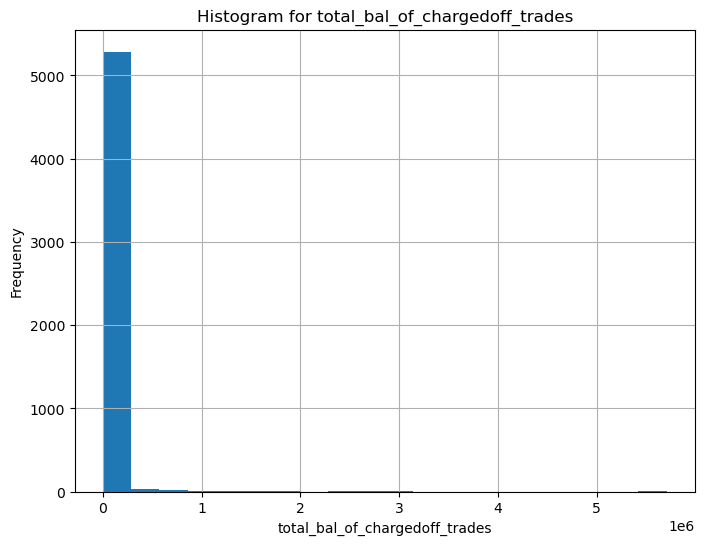

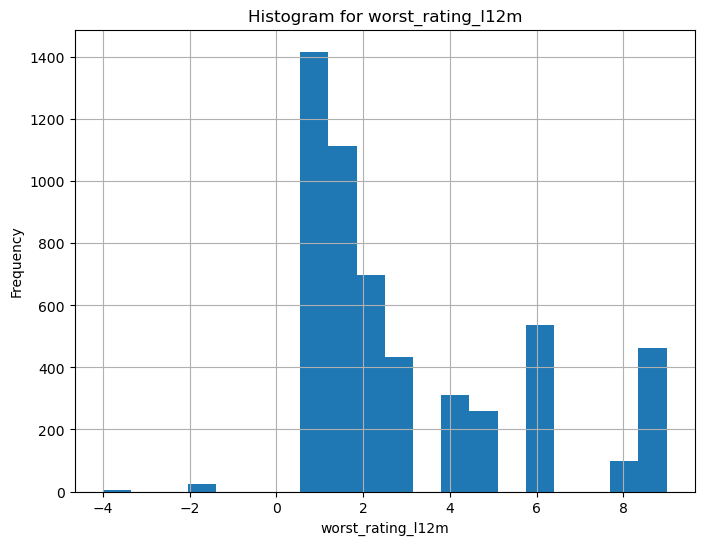

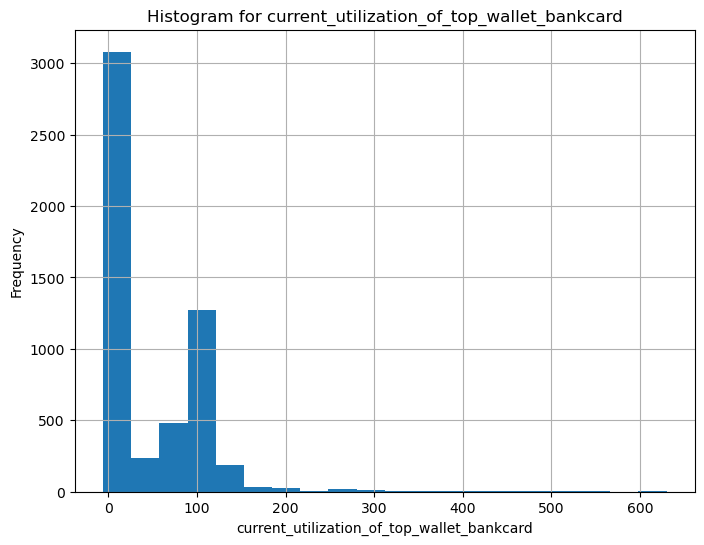

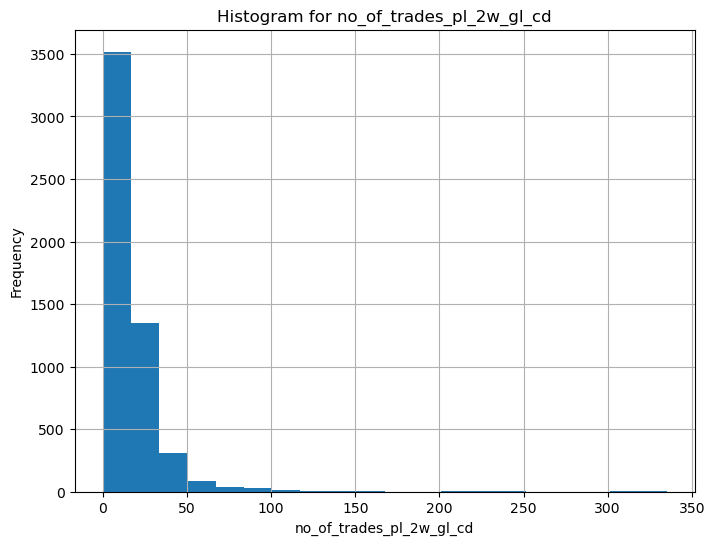

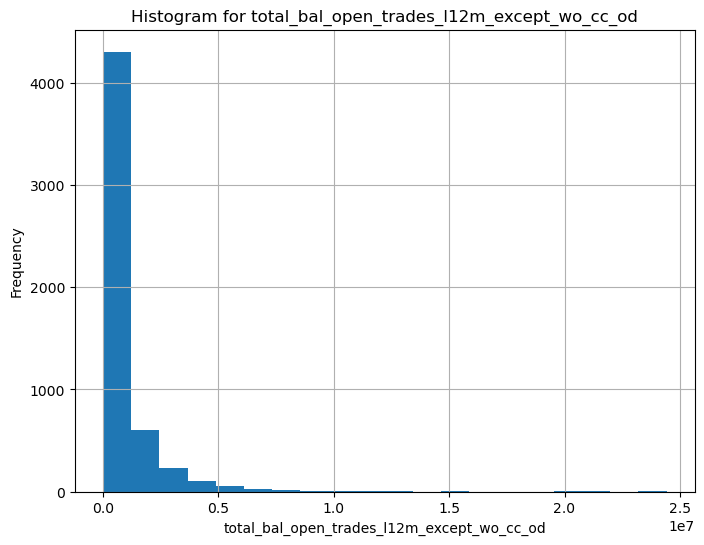

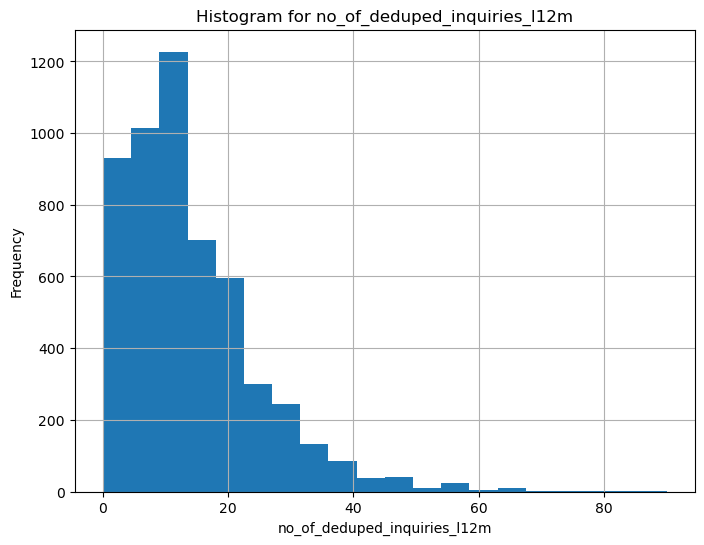

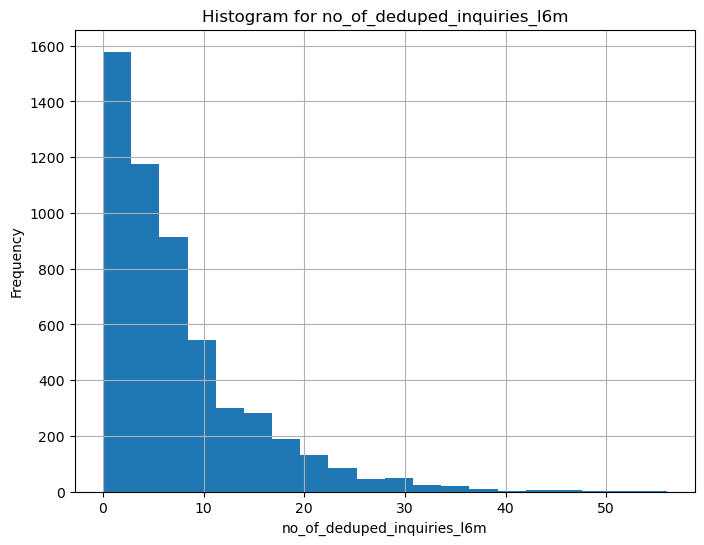

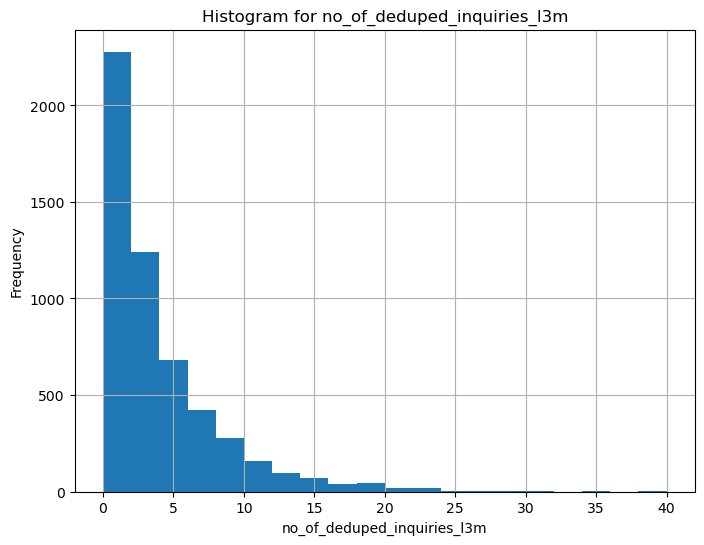

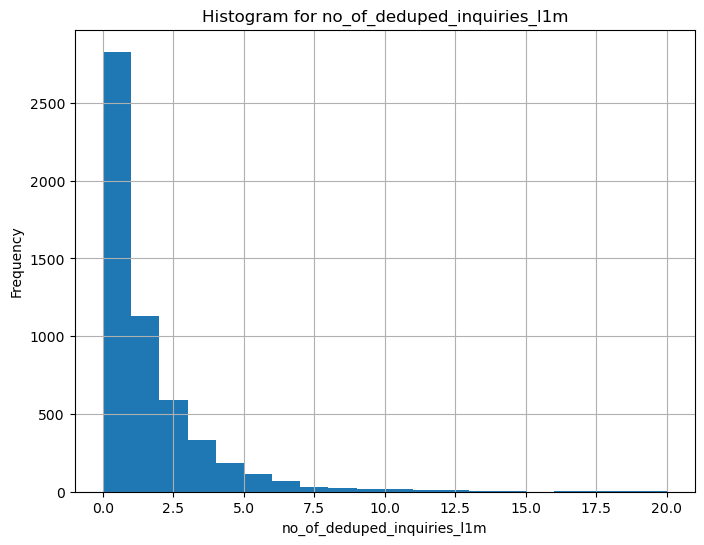

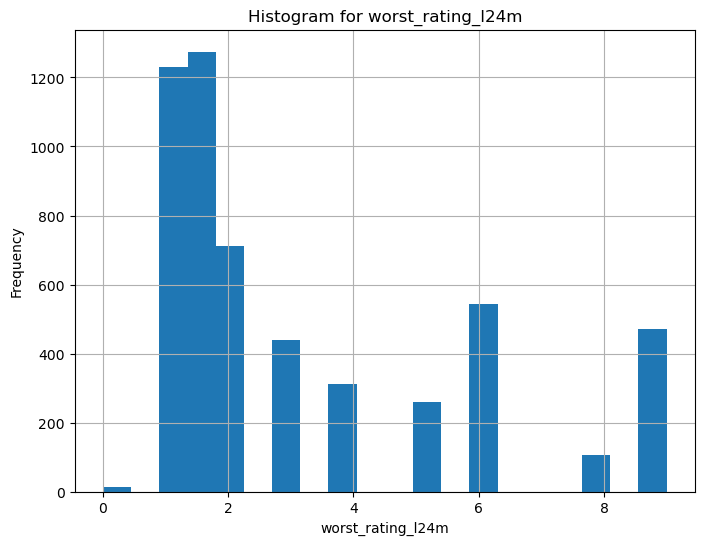

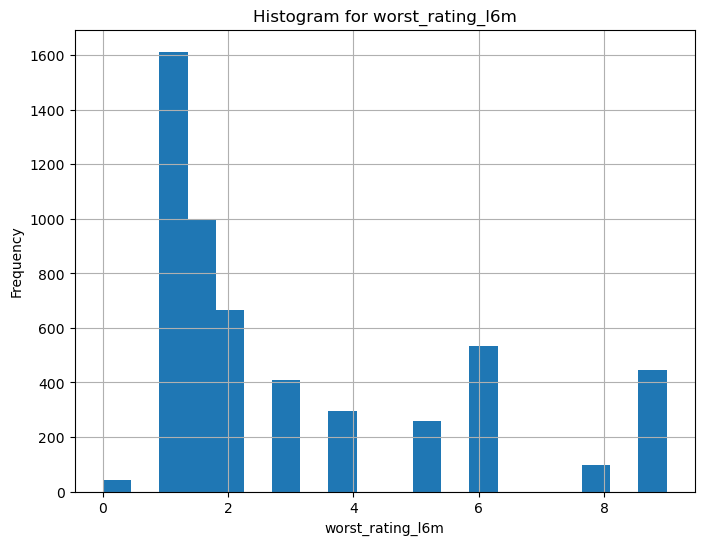

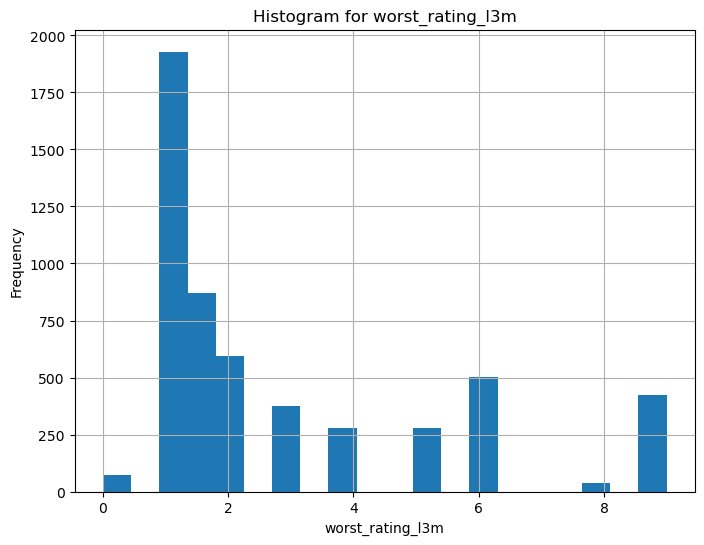

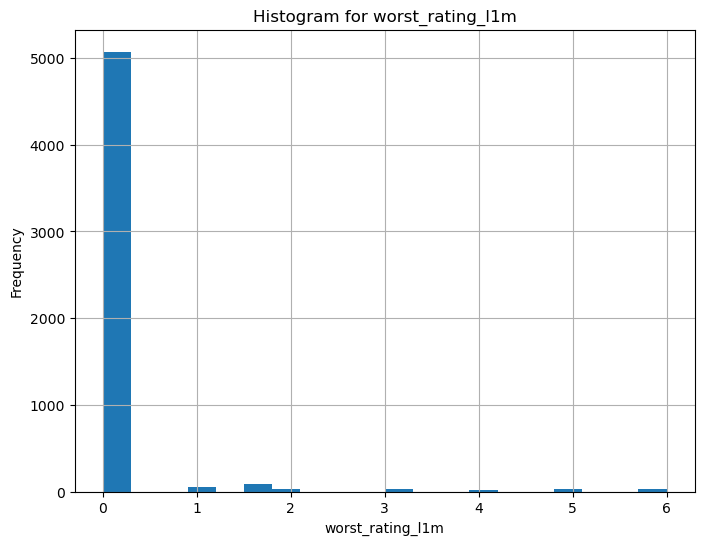

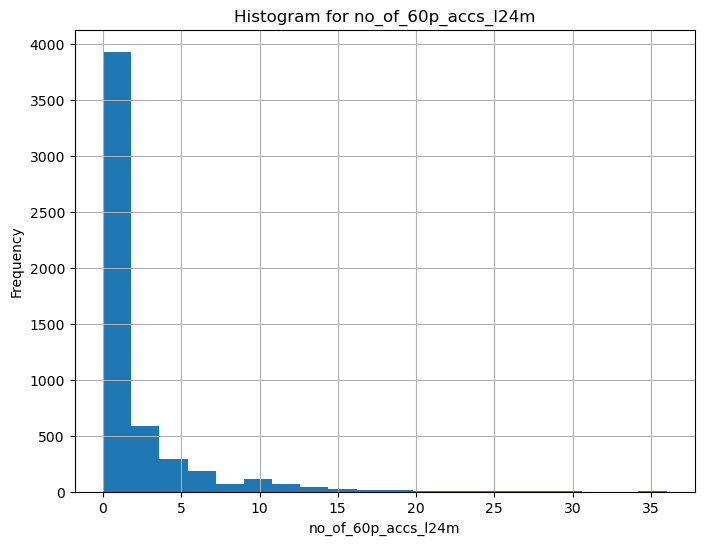

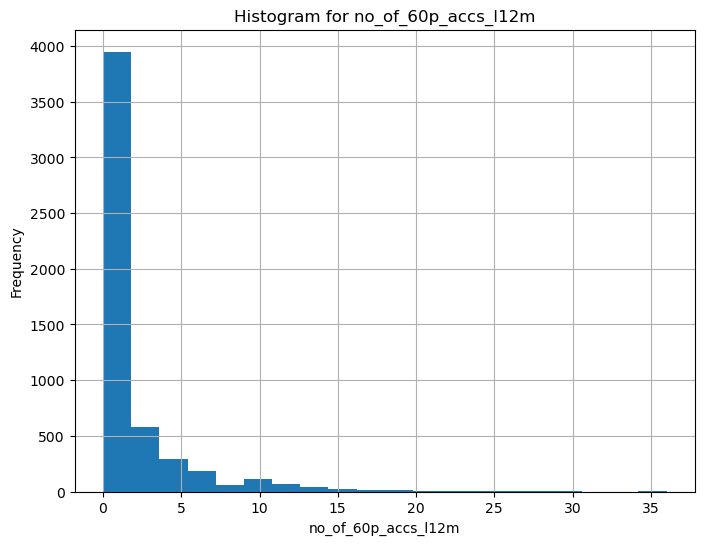

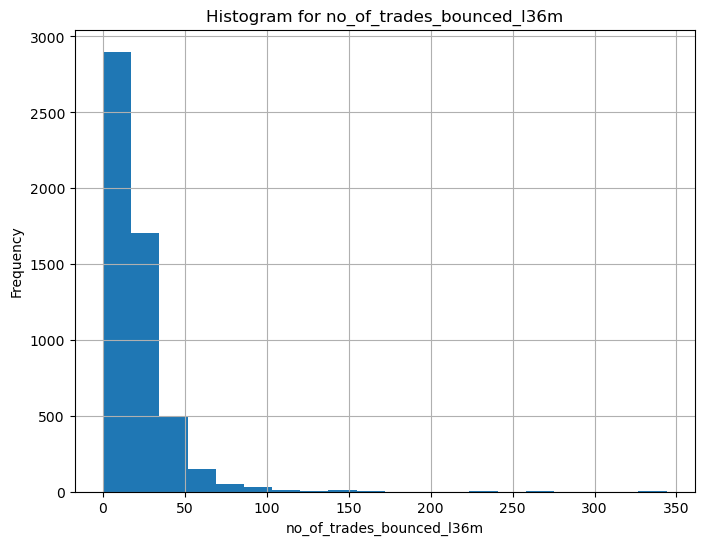

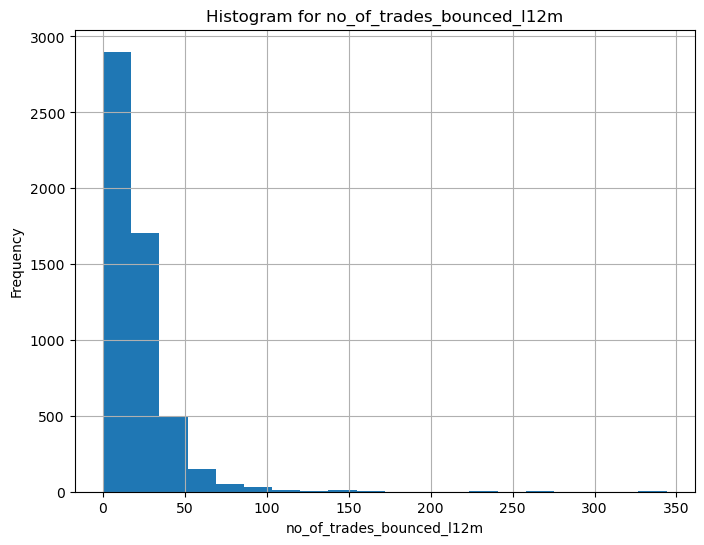

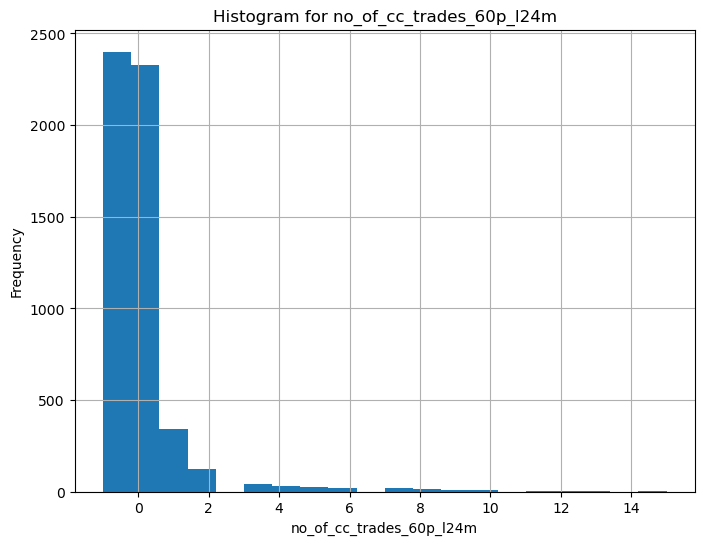

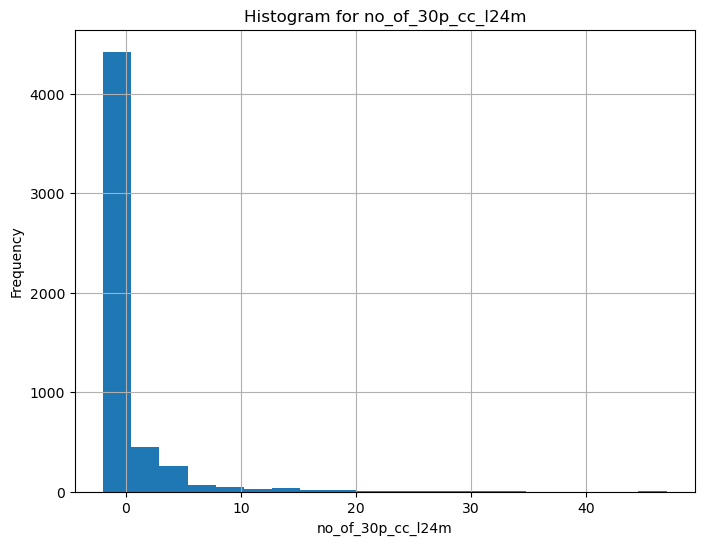

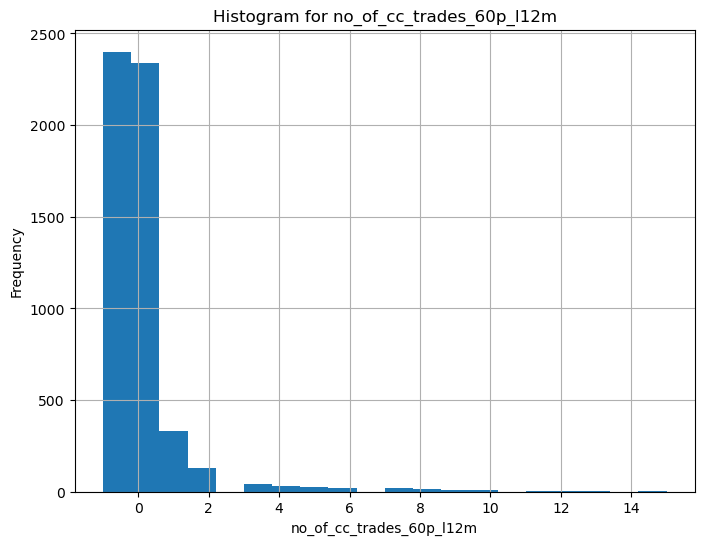

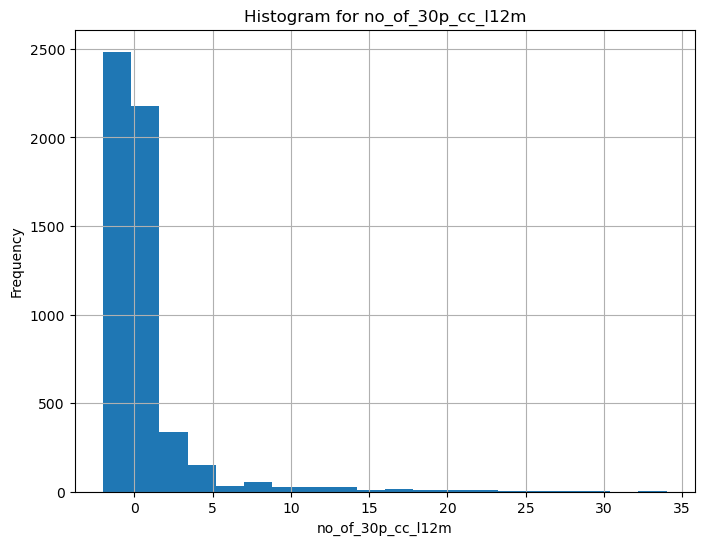

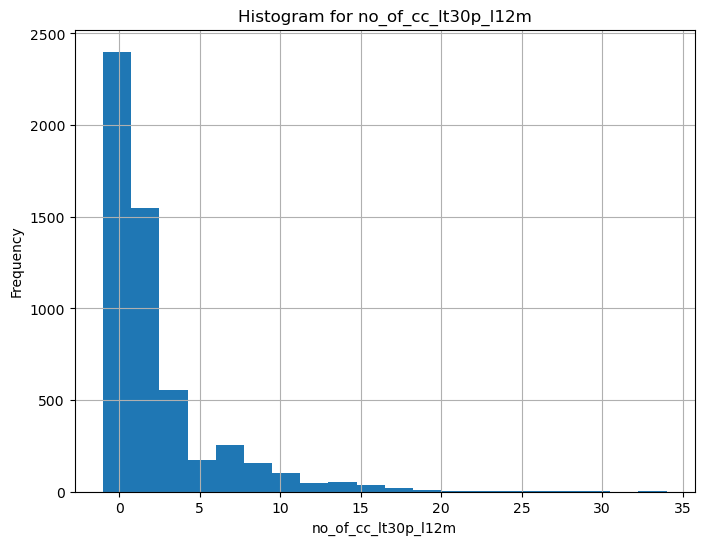

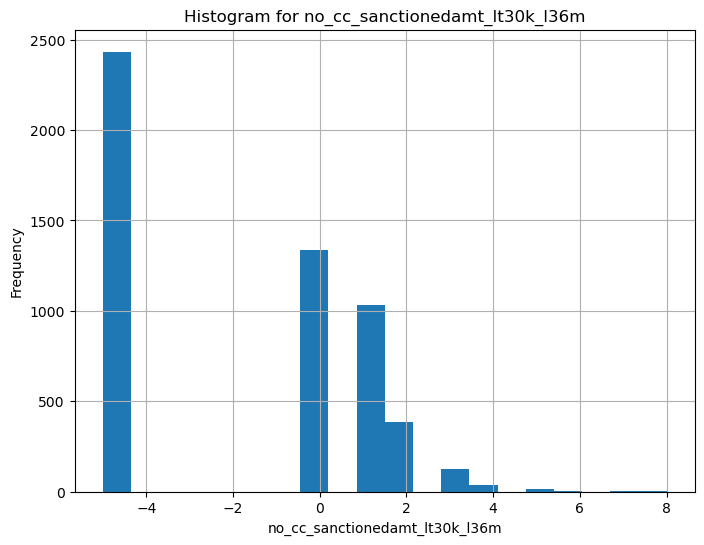

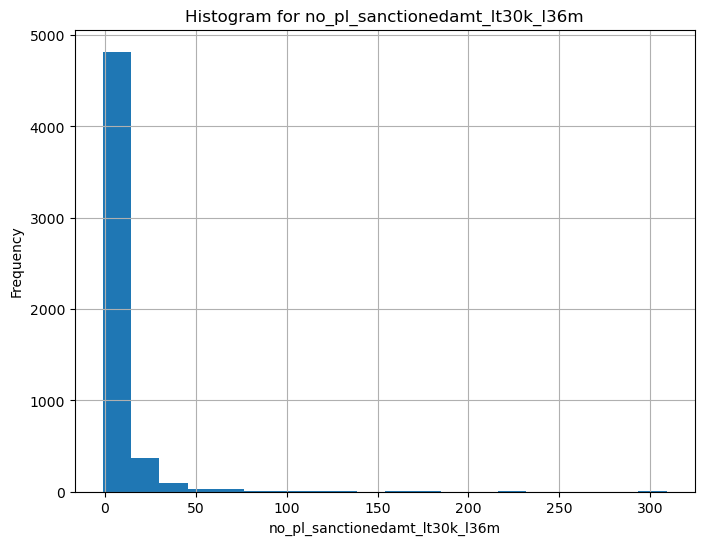

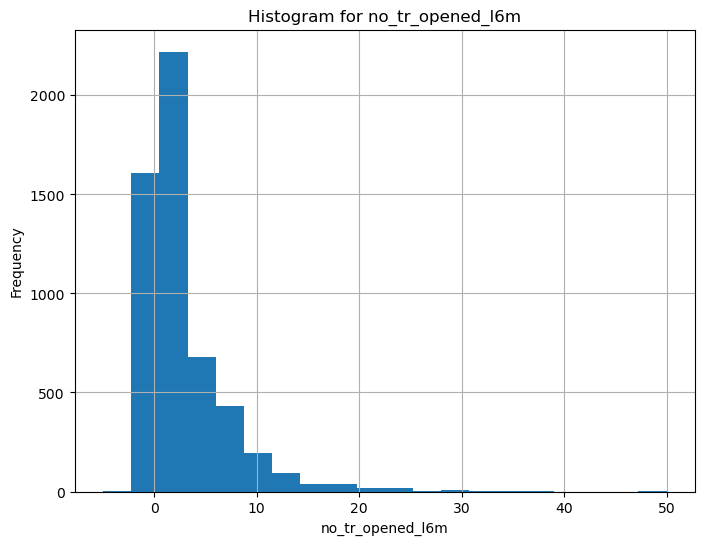

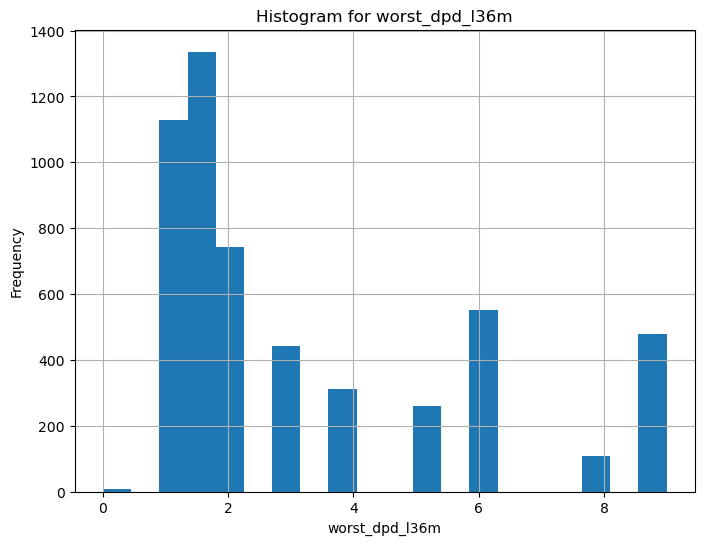

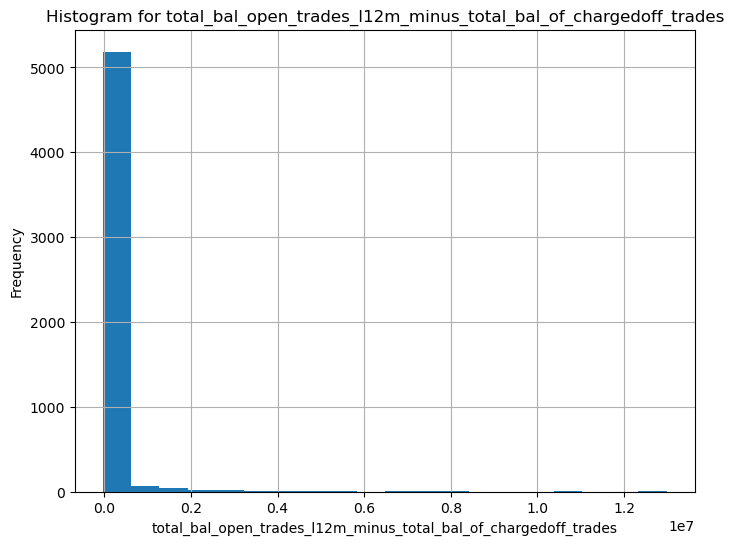

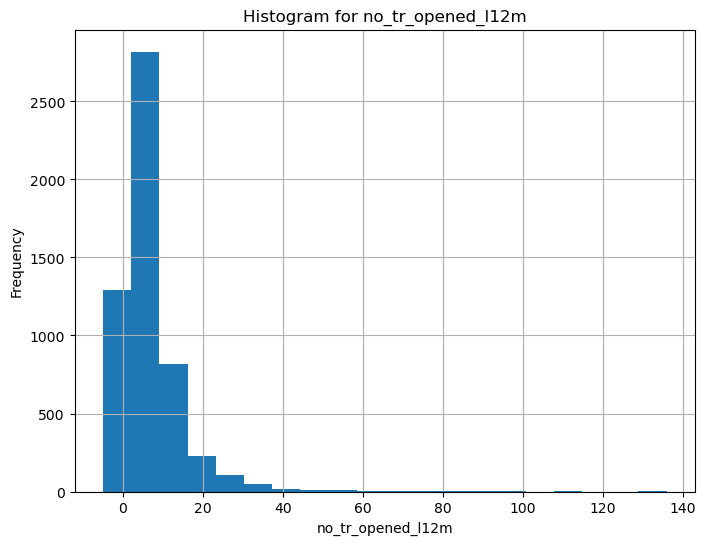

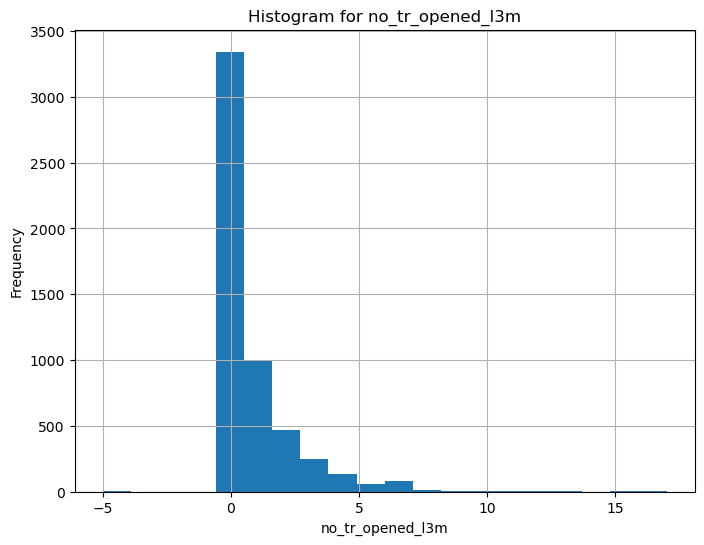

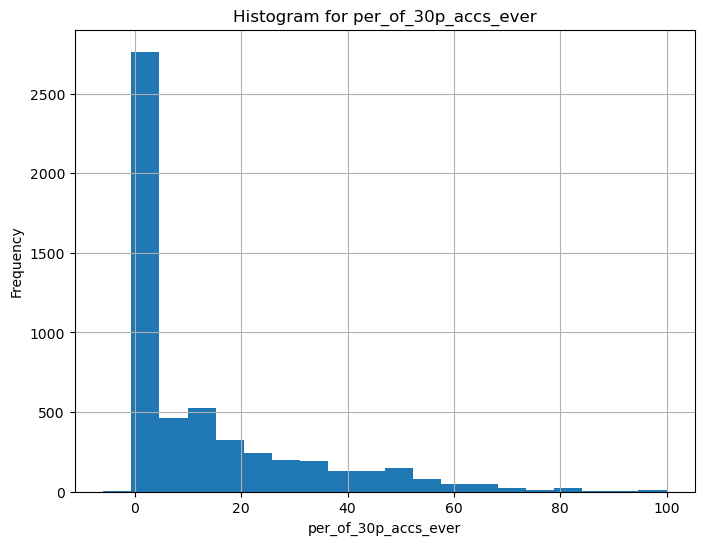

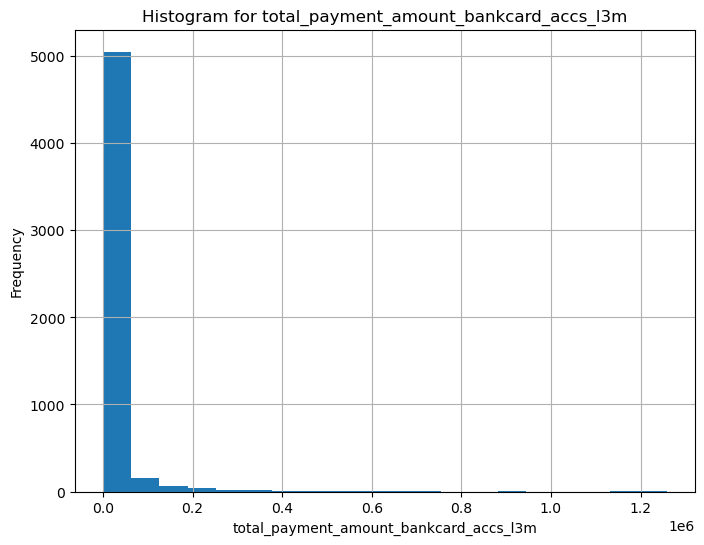

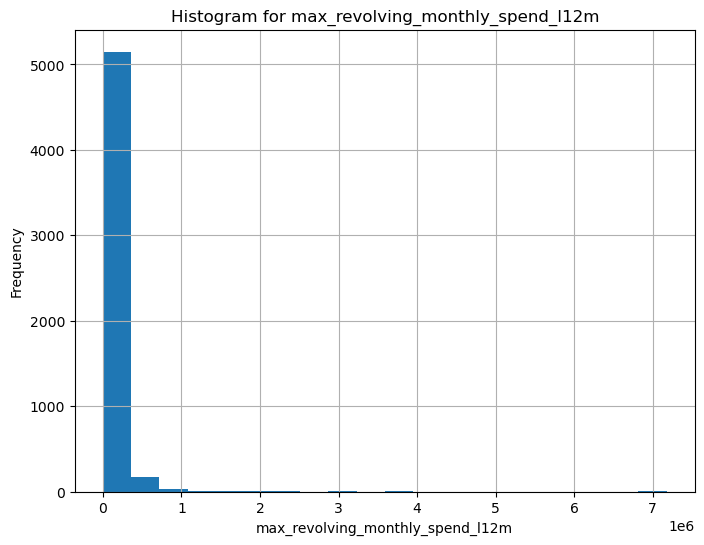

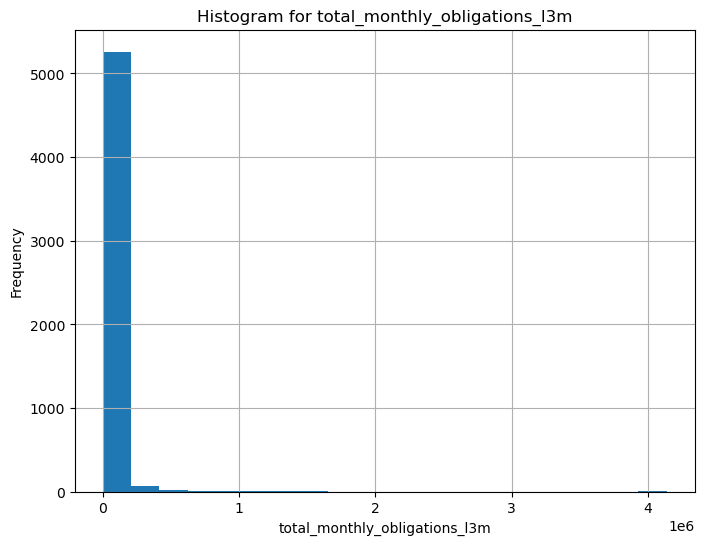

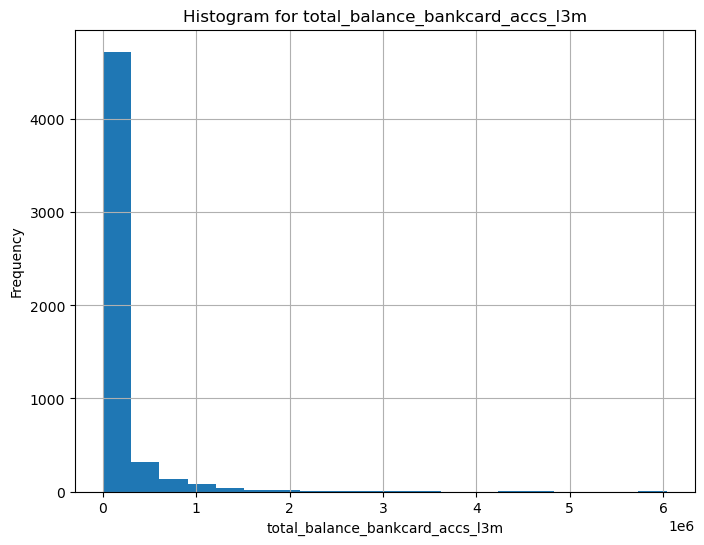

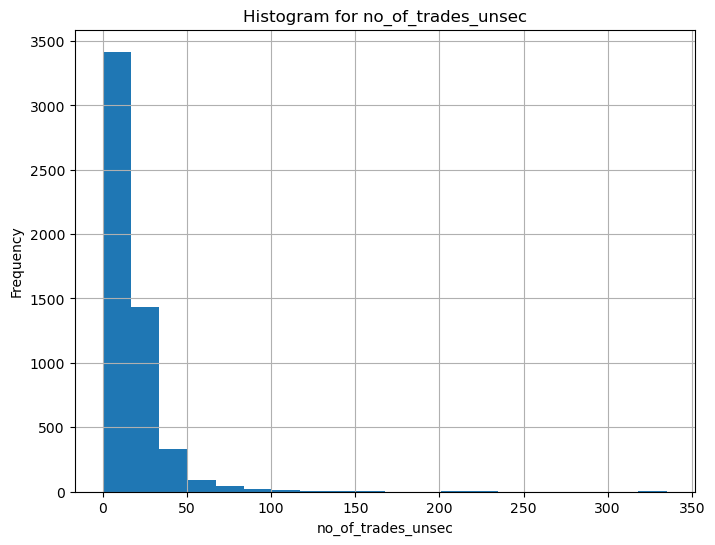

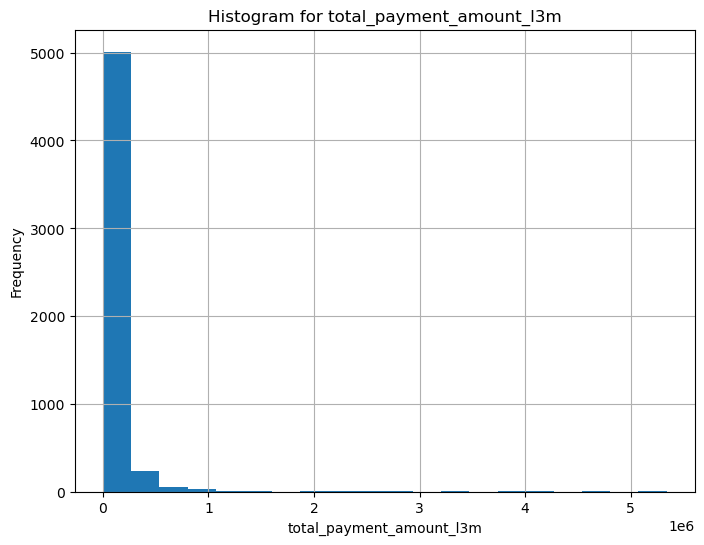

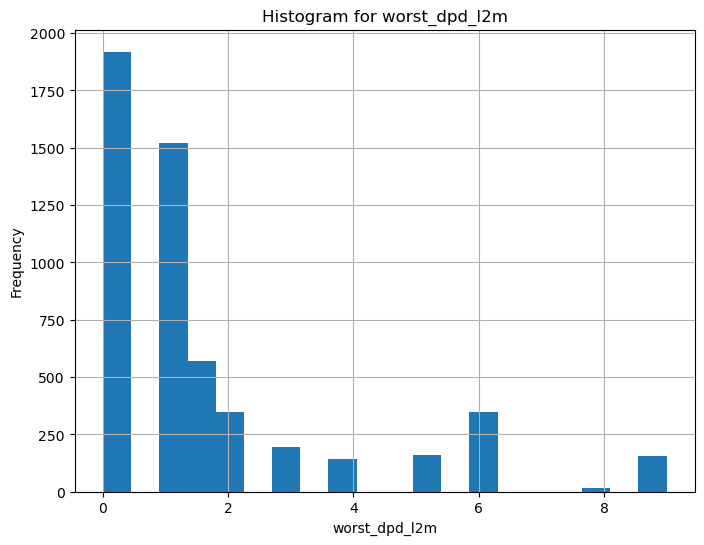

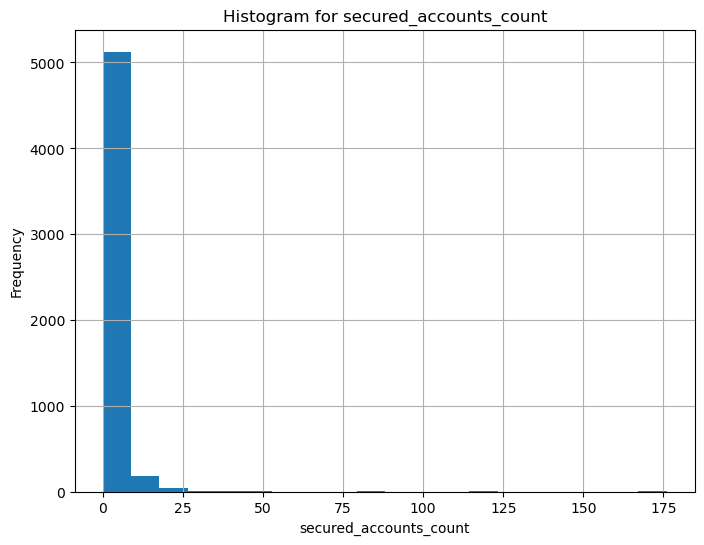

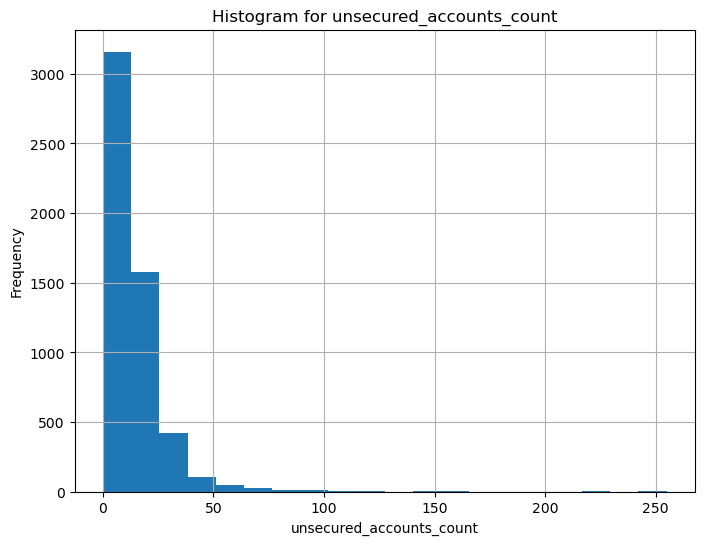

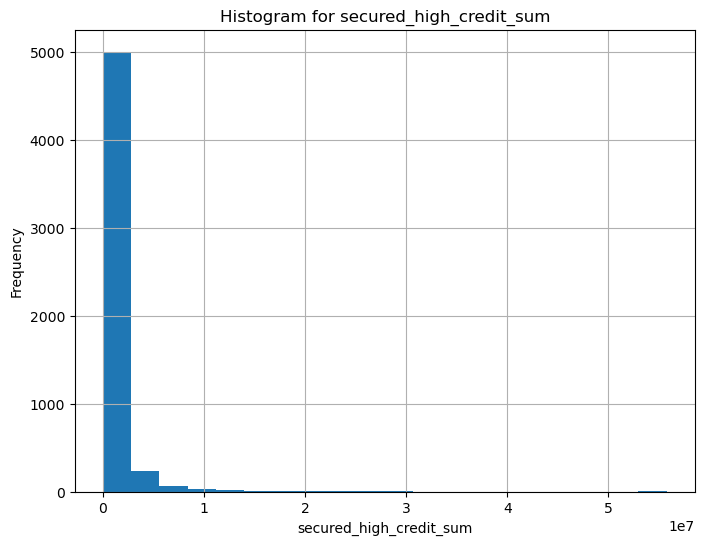

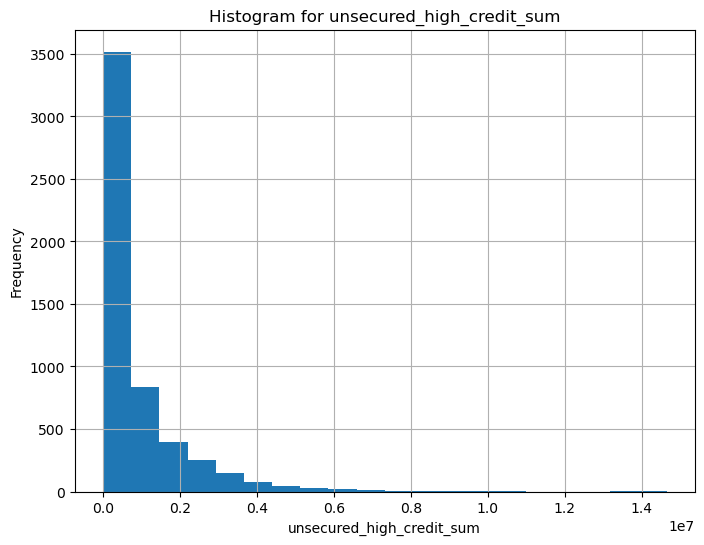

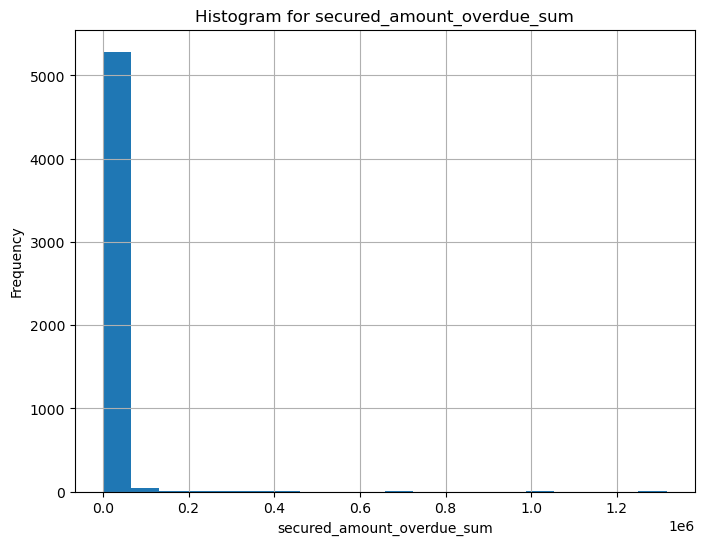

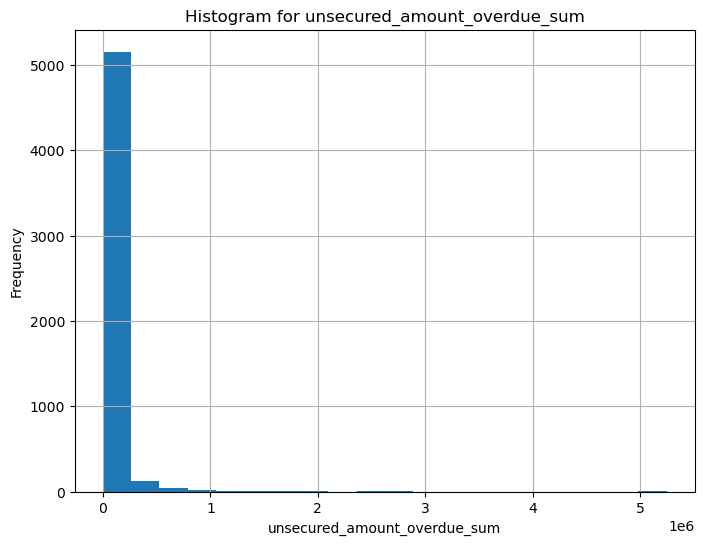

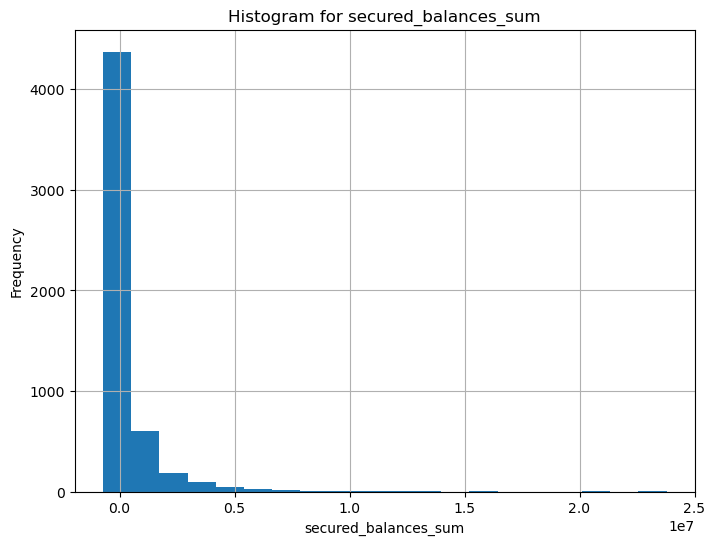

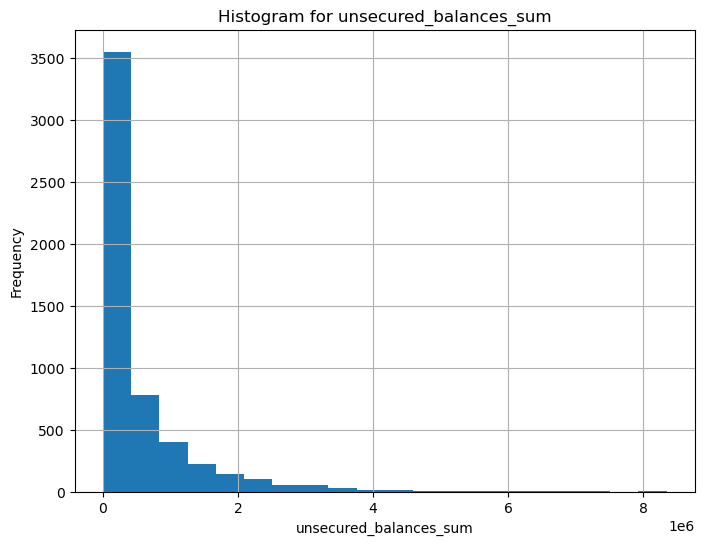

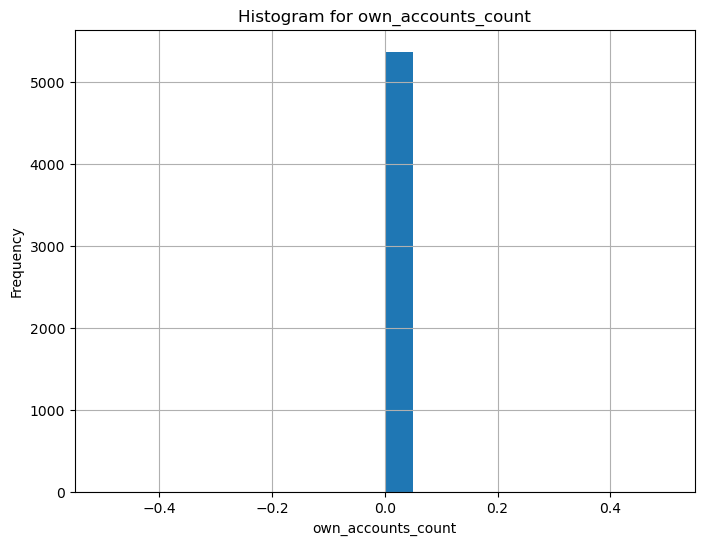

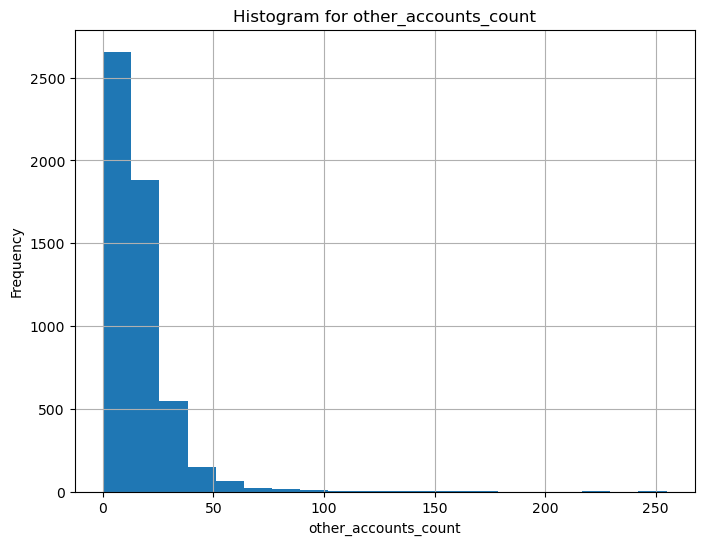

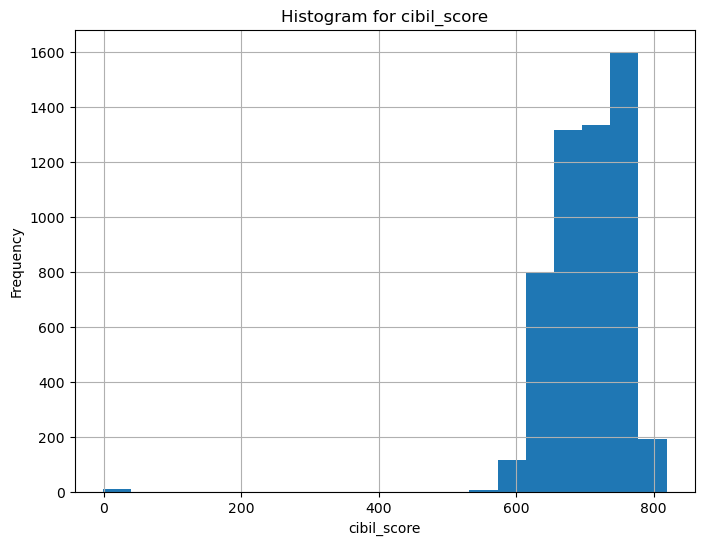

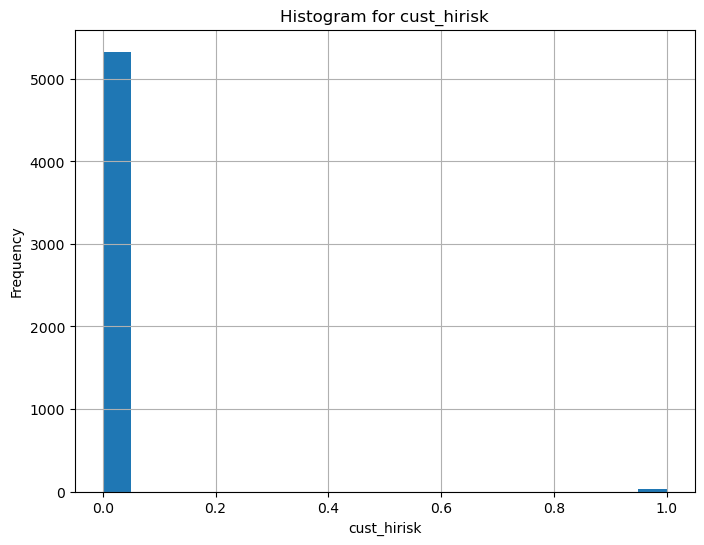

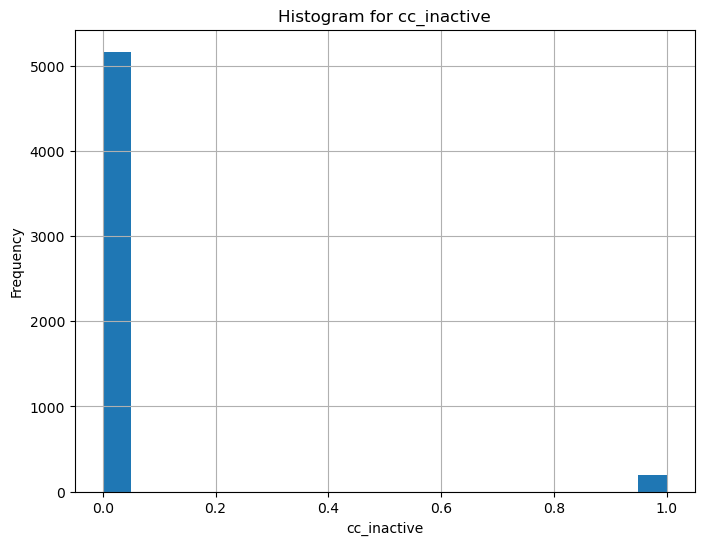

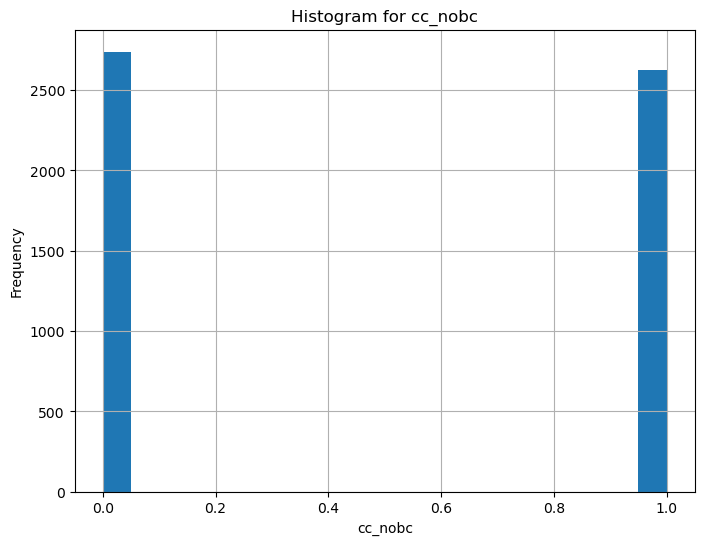

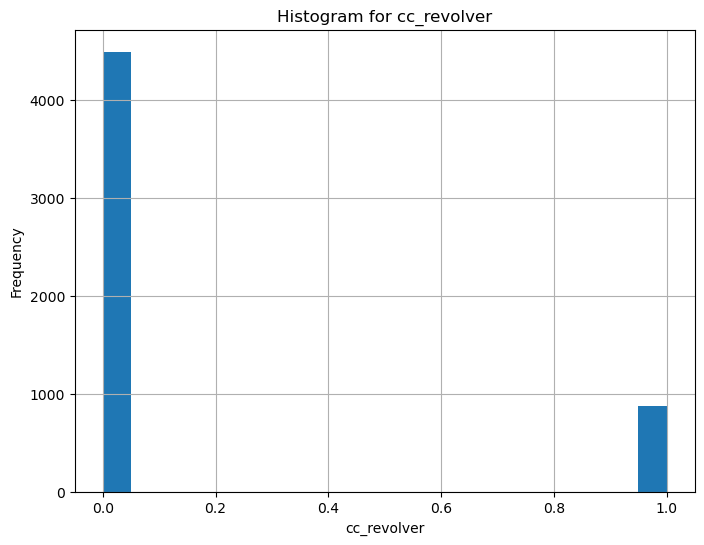

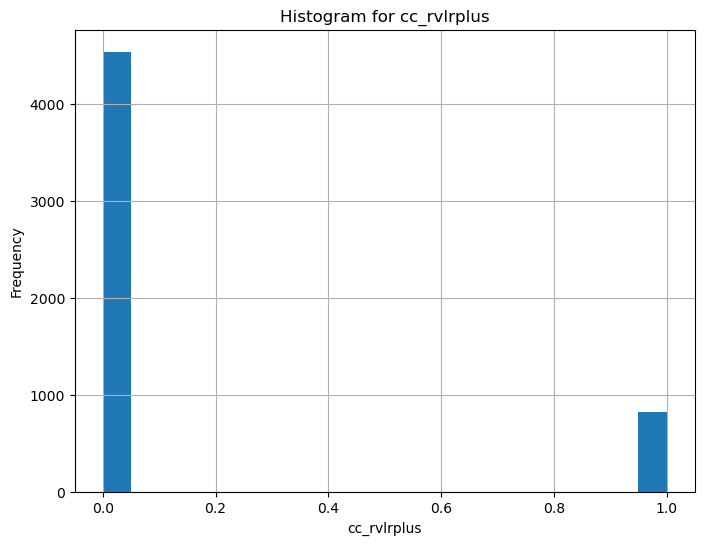

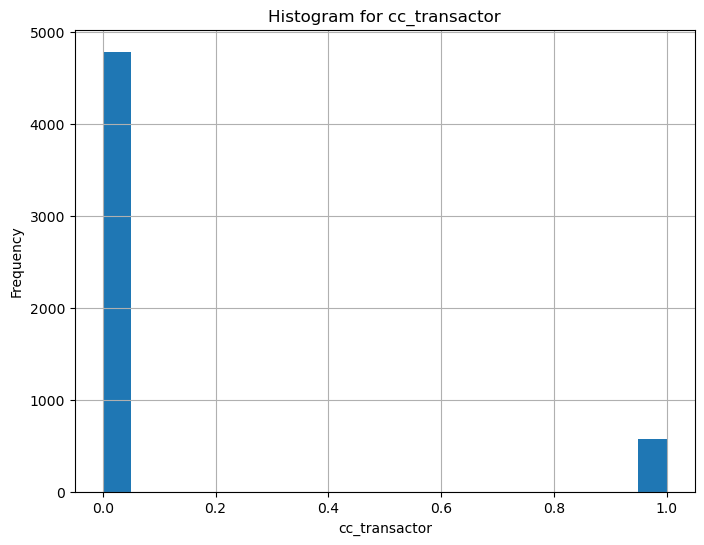

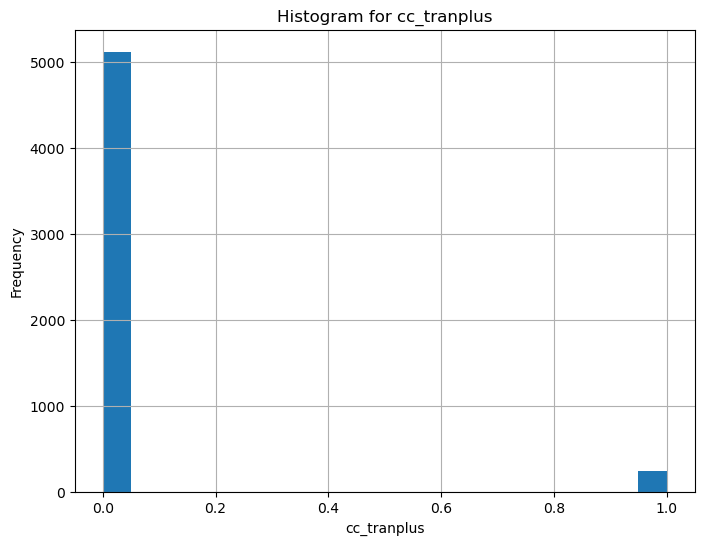

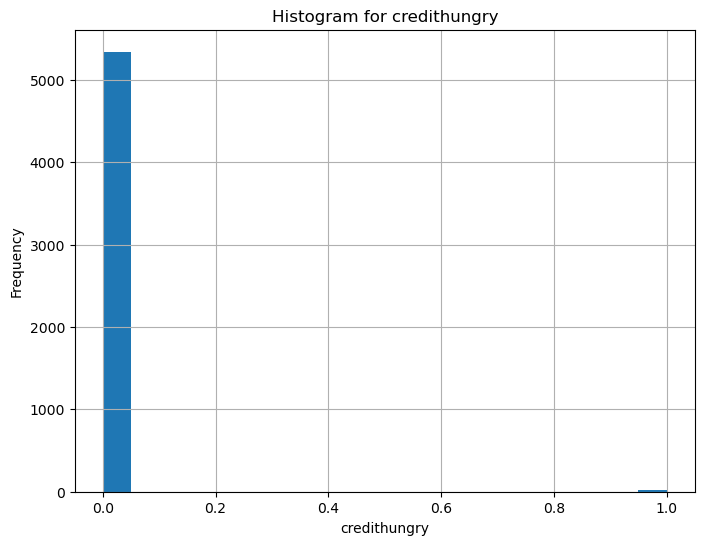

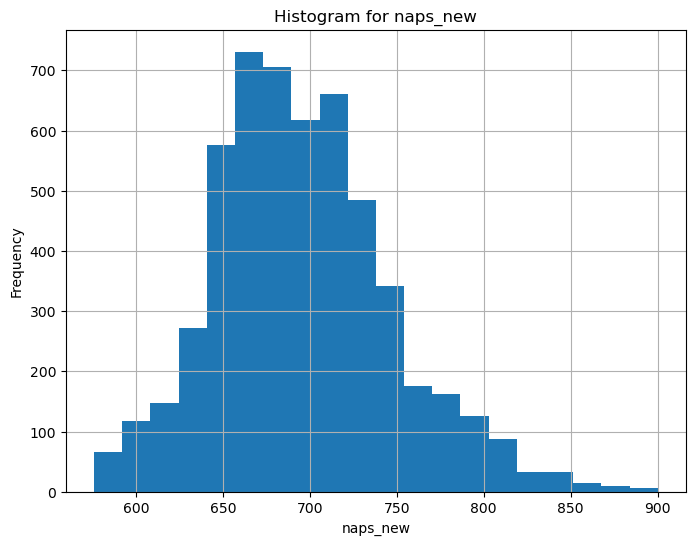

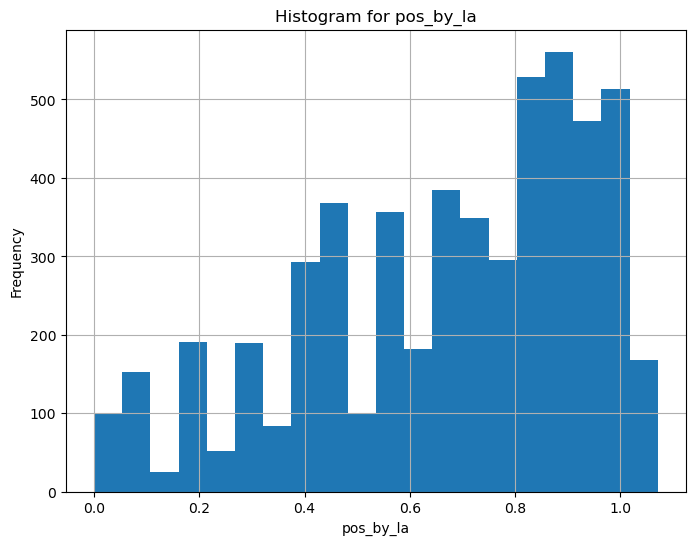

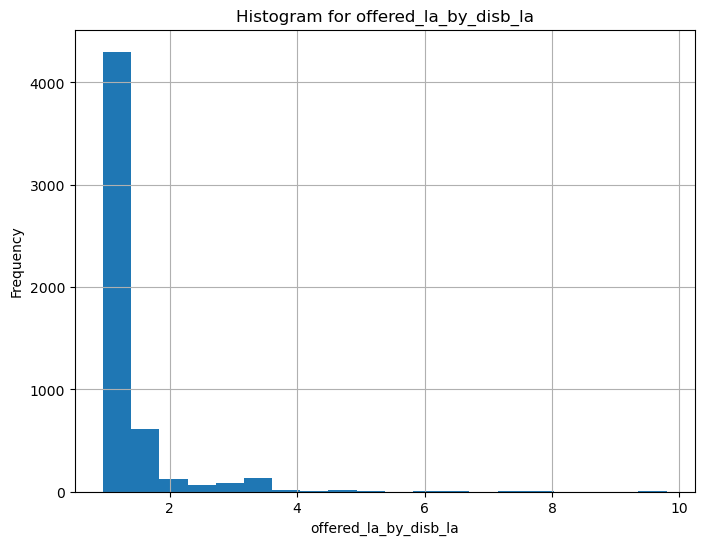

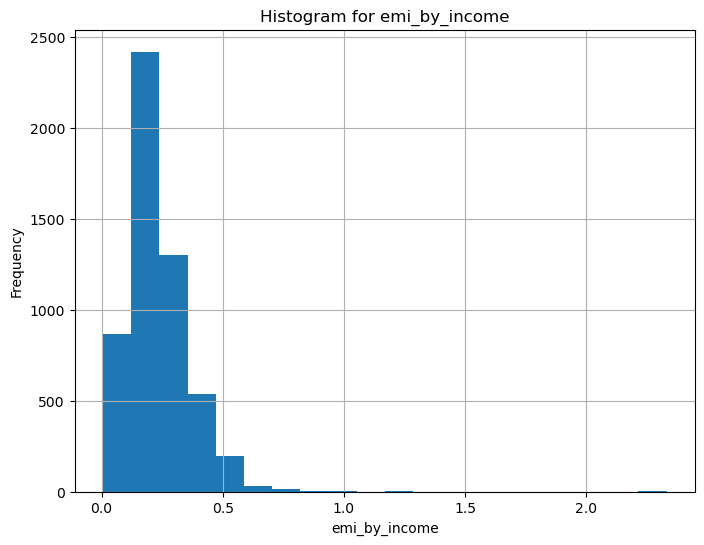

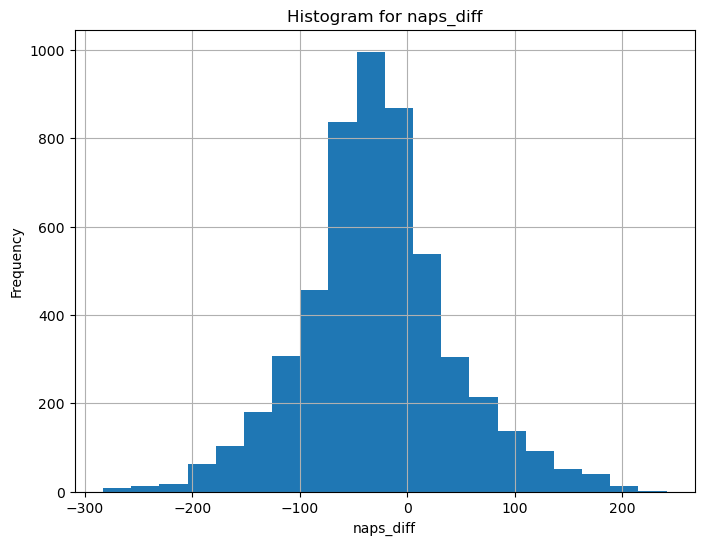

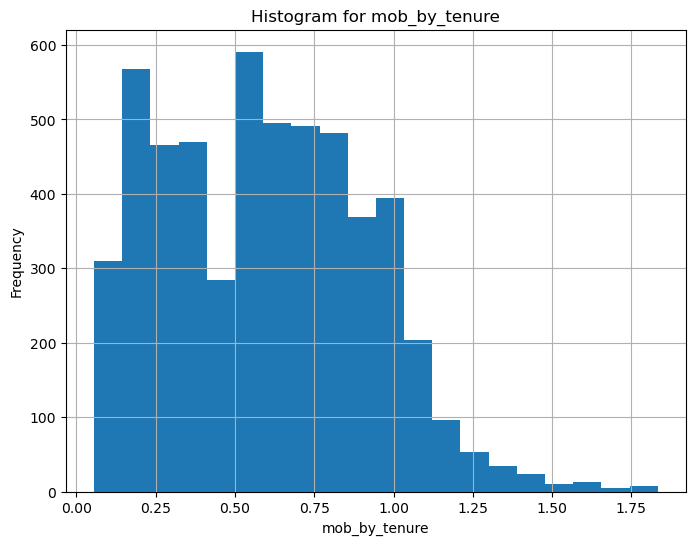

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming master_data is your DataFrame
# Replace 'YourCategoricalColumn' and 'YourNumericalColumn' with the actual column names

# Display value counts for categorical columns
categorical_columns = master_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Value counts for {col}:")
    print(master_data[col].value_counts())
    print("\n")

# Display separate histograms for numerical columns
numerical_columns = master_data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    master_data[col].hist(bins=20)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [61]:
master_data.to_pickle('master_data.pkl')